In [3]:
!pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from glob import glob
import os
from collections import Counter
import re
import string
import csv
import itertools
from sklearn.metrics import r2_score
import math
import seaborn as sns
import scipy.stats
from Bio.Seq import Seq
import Bio.Align

In [4]:
# Directories with paired read data -> import data from last few runs
samples_dirs = ['merged/merged']


In [5]:
sequencing_path_list_barcodes = []
for samples_dir in samples_dirs:
    sequencing_path_list_barcodes = sequencing_path_list_barcodes + glob(os.path.join(samples_dir,'*.assembled.fastq'))
    

In [6]:
[os.path.basename(s) for s in sequencing_path_list_barcodes]

['STK11_Tile3_S196.assembled.fastq',
 'ETV6_Tile1_S60.assembled.fastq',
 'SMS_Tile3_S188.assembled.fastq',
 'SLC6A8_tile2_lib_S2.assembled.fastq',
 'FRED2_10_S252.assembled.fastq',
 'RAB18_Tile1_S124.assembled.fastq',
 'SMS_Tile6_S191.assembled.fastq',
 'PRKAG2_Tile2_S100.assembled.fastq',
 'RUNX1_Tile4_S169.assembled.fastq',
 'Rac1_Tile3_S136.assembled.fastq',
 'RAB1A_Tile3_S112.assembled.fastq',
 'NHLRC1_Tile3_S89.assembled.fastq',
 'BBS1_Tile4_S36.assembled.fastq',
 'BBS1_Tile7_S39.assembled.fastq',
 'PRKAG2_Tile5_S103.assembled.fastq',
 'TANGO2_Tile2_S216.assembled.fastq',
 'FRED2_9_S251.assembled.fastq',
 'STK11_Tile6_S199.assembled.fastq',
 'RHOA_Tile4_S160.assembled.fastq',
 'RHEB_Tile3_S155.assembled.fastq',
 'FRED1_9_S240.assembled.fastq',
 'circRNA_architectures_full_order_final_S19.assembled.fastq',
 'RHOA_Tile2_S158.assembled.fastq',
 'RAC1_block1_G12C_tile_lib_S3.assembled.fastq',
 'RUNX1_Tile1_S166.assembled.fastq',
 'FRED1_2_S233.assembled.fastq',
 'RAB7A_Tile1_S114.asse

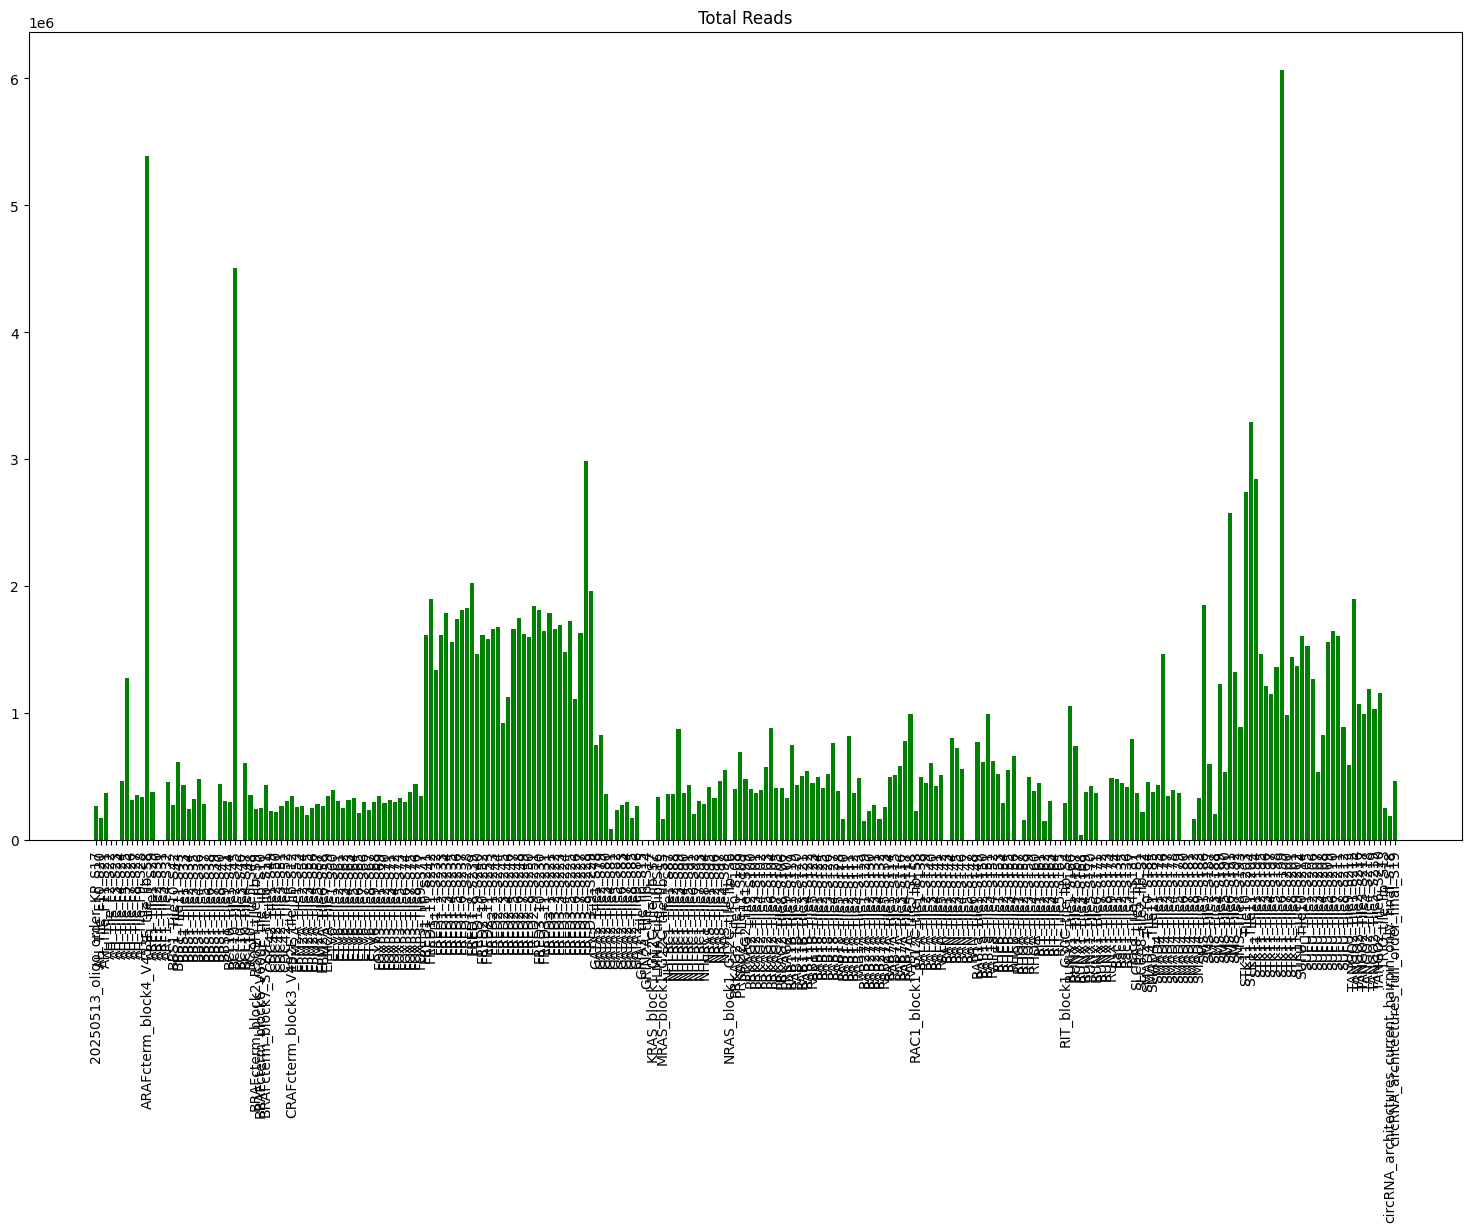

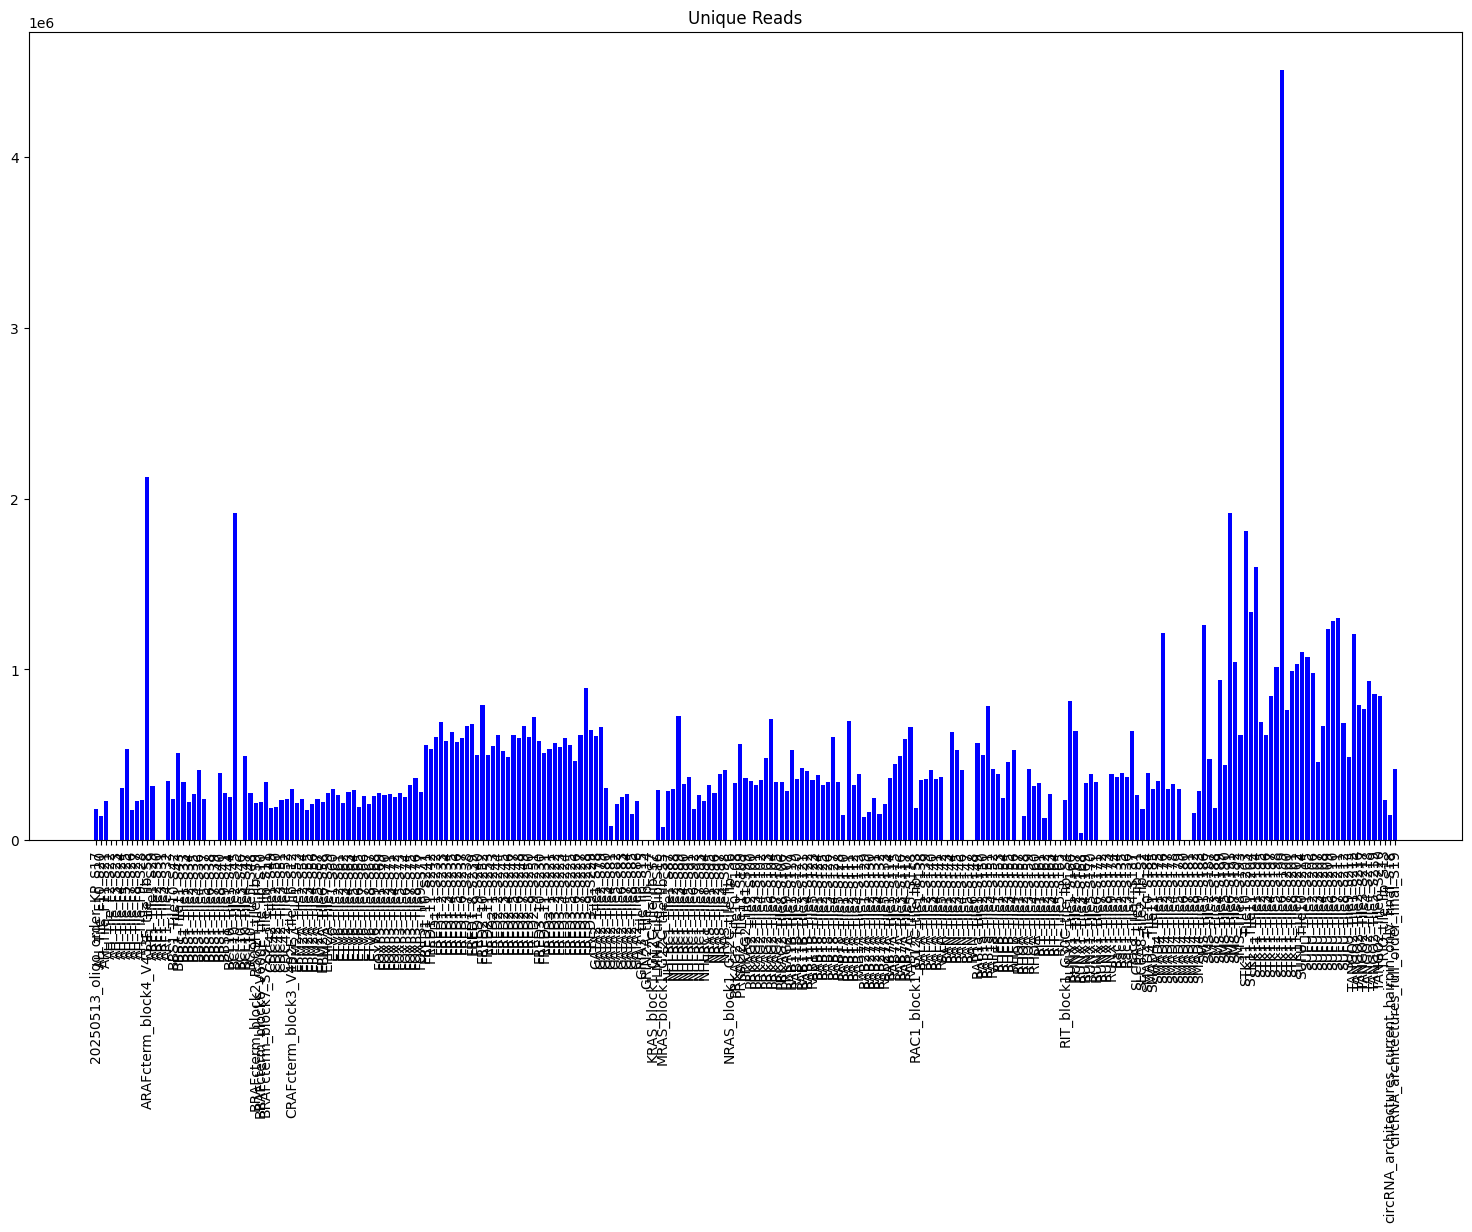

In [7]:
#import reads
barcodes_now = {}
for (i, filename) in enumerate(sequencing_path_list_barcodes):
    with open(filename, 'r') as f:
        lines = f.readlines()
        barcodes = [line.rstrip() for line in lines[1::4]]
    f.close()
    barcodes_now[os.path.basename(filename).split('.')[0]] = barcodes


# sort keys
oligo_subpools = list(barcodes_now.keys())
oligo_subpools.sort()
    
#read count
read_count = [len(s) for s in [barcodes_now[key] for key in oligo_subpools]] 
fig = plt.figure()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.bar(oligo_subpools, read_count, color='g')
plt.xticks(rotation=90)
plt.title('Total Reads')
plt.show()

#unique reads
barcodes_unique = {}
barcodes_unique_count = {}
barcodes_freq = {}

for key in oligo_subpools:
    barcodes_unique[key] = list(set(barcodes_now[key]))
    barcodes_unique_count[key] = Counter(barcodes_now[key])
    barcodes_freq[key] = {}
    totalreads = len(barcodes_now[key])
    for item, count in barcodes_unique_count[key].items():
        barcodes_freq[key][item] = count/totalreads

#unique read count
unique_read_count = [len(s) for s in [barcodes_unique[key] for key in oligo_subpools]] 
fig = plt.figure()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.bar(oligo_subpools, unique_read_count, color='b')
plt.xticks(rotation=90)
plt.title('Unique Reads')
plt.show()




In [8]:
barcodes_real = {}
cutoffs = {}
for key in oligo_subpools:
    cutoffs[key] = 100/10**6 * len(barcodes_now[key])
    barcodes_real[key] = [r for r,s in barcodes_unique_count[key].items() if s >= cutoffs[key]]
    

In [24]:
# Set cutoffs for each sample using the largest change in slope (excluding first/last 10%)
barcodes_real = {}
cutoffs = {}
window = 7  # should match previous smoothing
for key in oligo_subpools:
    labels, values = zip(*barcodes_unique_count[key].items())
    bins = 10**np.linspace(0, 4, 100)
    hist_counts, bin_edges = np.histogram(values, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    mask = hist_counts > 0
    x = bin_centers[mask]
    y = hist_counts[mask]
    if len(y) >= window:
        y_smooth = np.convolve(y, np.ones(window)/window, mode='same')
        log_x = np.log10(x)
        log_y = np.log10(y_smooth)
        slope = np.gradient(log_y, log_x)
        n = len(x)
        start = int(0.1 * n)
        end = int(0.9 * n)
        slope_focus = slope[start:end]
        x_focus = x[start:end]
        if len(x_focus) > 0:
            max_idx = np.argmax(np.abs(slope_focus))
            x_max = x_focus[max_idx]
            cutoffs[key] = x_max
        else:
            cutoffs[key] = 100/10**6 * len(barcodes_now[key])  # fallback
    else:
        cutoffs[key] = 100/10**6 * len(barcodes_now[key])  # fallback
    barcodes_real[key] = [r for r,s in barcodes_unique_count[key].items() if s >= cutoffs[key]]

20250513_oligo_order_KP_S17


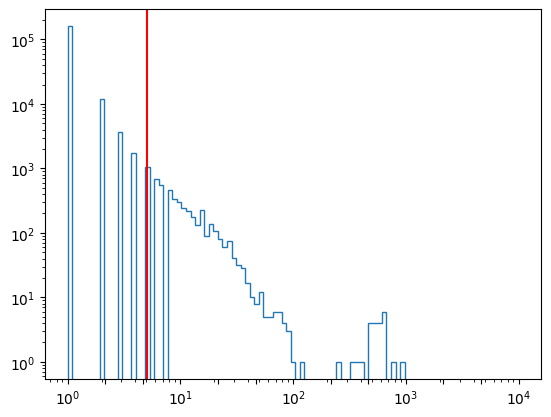

AH_Tile_F10_S20


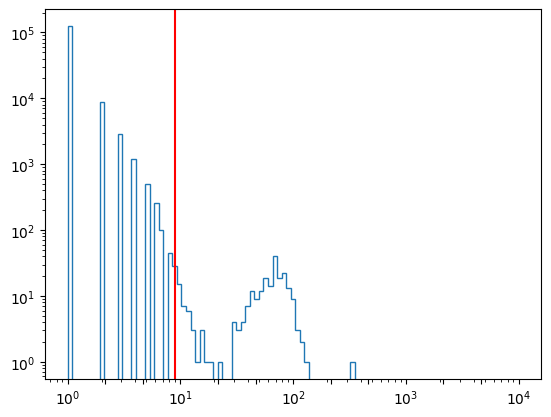

AH_Tile_F11_S21


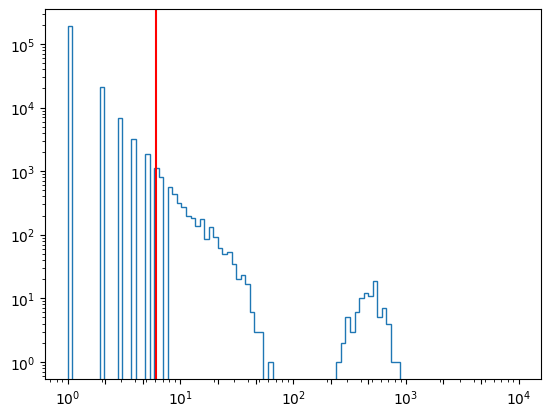

AH_Tile_F2_S22


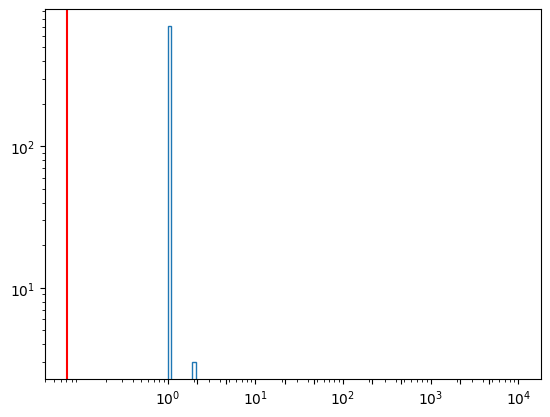

AH_Tile_F3_S23


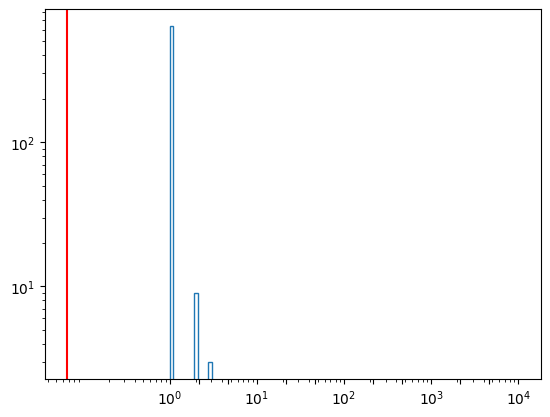

AH_Tile_F4_S24


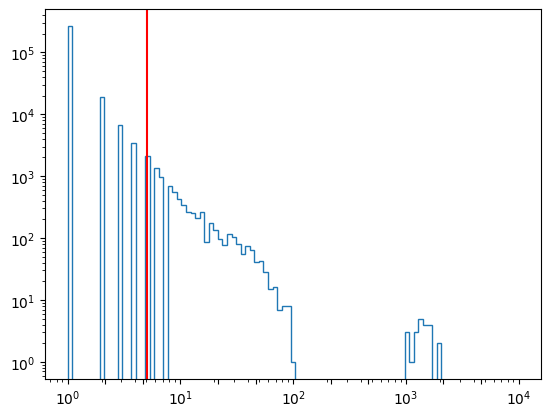

AH_Tile_F5_S25


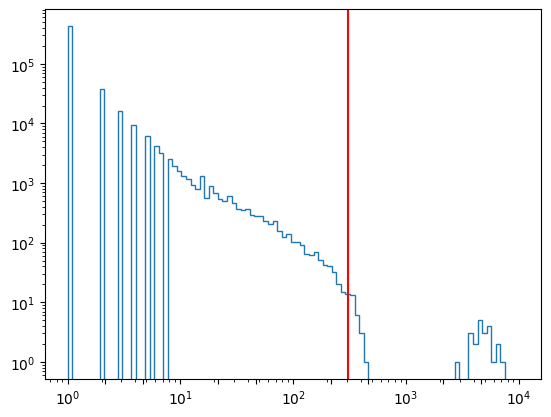

AH_Tile_F7_S26


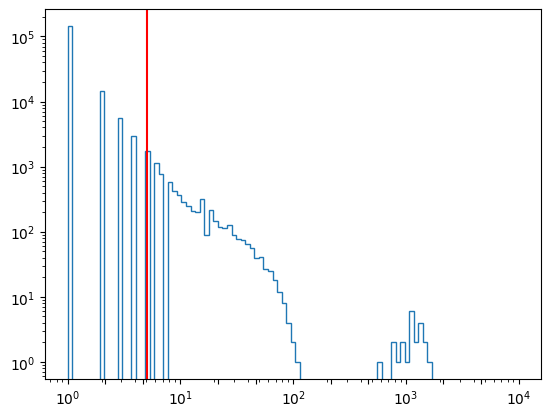

AH_Tile_F8_S27


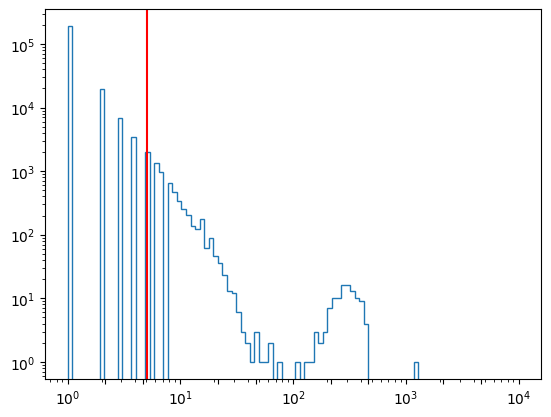

AH_Tile_F9_S28


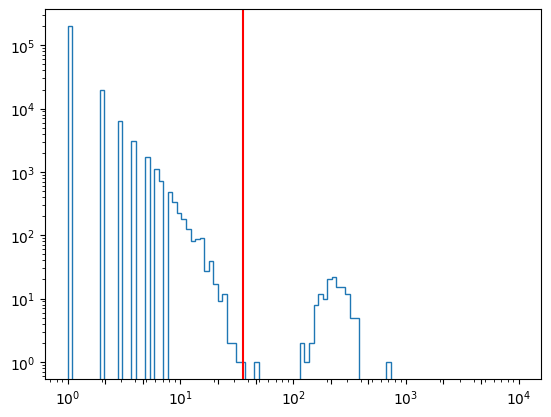

ARAFcterm_block4_V453E_tile_lib_S8


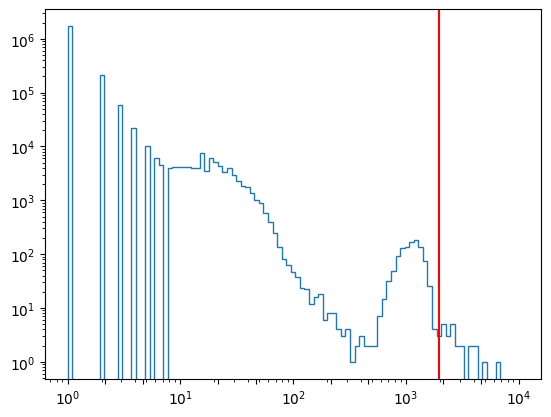

ARF1_Tile1_S29


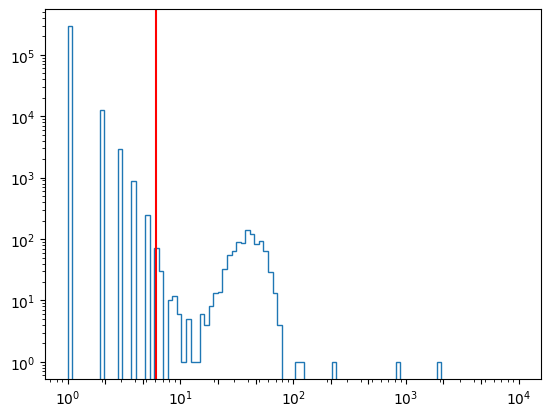

ARF1_Tile2_S30


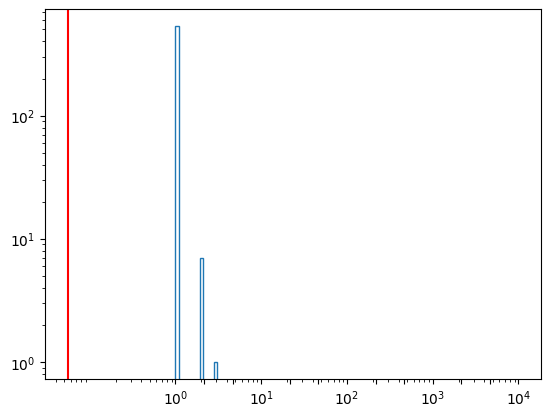

ARF1_Tile3_S31


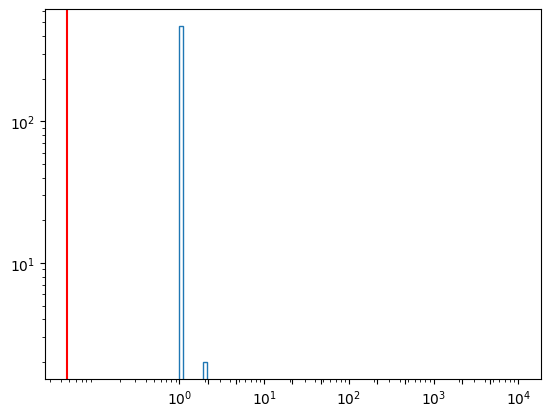

ARF1_Tile4_S32


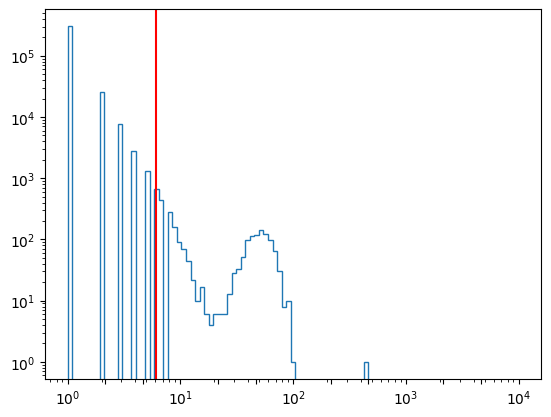

BBS1_Tile10_S42


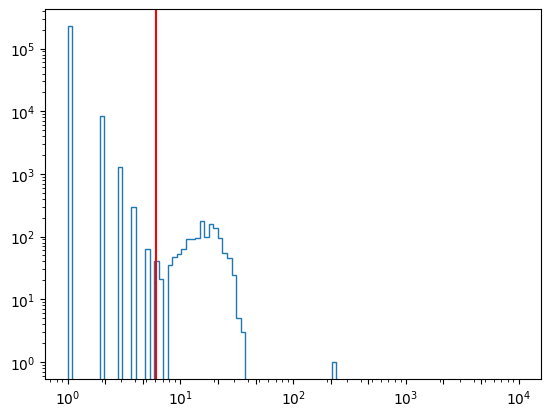

BBS1_Tile11_S43


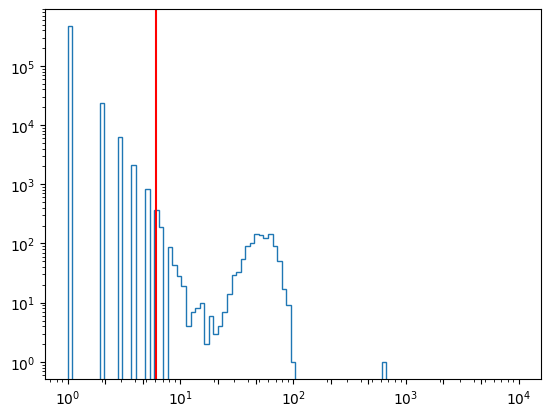

BBS1_Tile1_S33


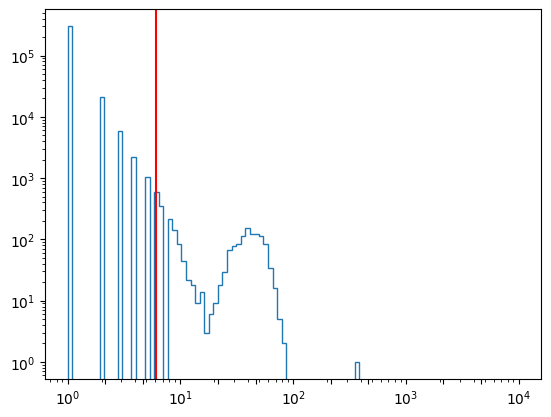

BBS1_Tile2_S34


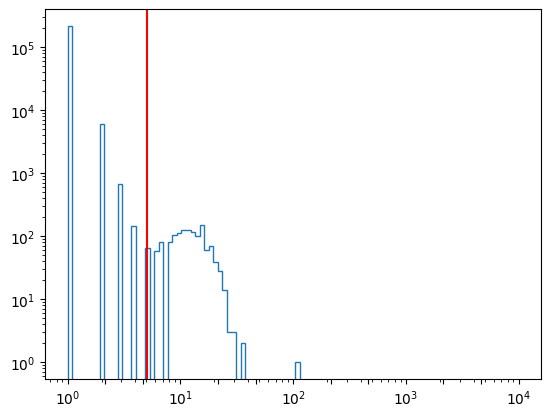

BBS1_Tile3_S35


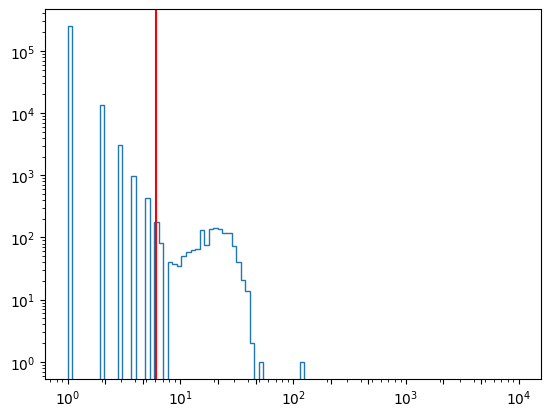

BBS1_Tile4_S36


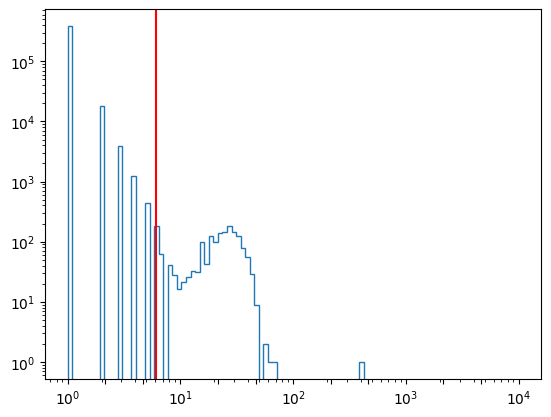

BBS1_Tile5_S37


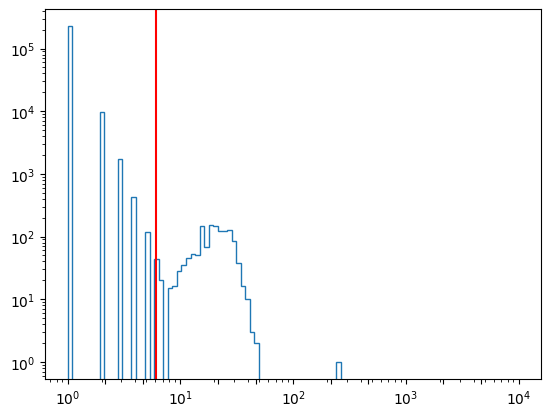

BBS1_Tile6_S38


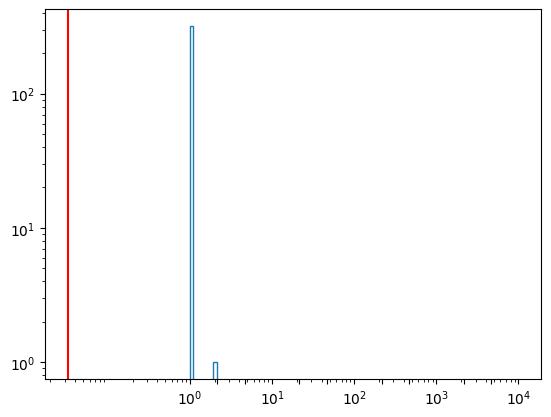

BBS1_Tile7_S39


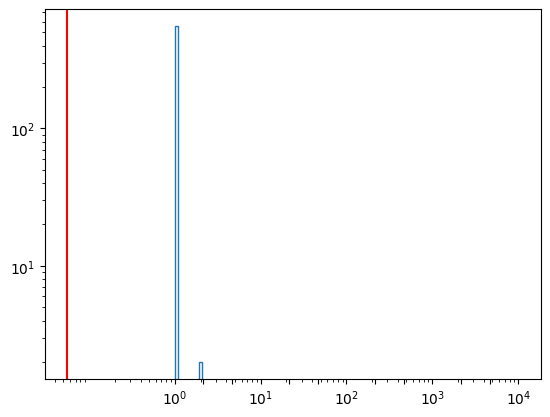

BBS1_Tile8_S40


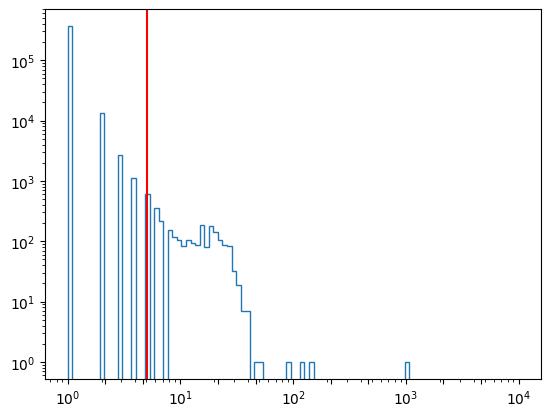

BBS1_Tile9_S41


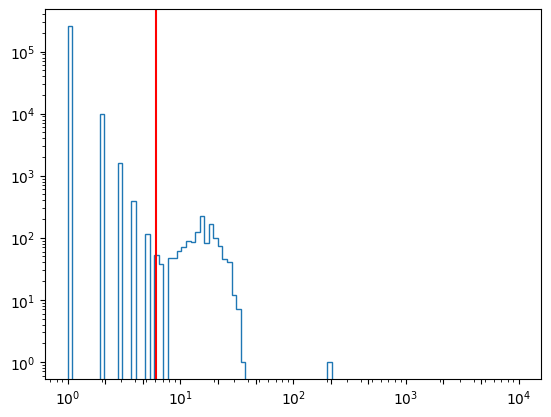

BCL10_Tile1_S44


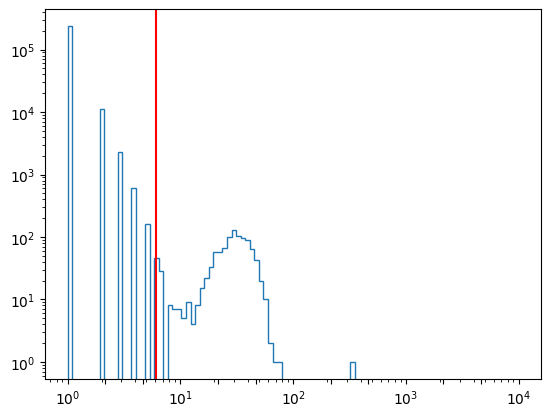

BCL10_Tile2_S45


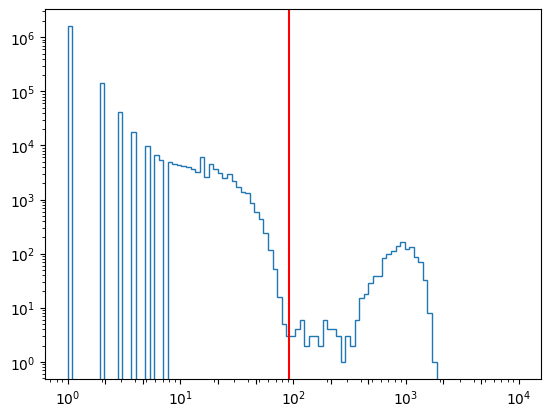

BCL10_Tile3_S46


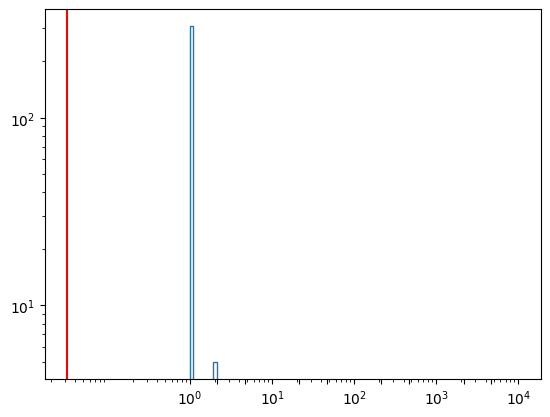

BCL10_Tile4_S47


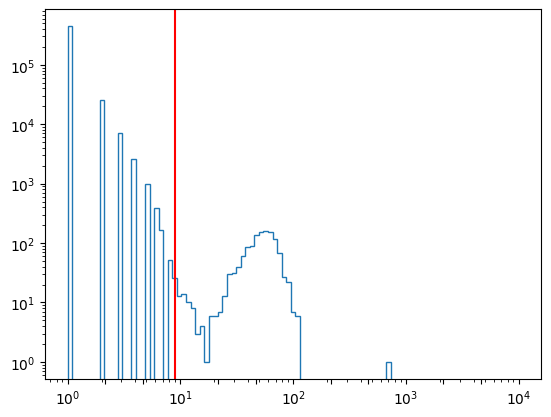

BCL10_Tile5_S48


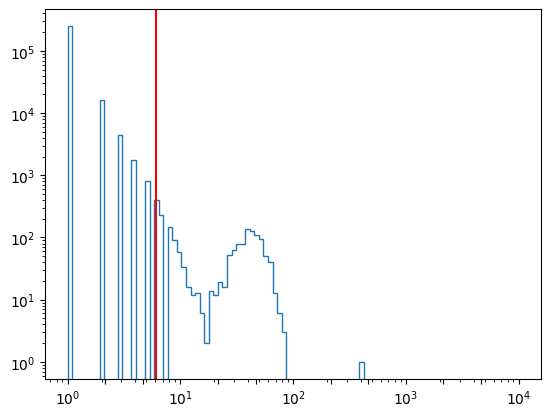

BRAFcterm_block2_R509H_tile_lib_S9


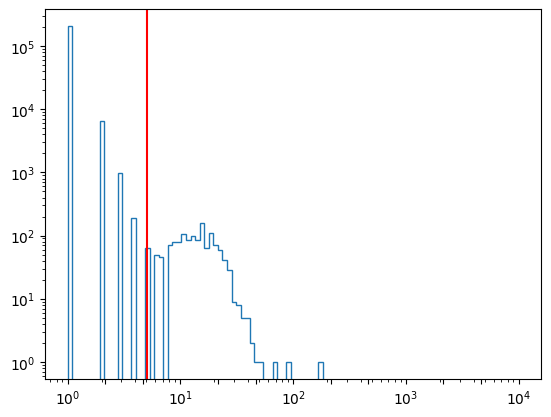

BRAFcterm_block6_V600E_tile_lib_S10


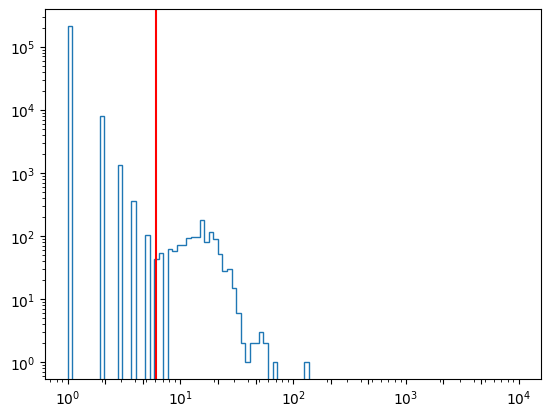

BRAFcterm_block7_S729E_tile_lib_S11


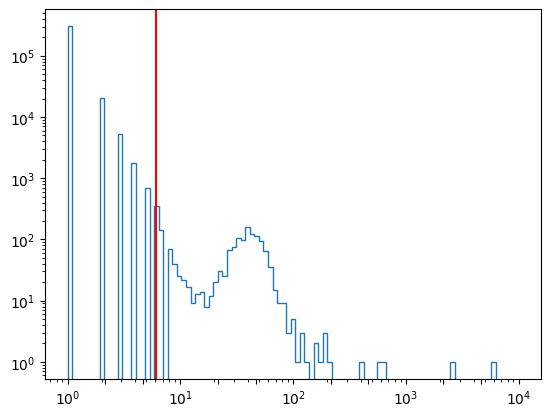

CDC42_Tile1_S49


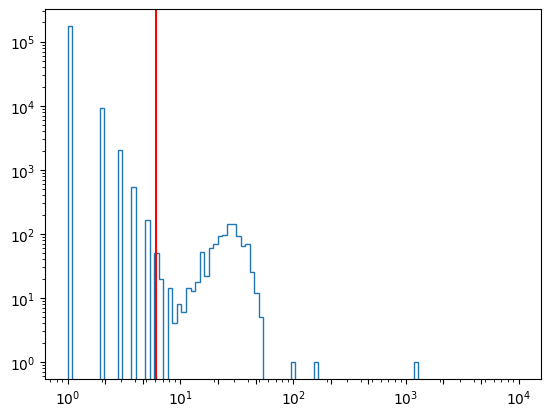

CDC42_Tile2_S50


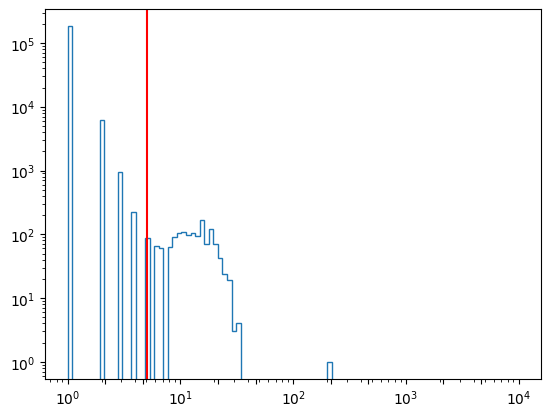

CDC42_Tile3_S51


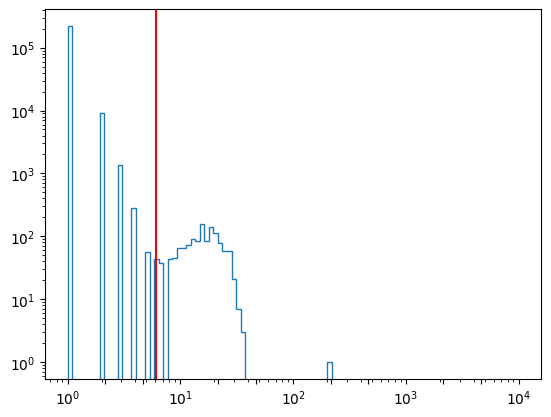

CDC42_Tile4_S52


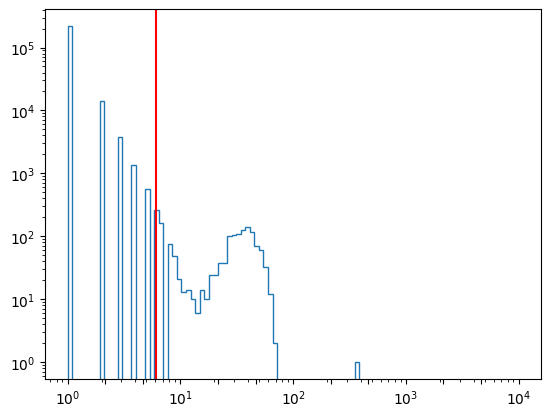

CRAFcterm_block3_V492E_tile_lib_S12


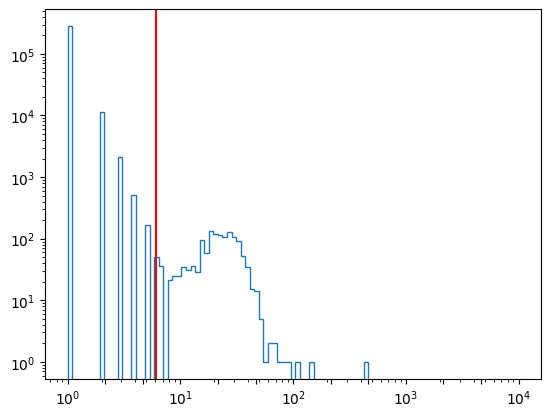

EPM2A_Tile1_S53


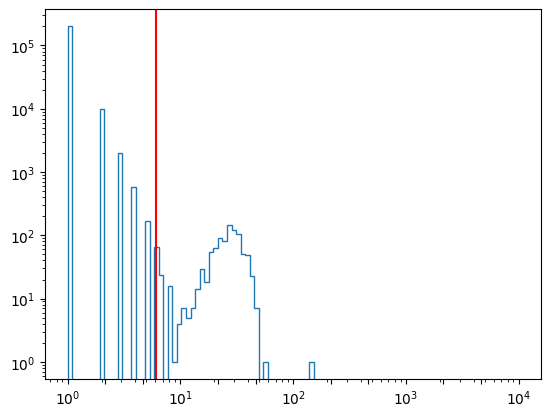

EPM2A_Tile2_S54


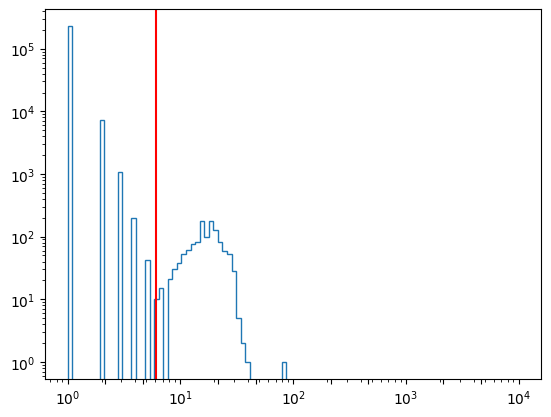

EPM2A_Tile3_S55


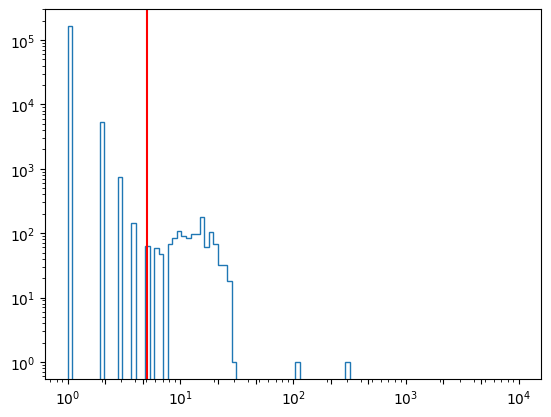

EPM2A_Tile4_S56


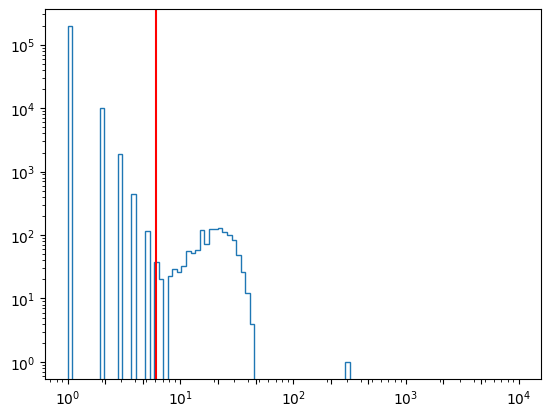

EPM2A_Tile5_S57


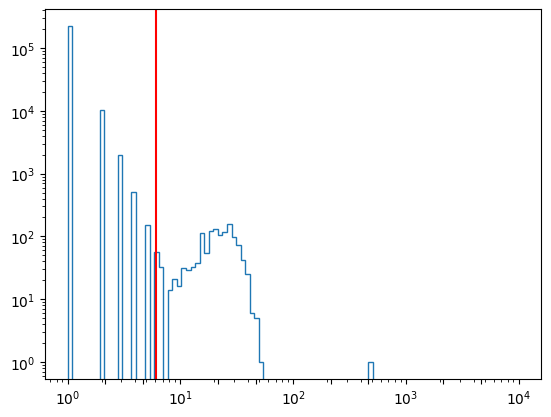

EPM2A_Tile6_S58


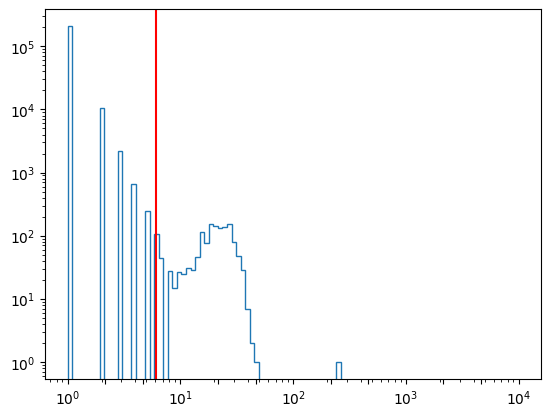

EPM2A_Tile7_S59


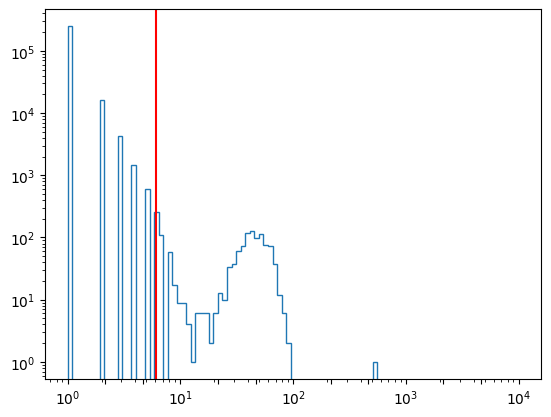

ETV6_Tile1_S60


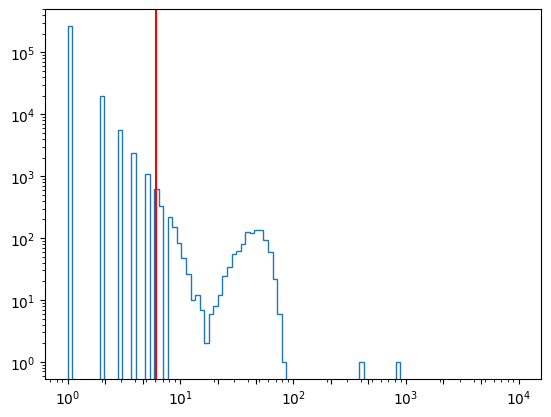

ETV6_Tile2_S61


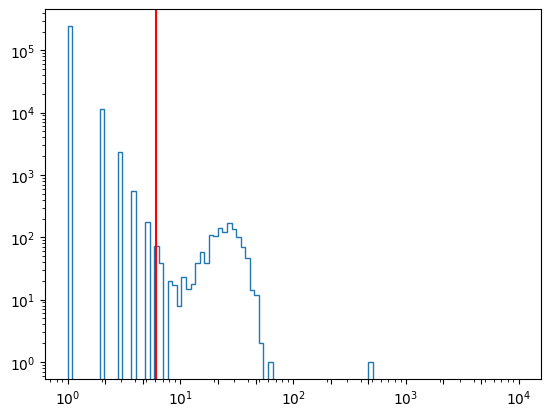

ETV6_Tile3_S62


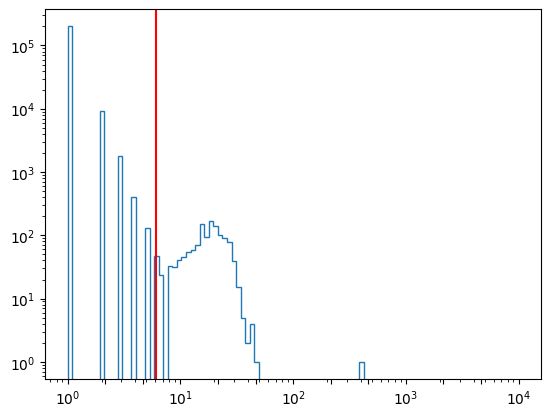

ETV6_Tile4_S63


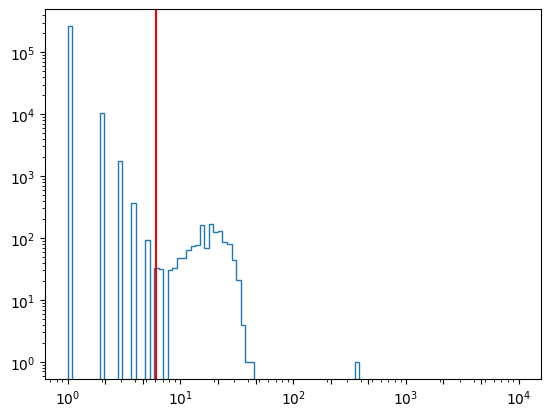

ETV6_Tile5_S64


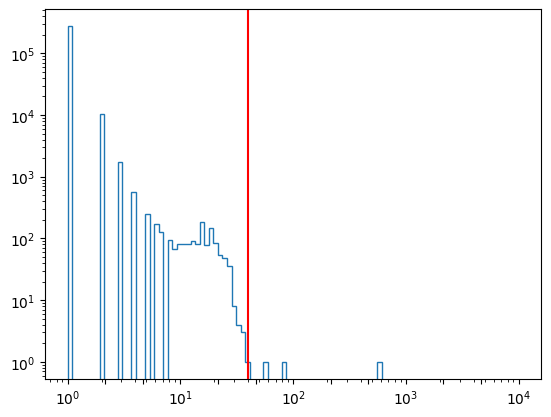

ETV6_Tile6_S65


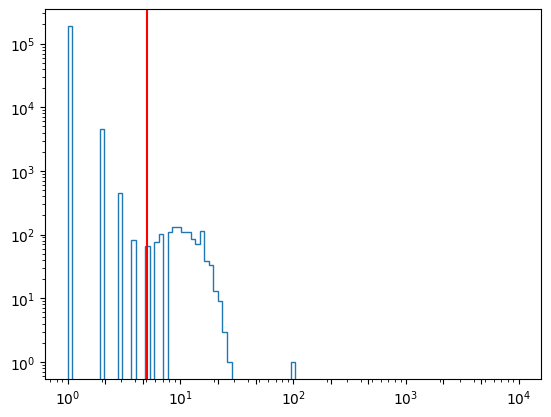

ETV6_Tile7_S66


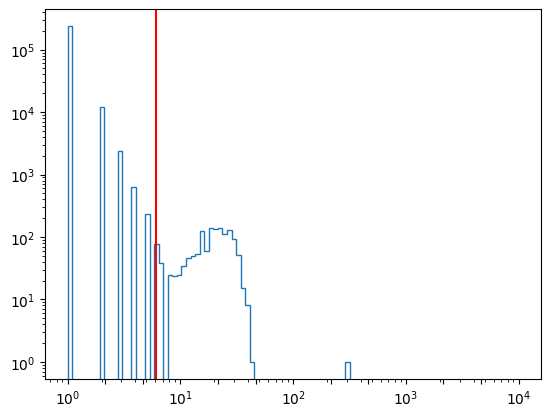

ETV6_Tile8_S67


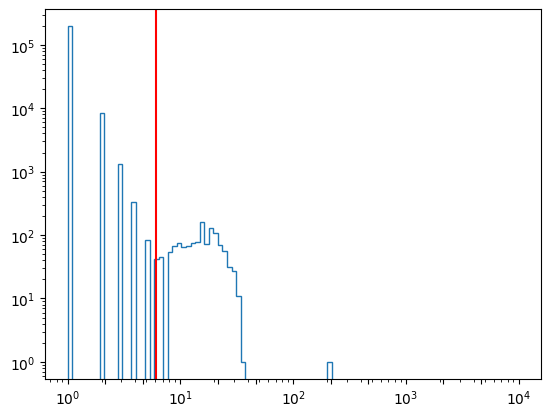

ETV6_Tile9_S68


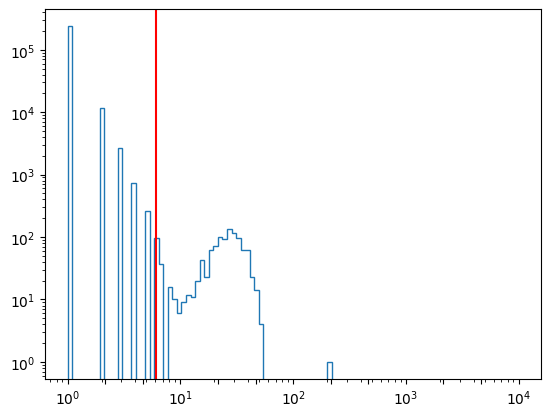

FOXP3_Tile1_S69


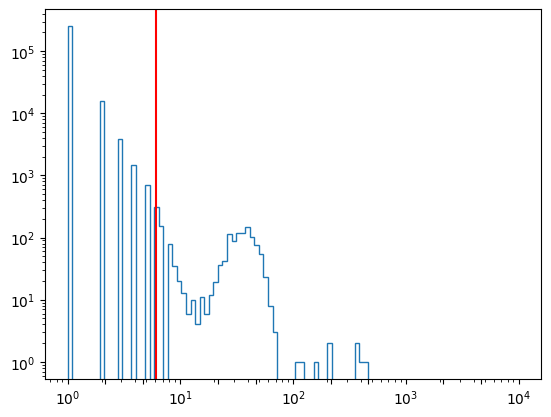

FOXP3_Tile2_S70


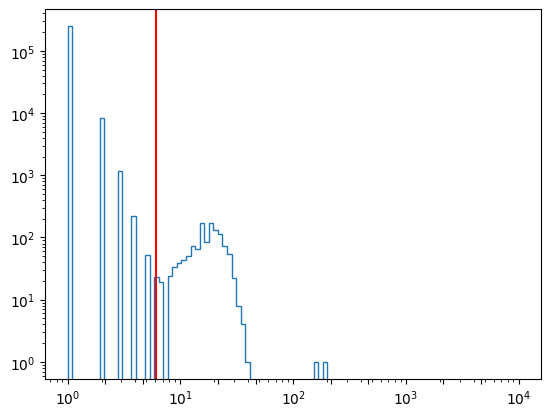

FOXP3_Tile3_S71


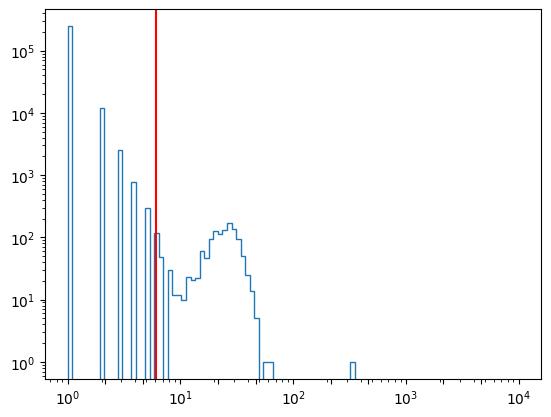

FOXP3_Tile4_S72


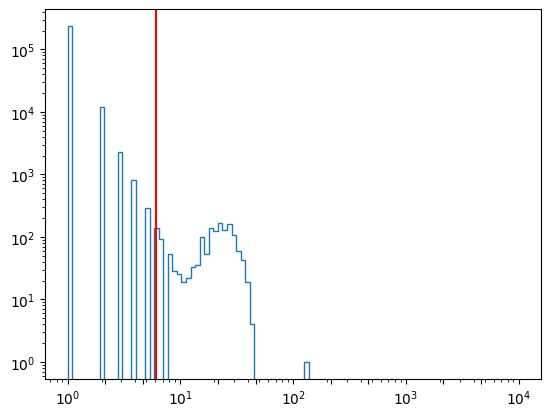

FOXP3_Tile5_S73


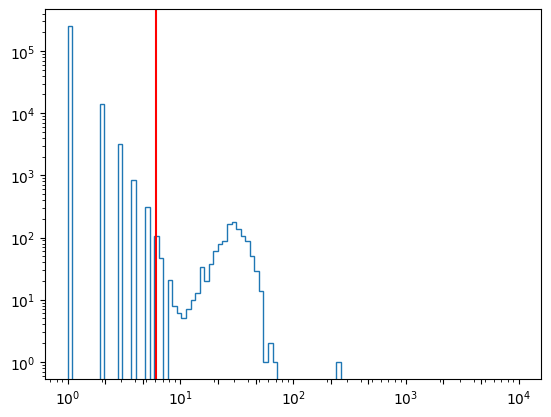

FOXP3_Tile6_S74


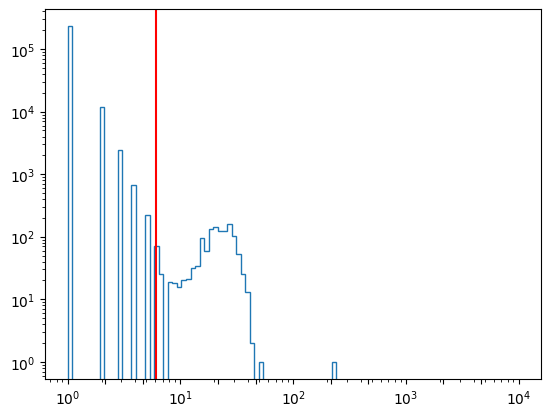

FOXP3_Tile7_S75


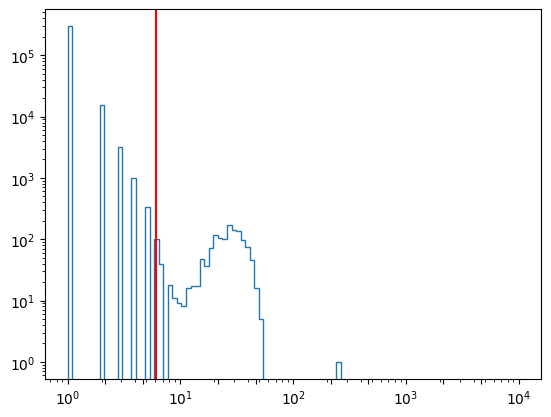

FOXP3_Tile8_S76


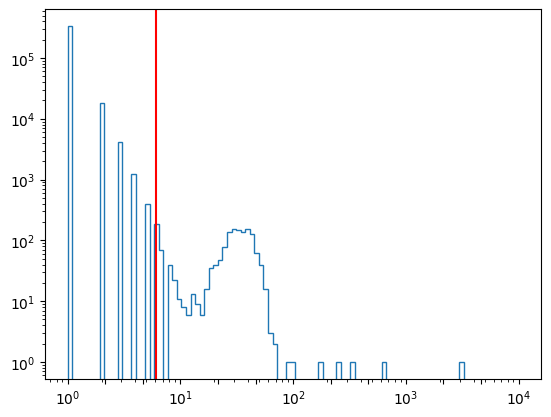

FOXP3_Tile9_S77


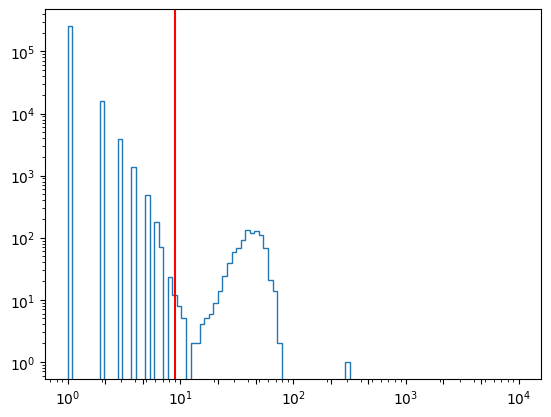

FRED1_10_S241


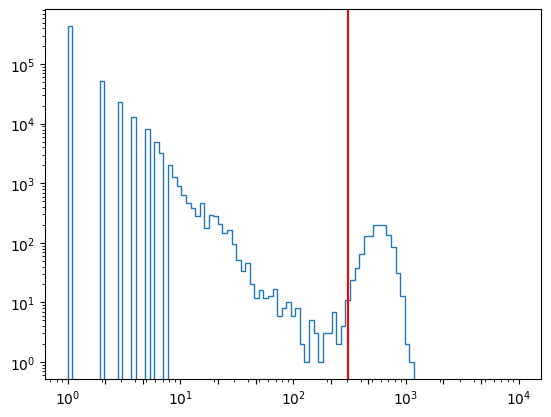

FRED1_11_S242


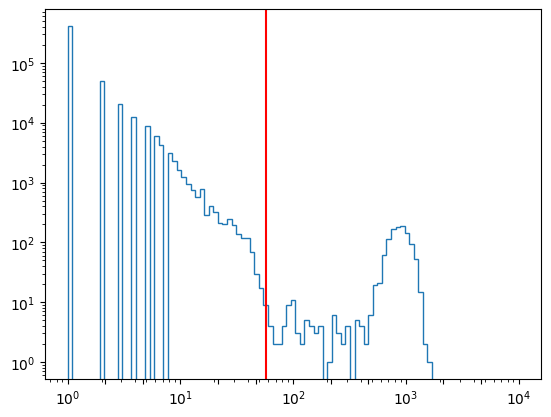

FRED1_1_S232


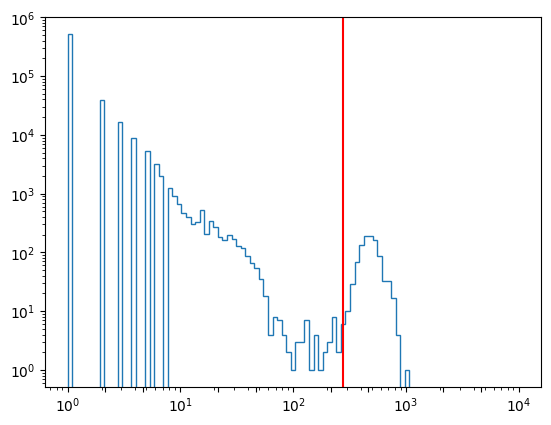

FRED1_2_S233


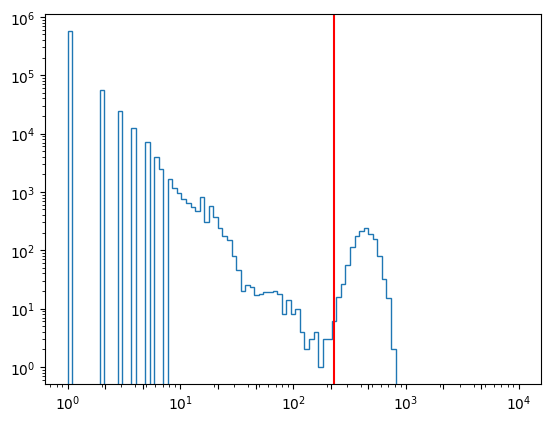

FRED1_3_S234


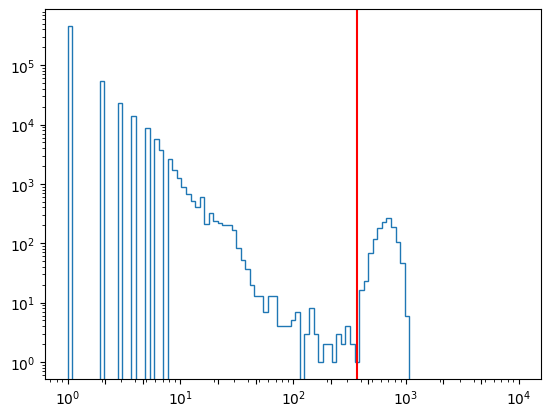

FRED1_4_S235


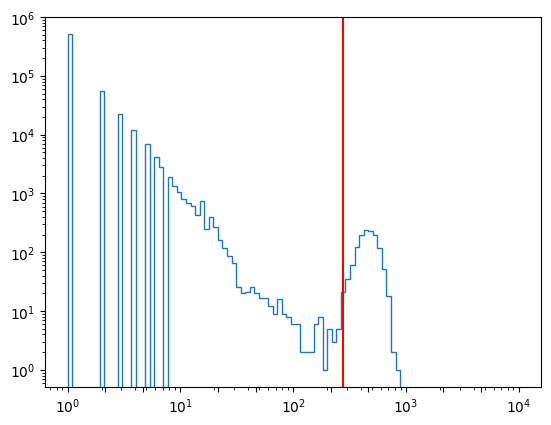

FRED1_5_S236


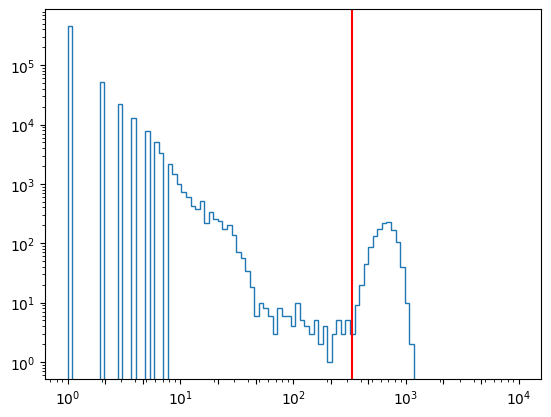

FRED1_6_S237


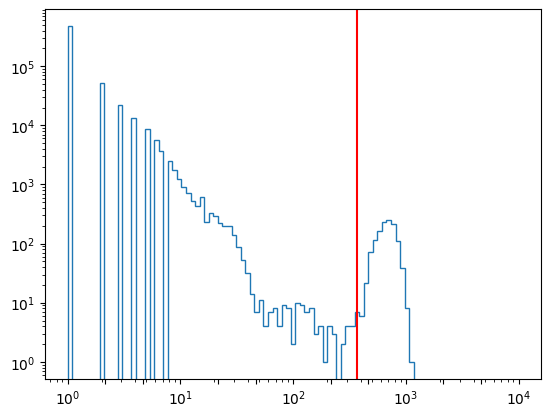

FRED1_7_S238


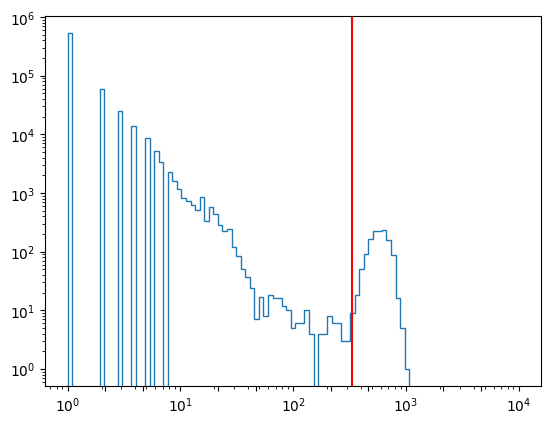

FRED1_8_S239


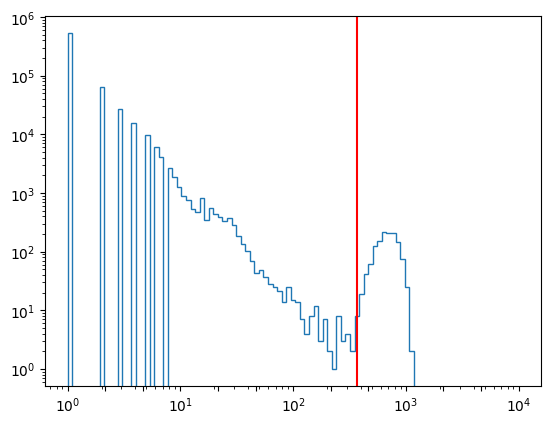

FRED1_9_S240


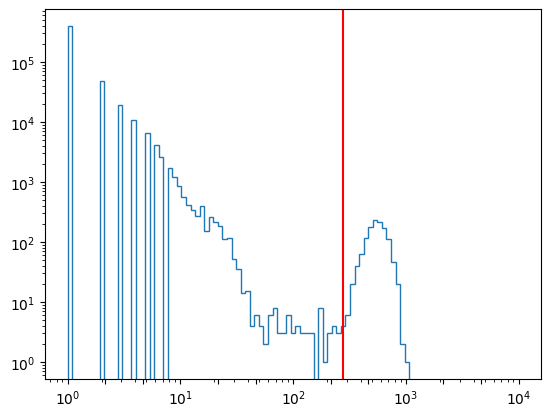

FRED2_10_S252


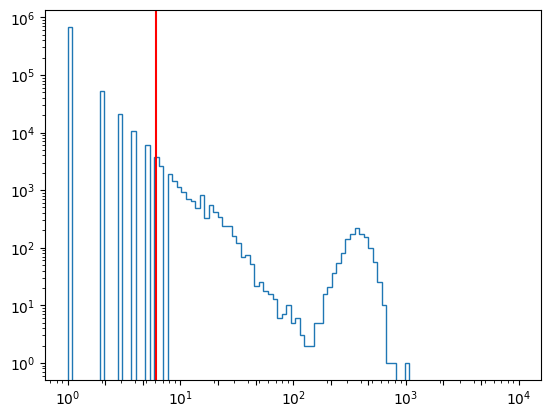

FRED2_11_S253


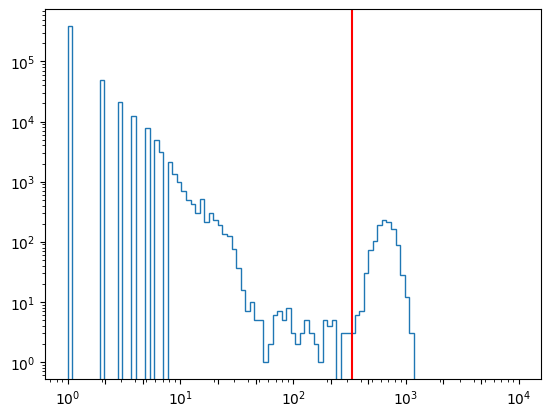

FRED2_1_S243


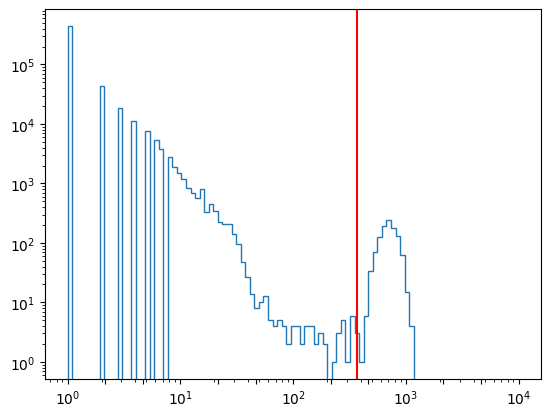

FRED2_2_S244


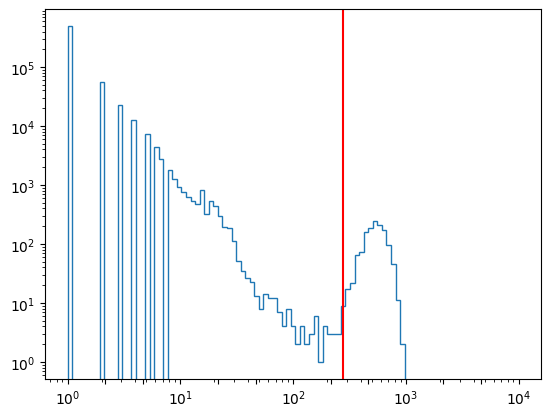

FRED2_3_S245


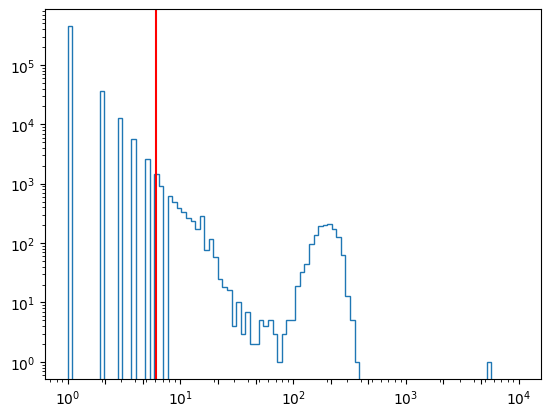

FRED2_4_S246


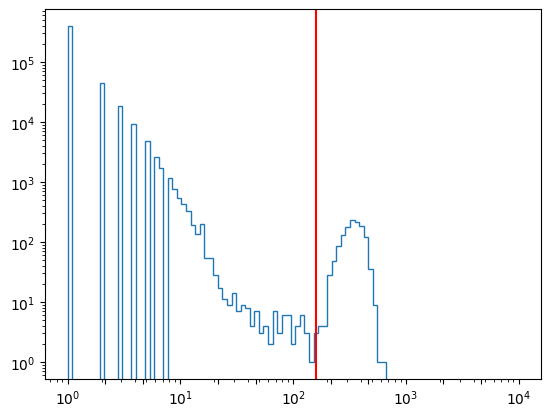

FRED2_5_S247


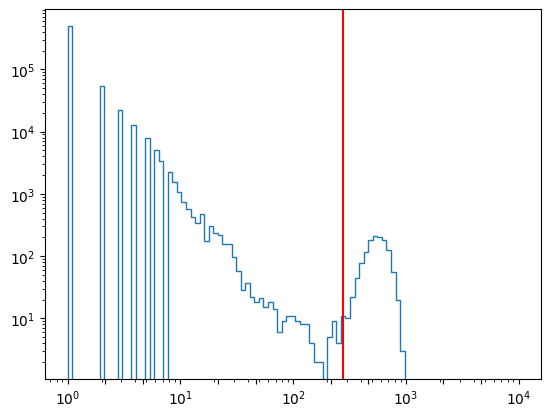

FRED2_6_S248


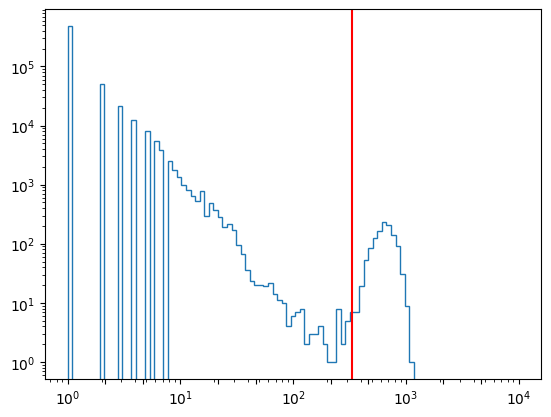

FRED2_7_S249


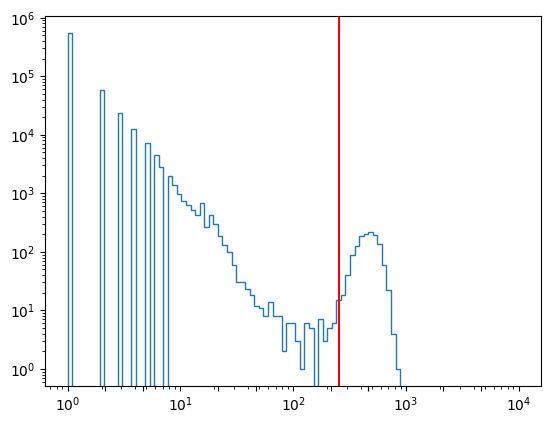

FRED2_8_S250


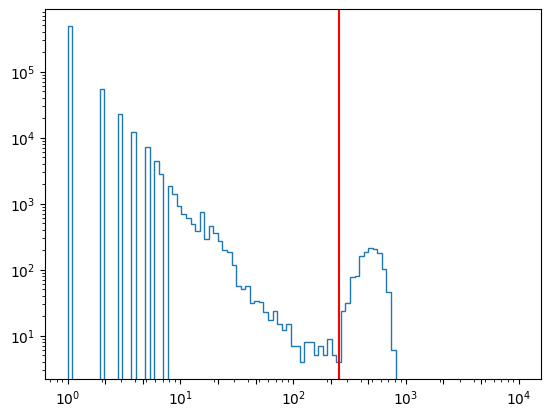

FRED2_9_S251


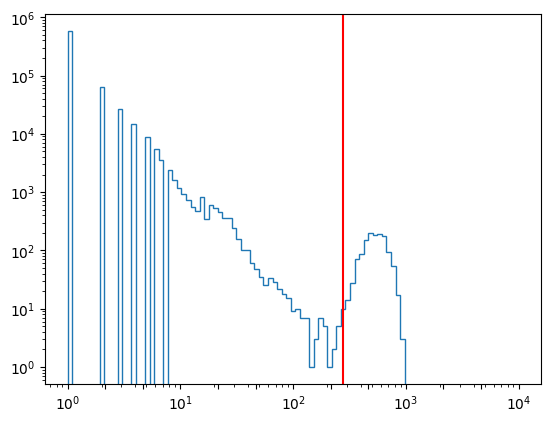

FRED3_10_S230


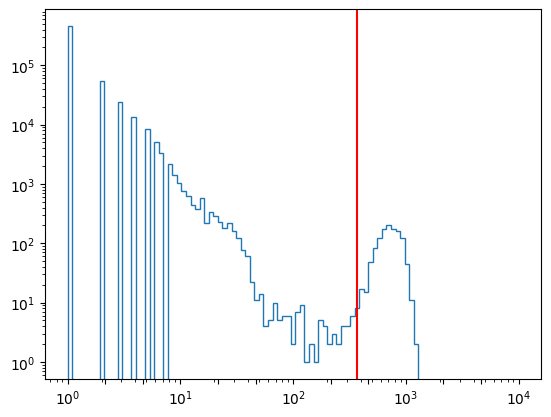

FRED3_11_S231


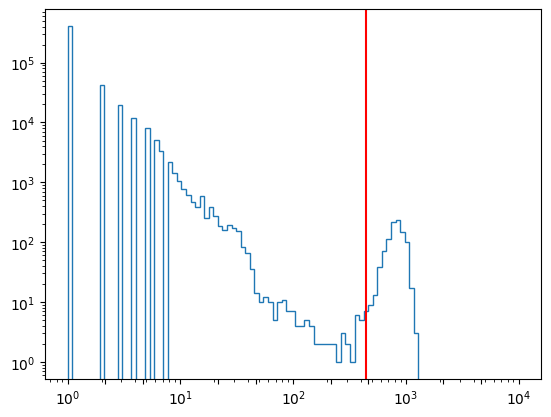

FRED3_1_S221


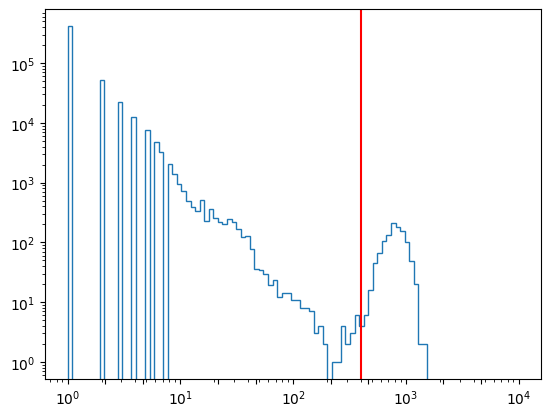

FRED3_2_S222


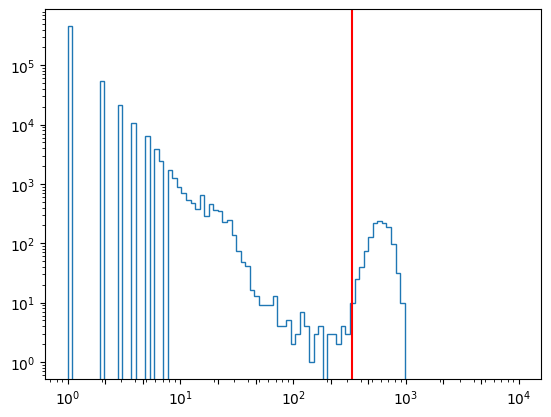

FRED3_3_S223


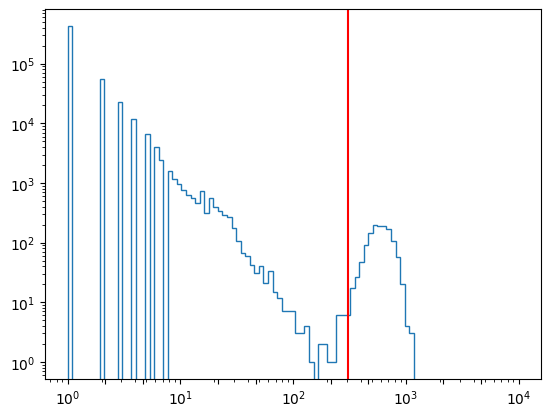

FRED3_4_S224


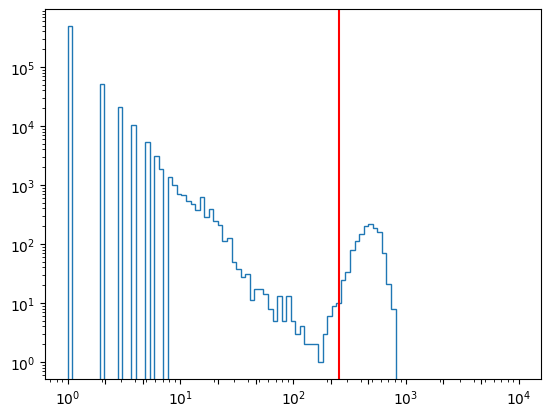

FRED3_5_S225


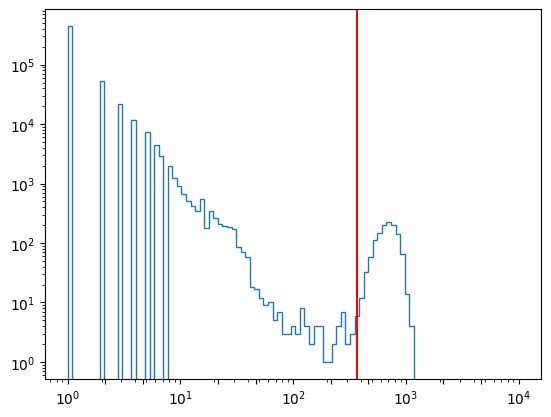

FRED3_6_S226


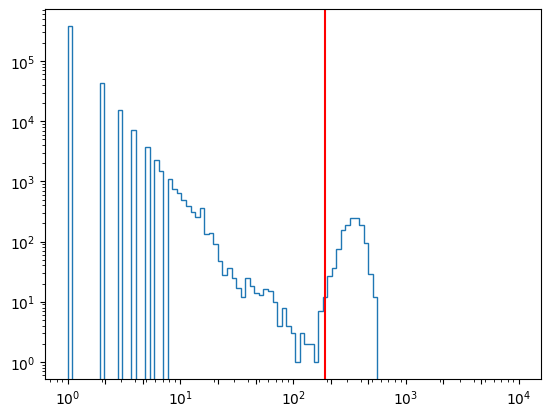

FRED3_7_S227


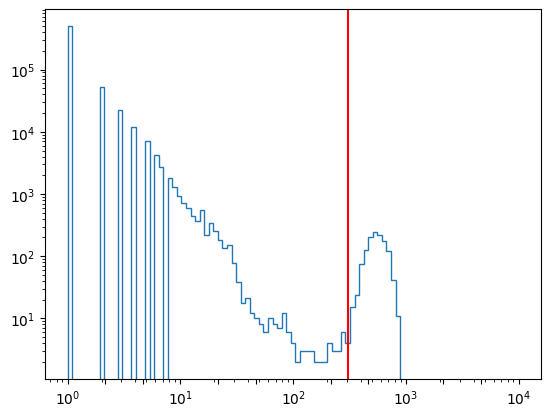

FRED3_8_S228


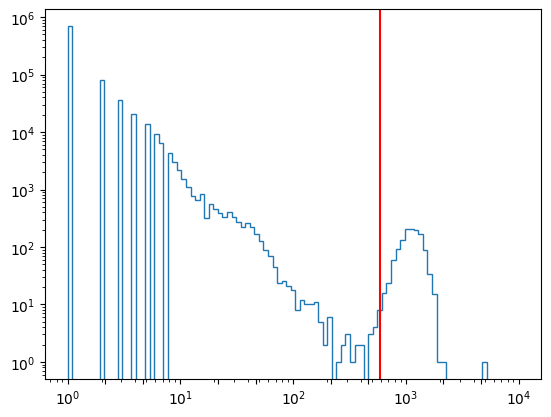

FRED3_9_S229


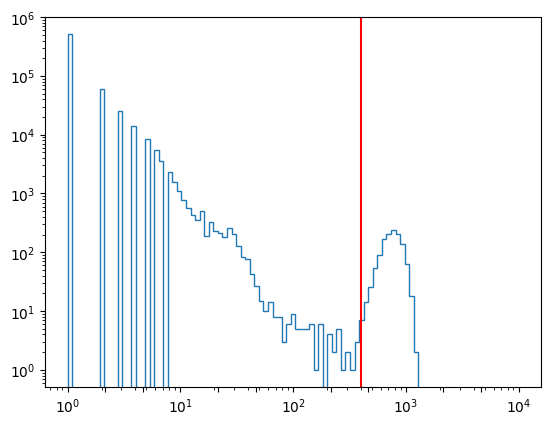

GATA2_Tile1_S78


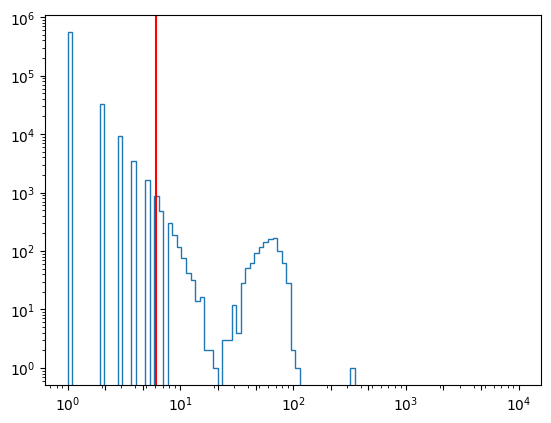

GATA2_Tile2_S79


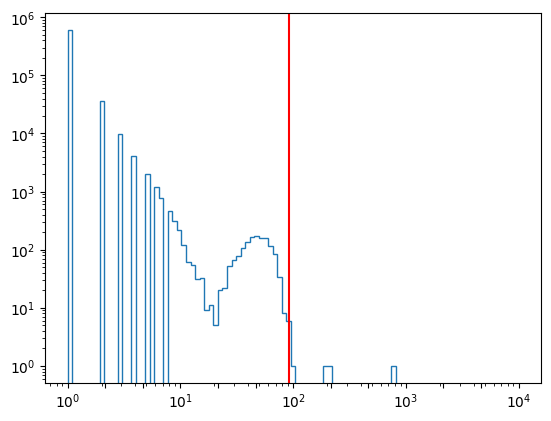

GATA2_Tile3_S80


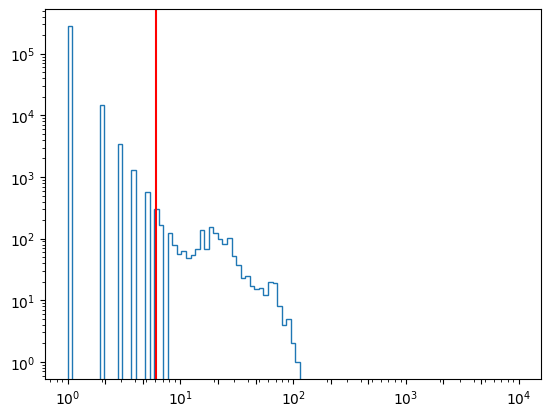

GATA2_Tile4_S81


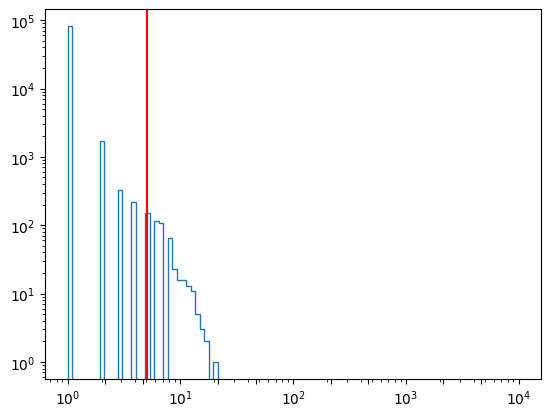

GATA2_Tile5_S82


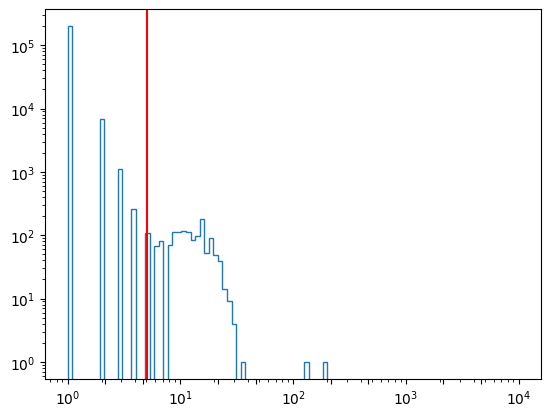

GATA2_Tile6_S83


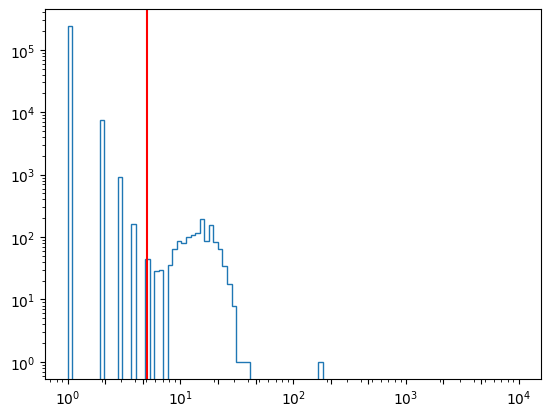

GATA2_Tile7_S84


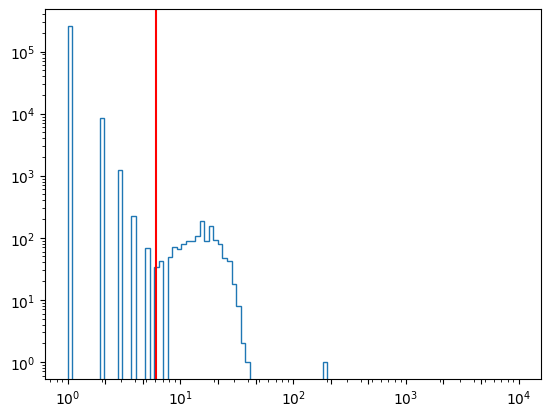

GATA2_Tile8_S85


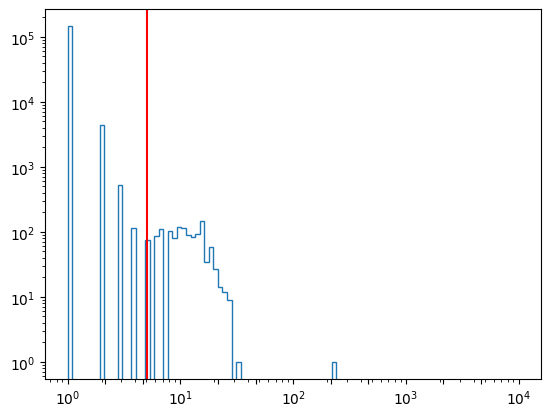

GATA2_Tile9_S86


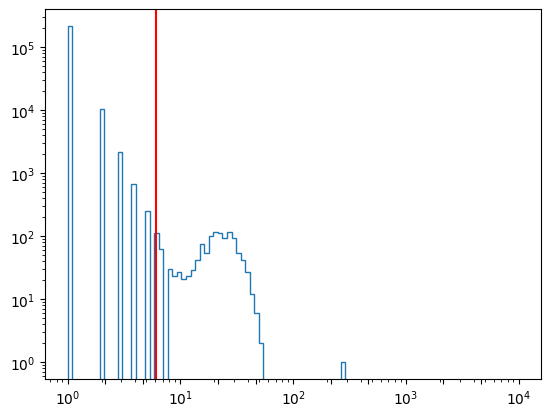

GRIA3_tile_lib_S15


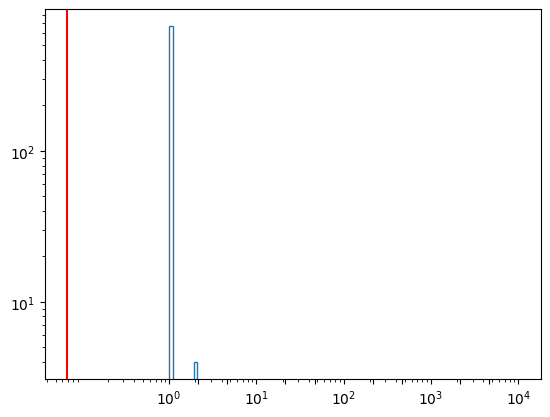

GRIN2A_tile_lib_S14


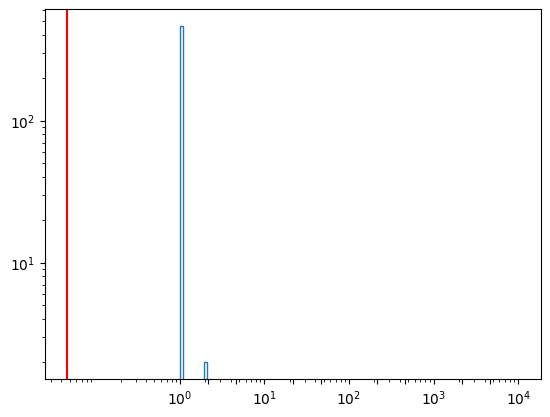

KRAS_block1_G12C_tile_lib_S7


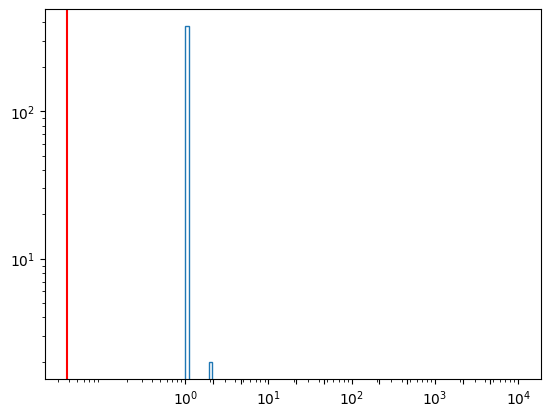

LMNA_tile_lib_S16


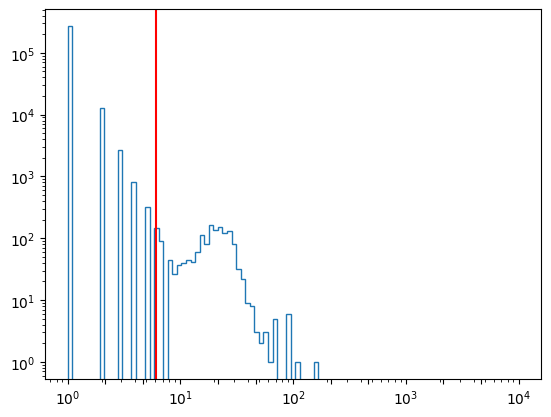

MRAS_block1_G22C_tile_lib_S5


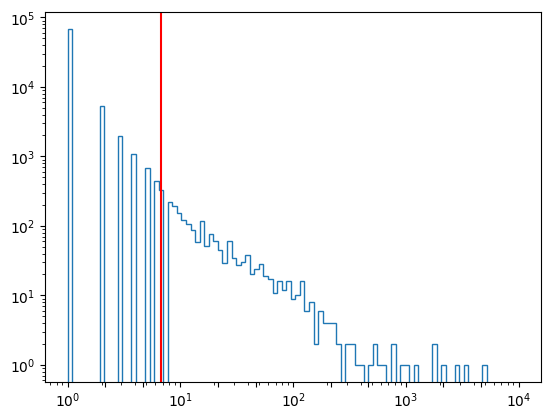

NHLRC1_Tile1_S87


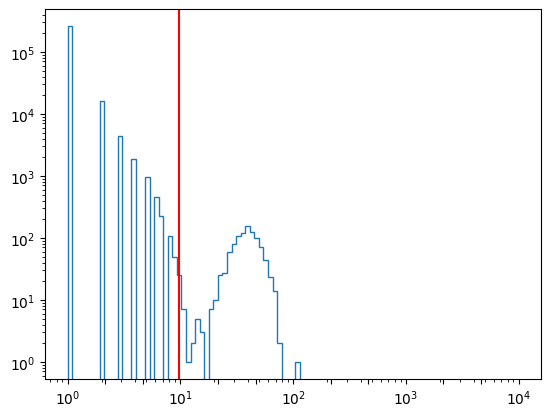

NHLRC1_Tile2_S88


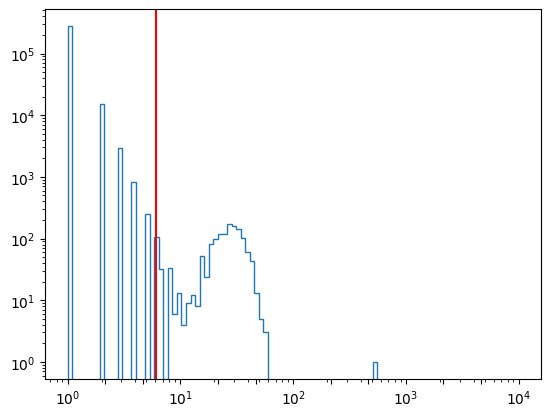

NHLRC1_Tile3_S89


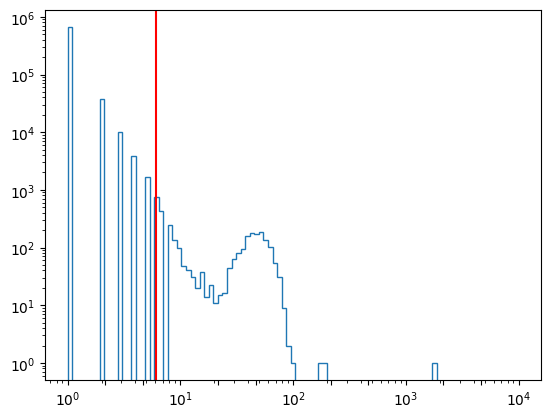

NHLRC1_Tile4_S90


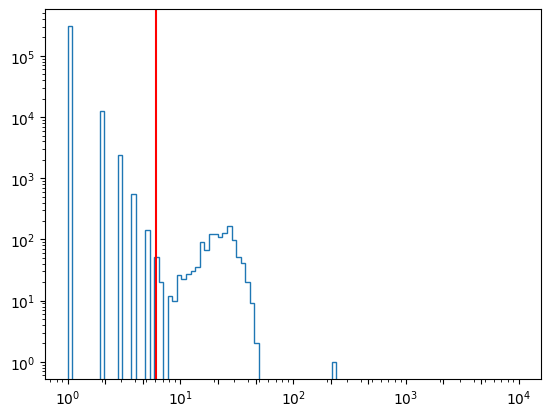

NHLRC1_Tile5_S91


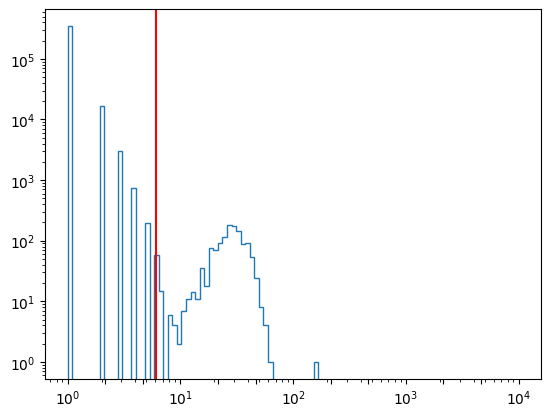

NHLRC1_Tile6_S92


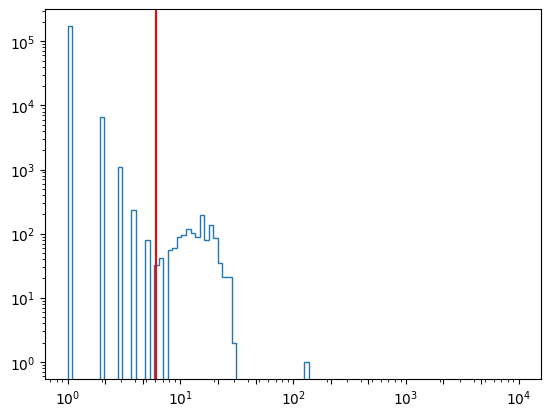

NHLRC1_Tile7_S93


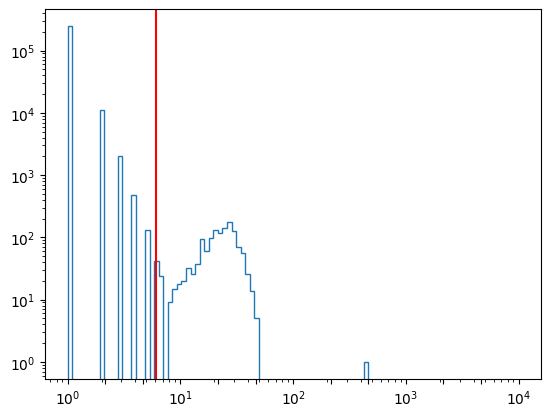

NHLRC1_Tile8_S94


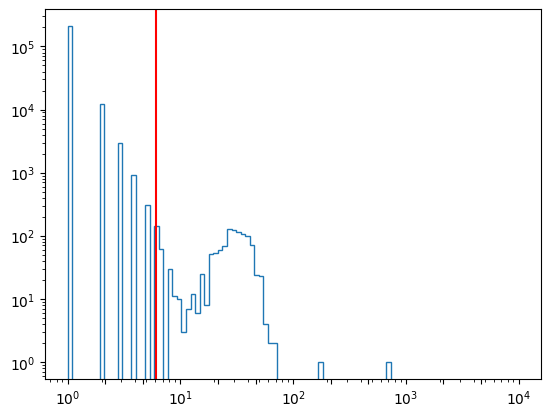

NRAS_Tile1_S95


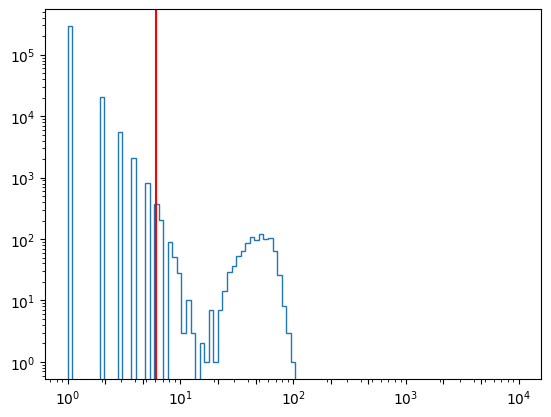

NRAS_Tile2_S96


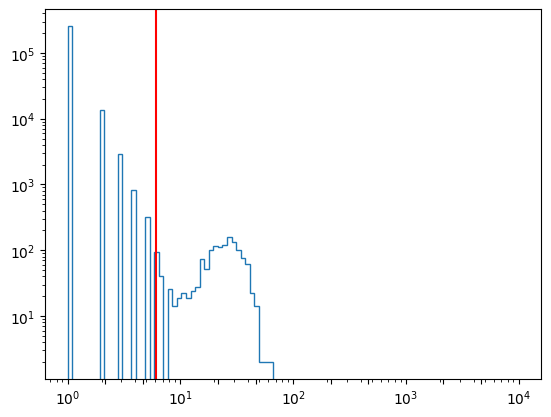

NRAS_Tile3_S97


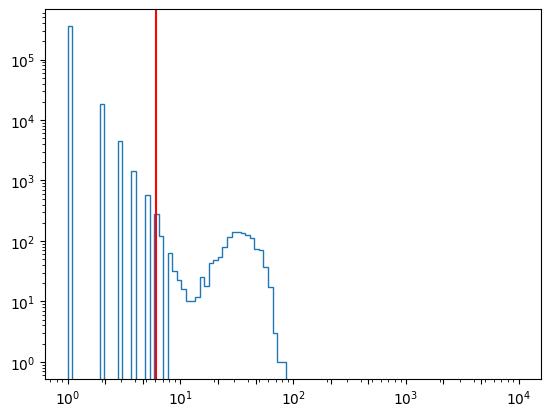

NRAS_Tile4_S98


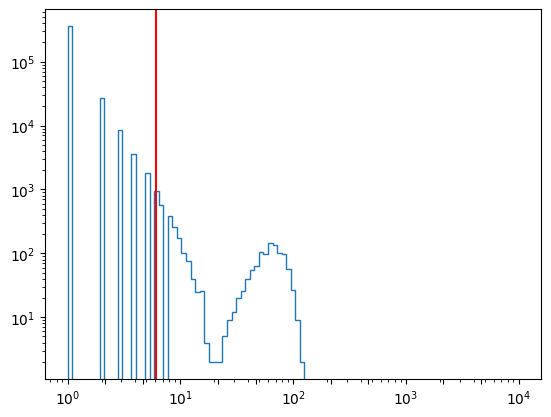

NRAS_block1_G12C_tile_lib_S6


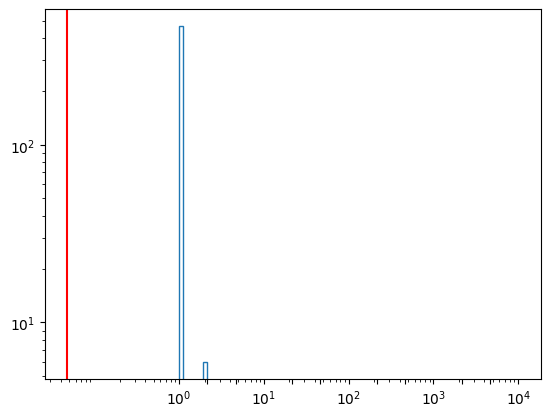

PRKAG2_Tile10_S108


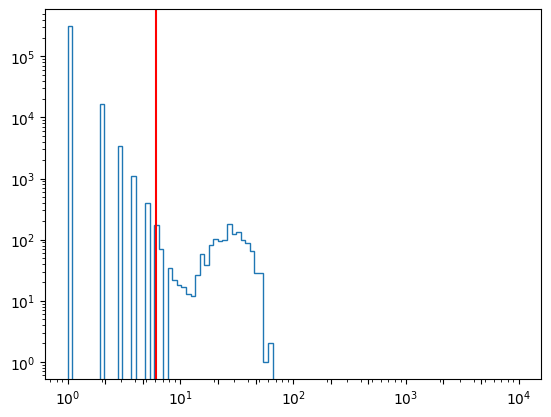

PRKAG2_Tile11_S109


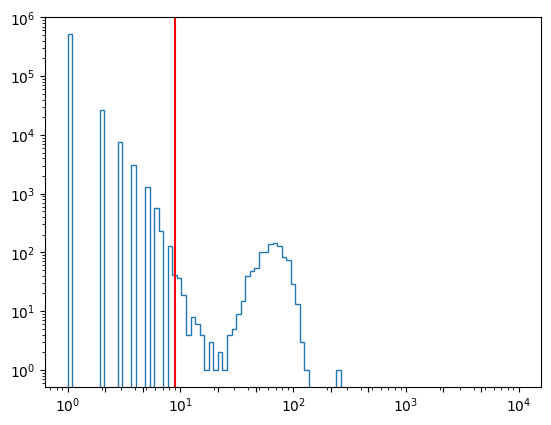

PRKAG2_Tile1_S99


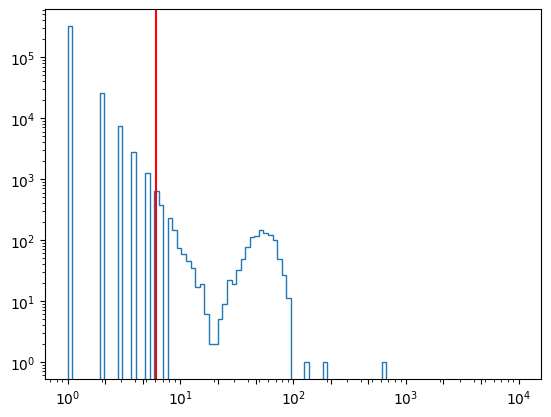

PRKAG2_Tile2_S100


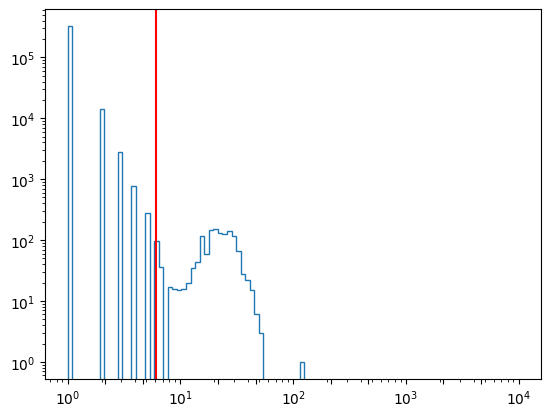

PRKAG2_Tile3_S101


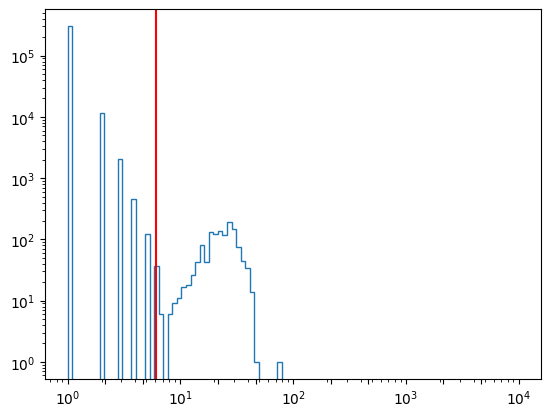

PRKAG2_Tile4_S102


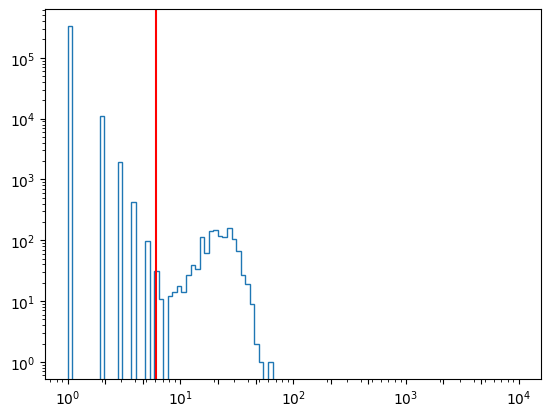

PRKAG2_Tile5_S103


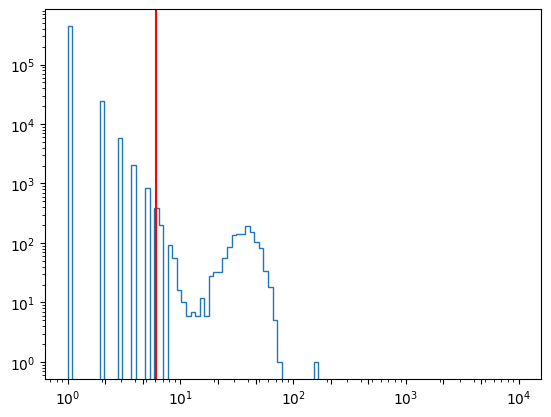

PRKAG2_Tile6_S104


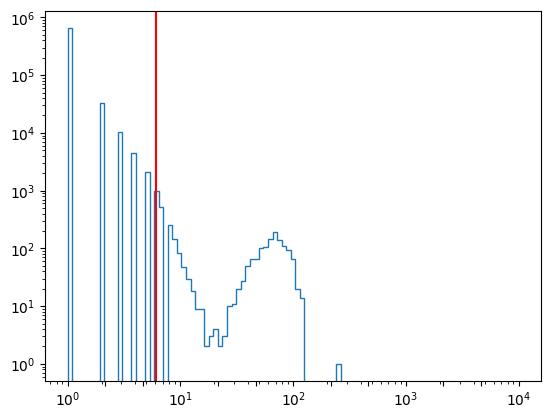

PRKAG2_Tile7_S105


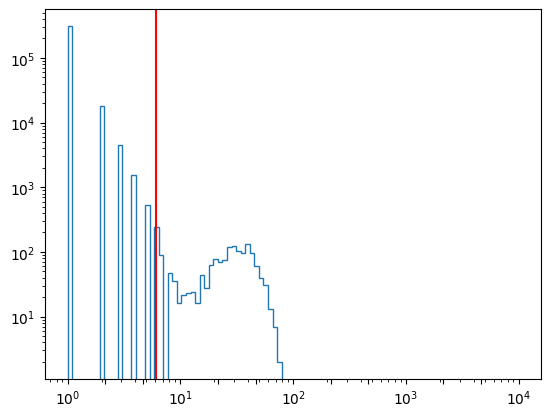

PRKAG2_Tile8_S106


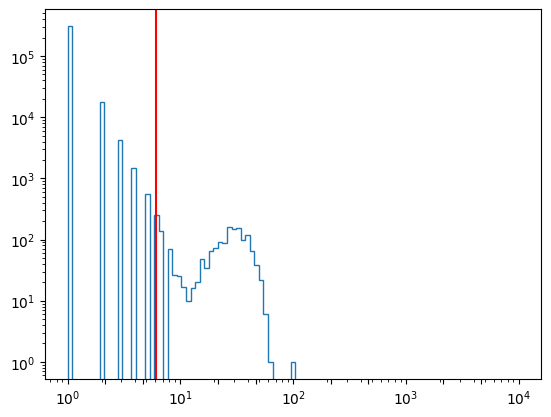

PRKAG2_Tile9_S107


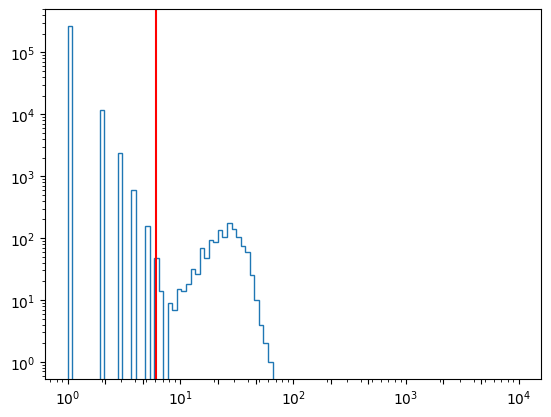

RAB11B_Tile1_S119


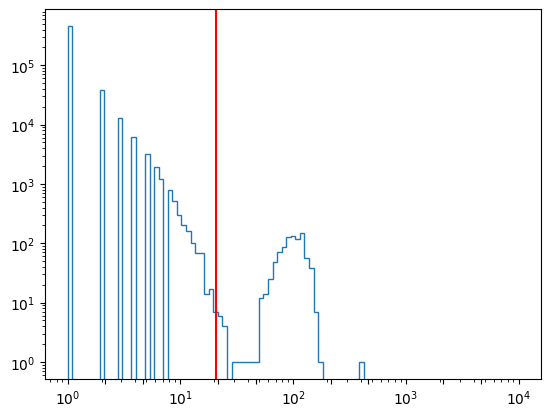

RAB11B_Tile2_S120


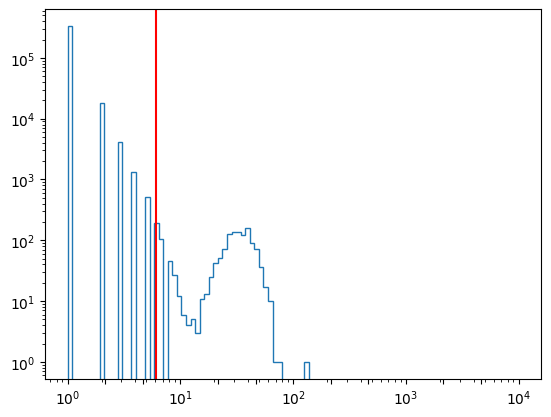

RAB11B_Tile3_S121


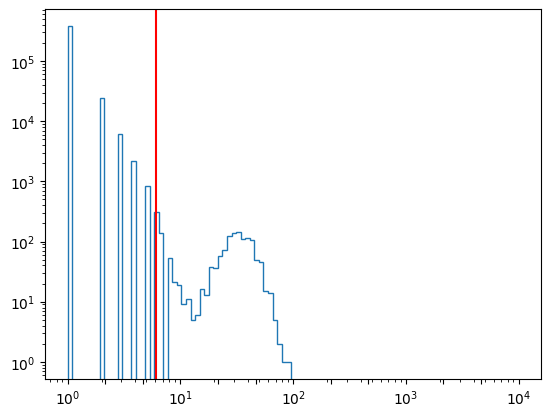

RAB11B_Tile4_S122


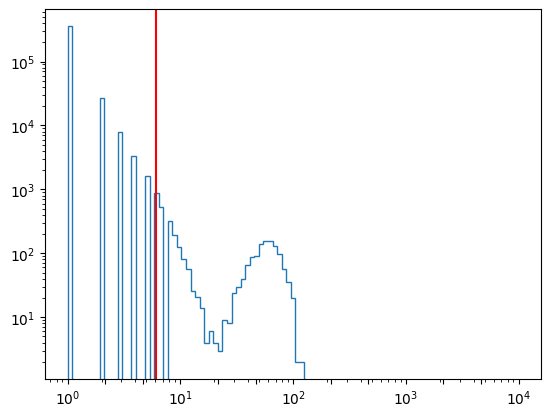

RAB11B_Tile5_S123


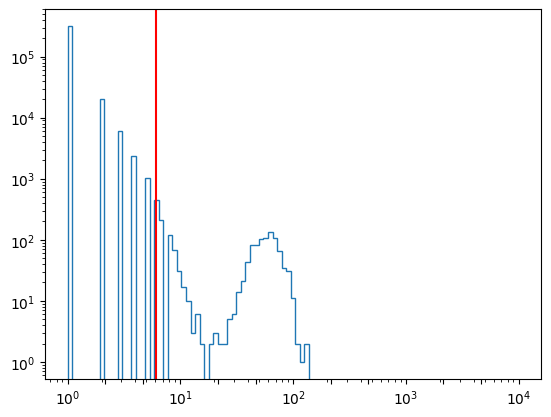

RAB18_Tile1_S124


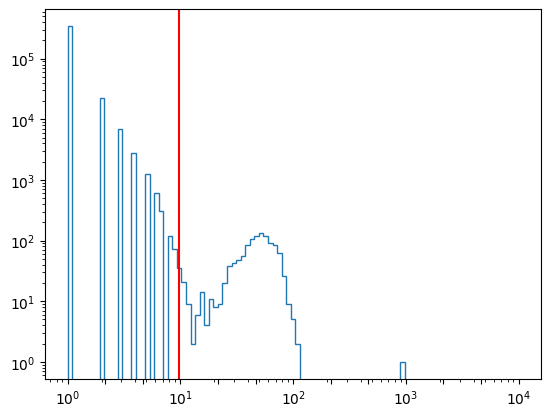

RAB18_Tile2_S125


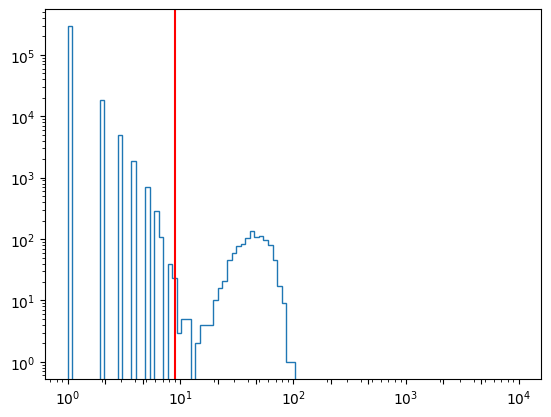

RAB18_Tile3_S126


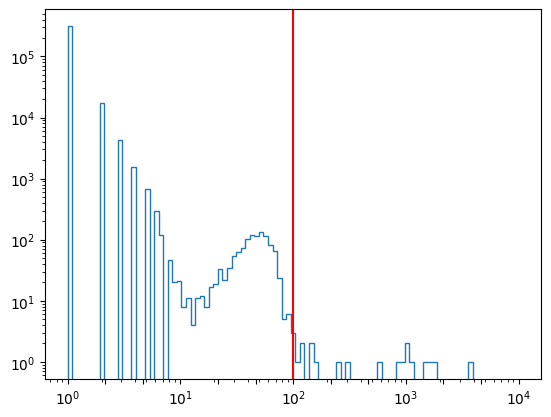

RAB18_Tile4_S127


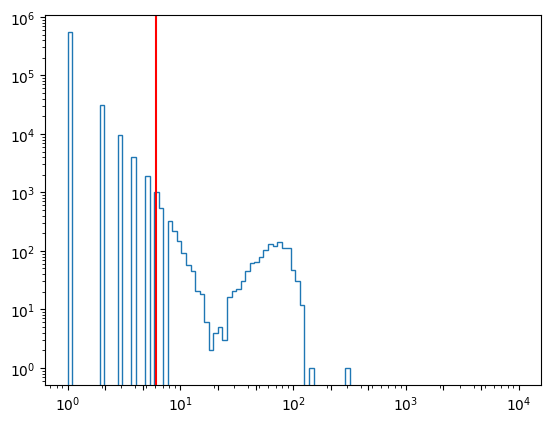

RAB18_Tile5_S128


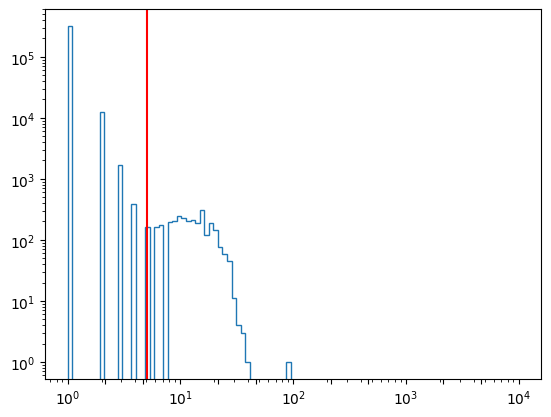

RAB1A_Tile1_S110


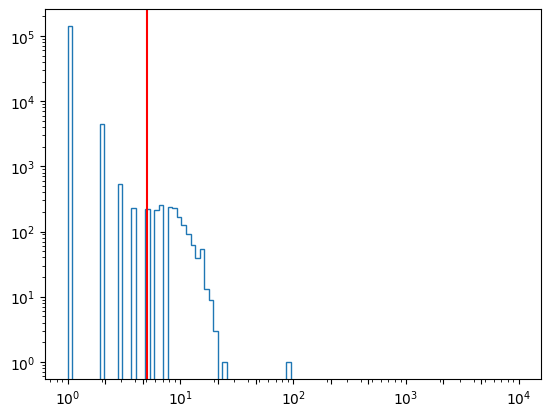

RAB1A_Tile2_S111


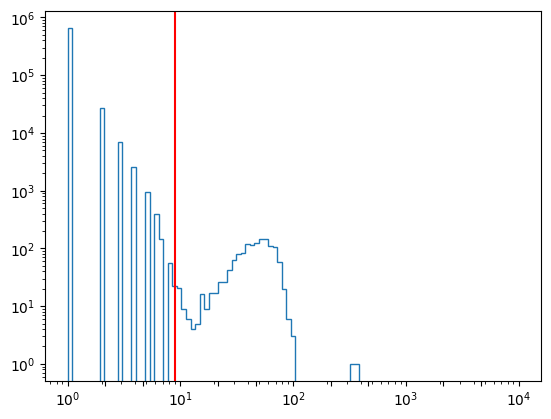

RAB1A_Tile3_S112


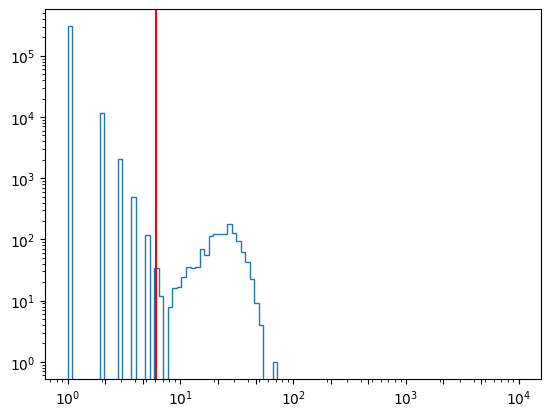

RAB1A_Tile4_S113


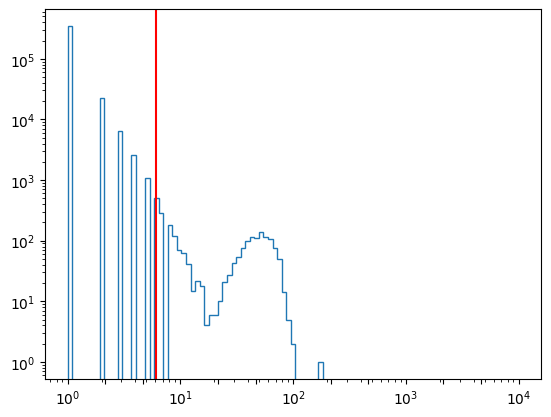

RAB27A_Tile1_S129


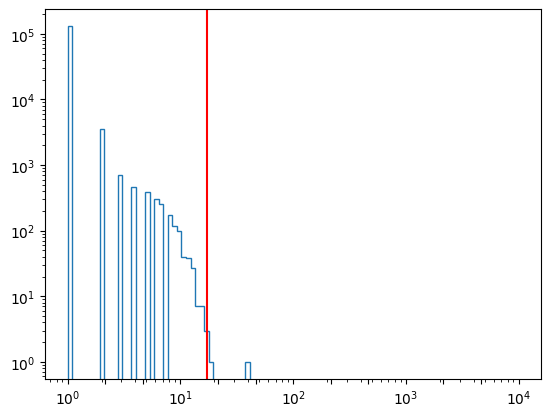

RAB27A_Tile2_S130


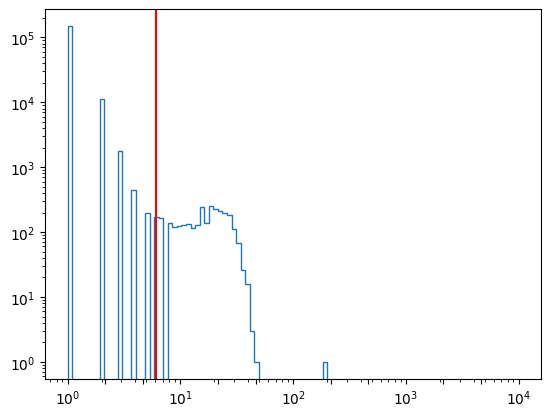

RAB27A_Tile3_S131


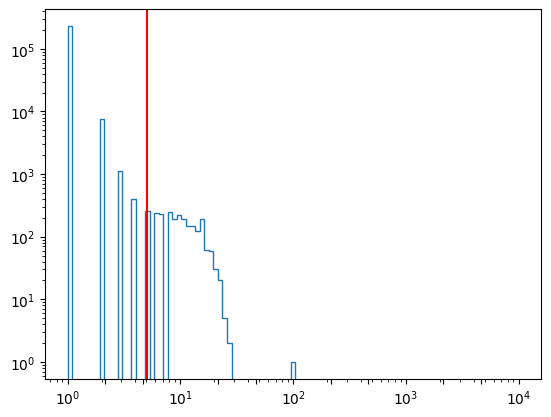

RAB27A_Tile4_S132


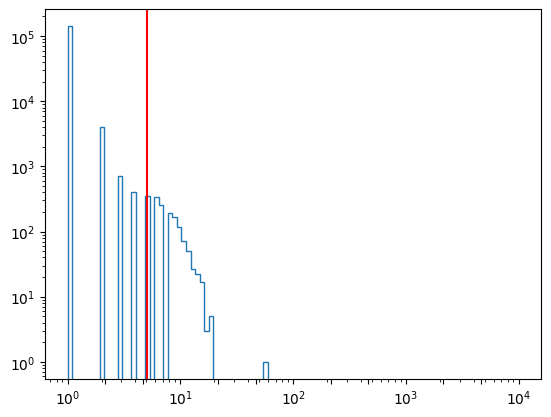

RAB27A_Tile5_S133


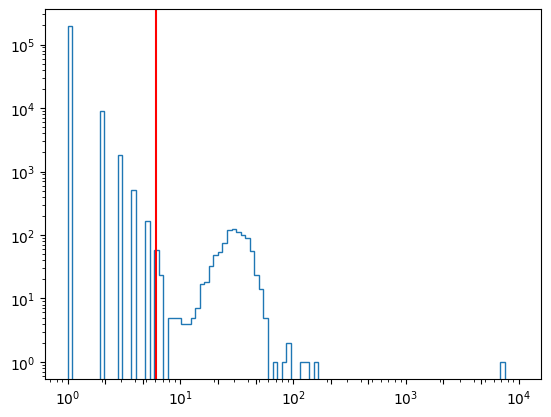

RAB7A_Tile1_S114


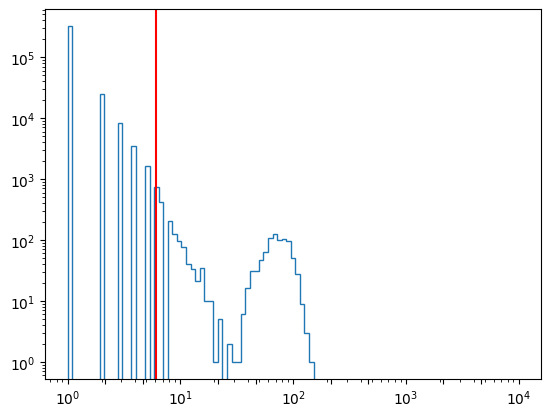

RAB7A_Tile2_S115


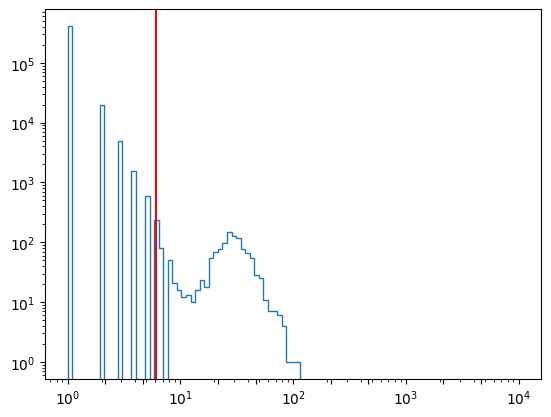

RAB7A_Tile3_S116


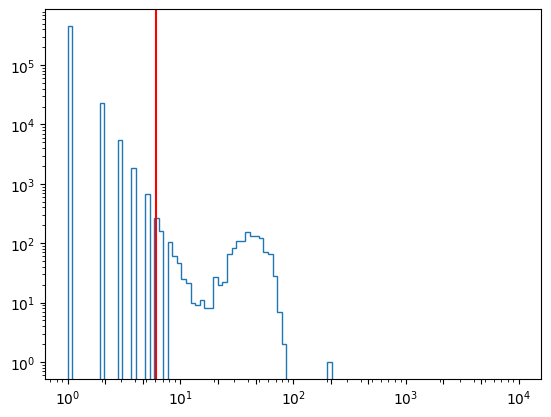

RAB7A_Tile4_S117


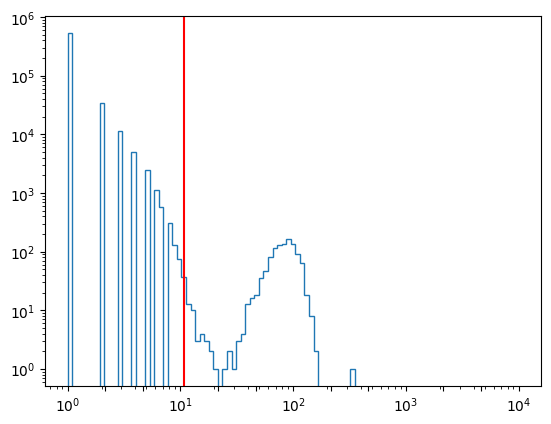

RAB7A_Tile5_S118


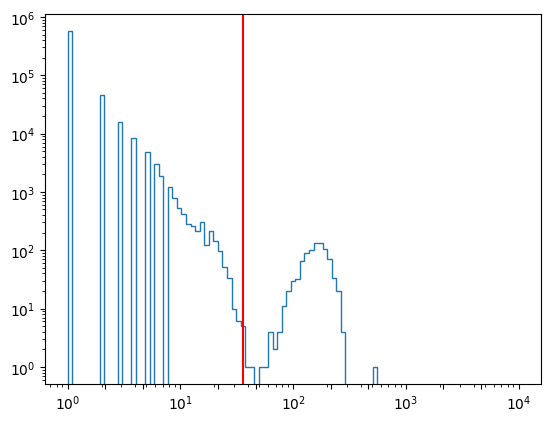

RAC1_block1_G12C_tile_lib_S3


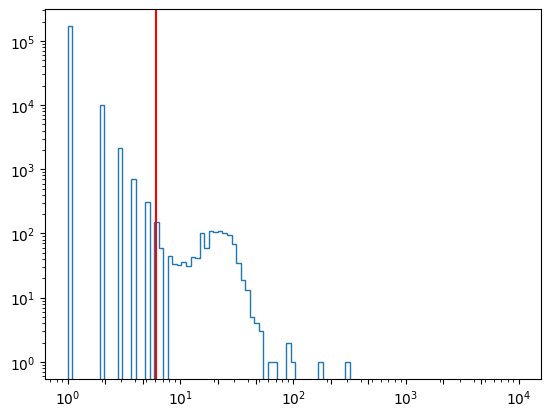

RALA_Tile1_S138


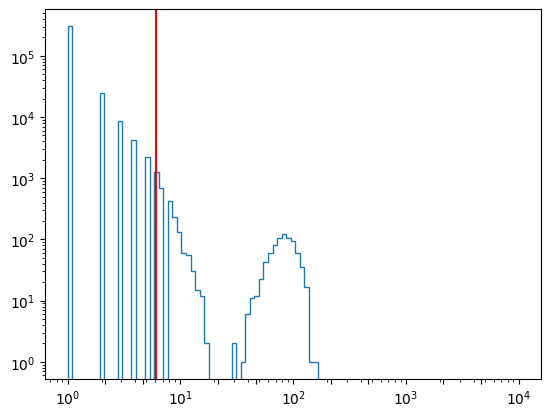

RALA_Tile2_S139


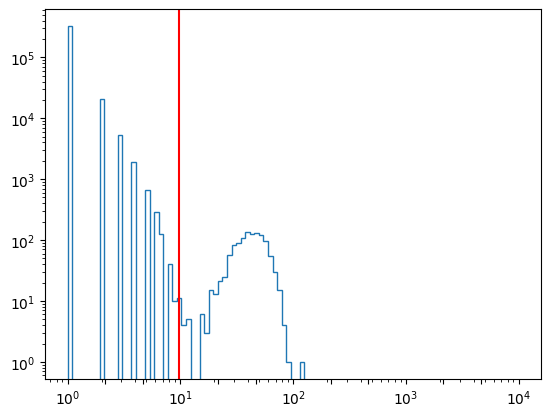

RALA_Tile3_S140


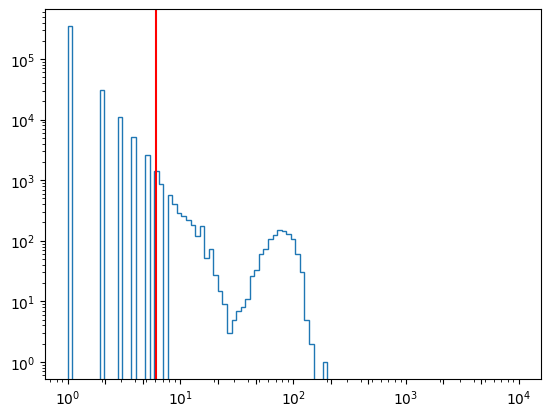

RALA_Tile4_S141


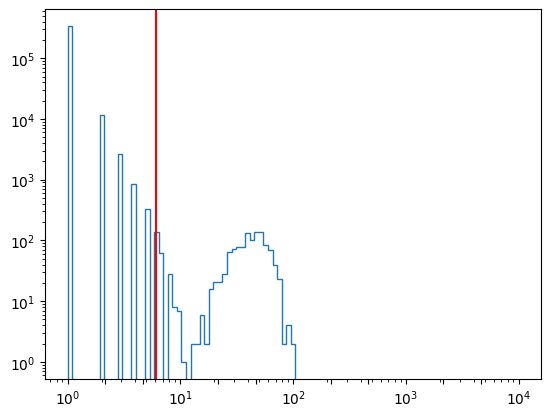

RALA_Tile5_S142


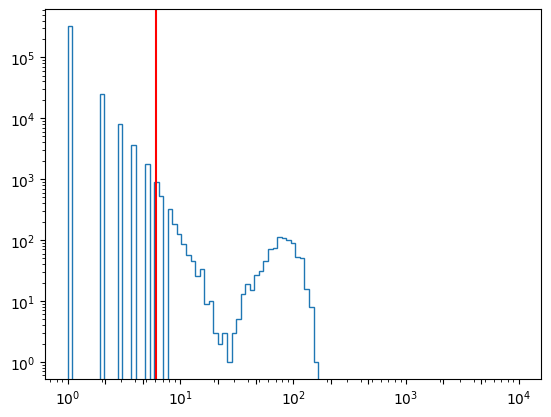

RAN_Tile1_S143


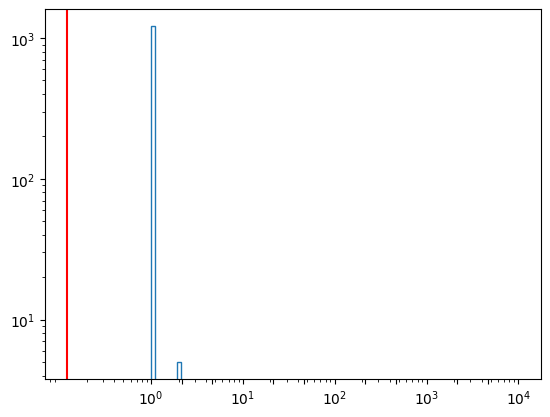

RAN_Tile2_S144


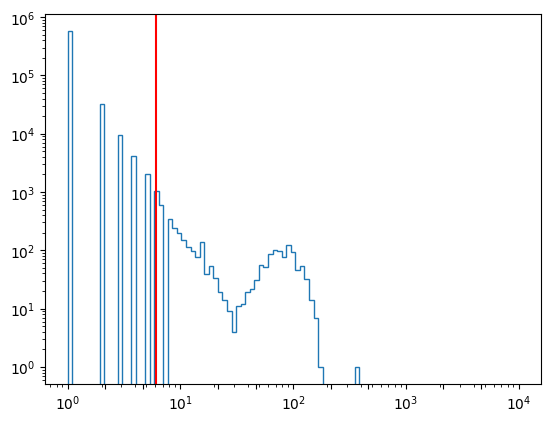

RAN_Tile3_S145


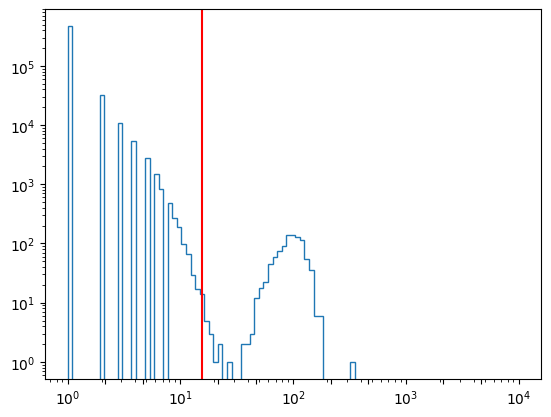

RAN_Tile4_S146


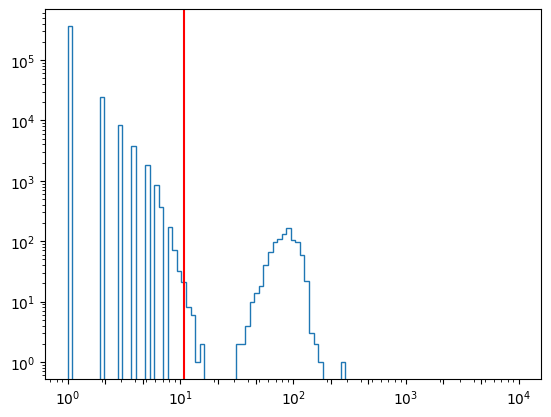

RAN_Tile5_S147


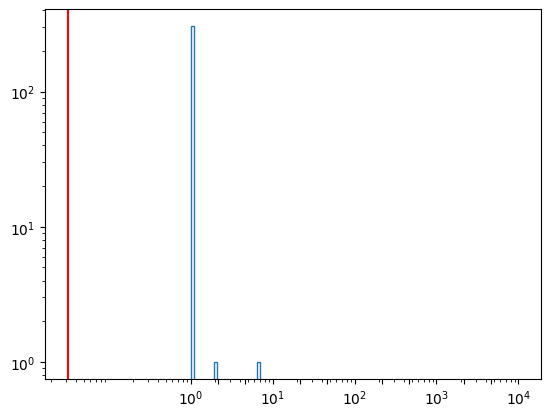

RAN_Tile6_S148


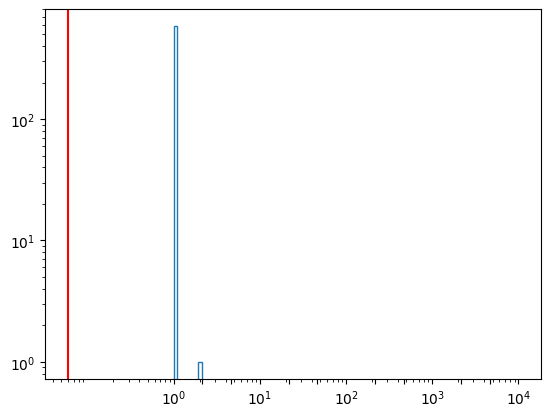

RAP1a_Tile1_S149


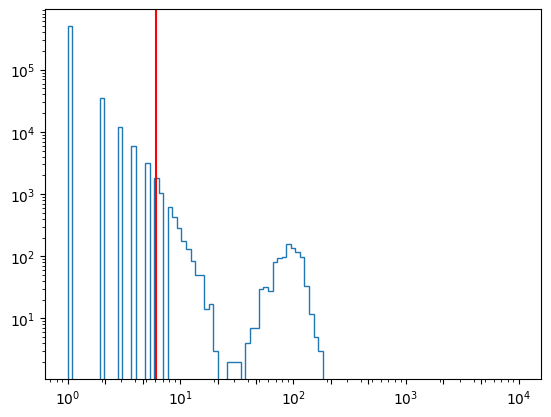

RAP1a_Tile2_S150


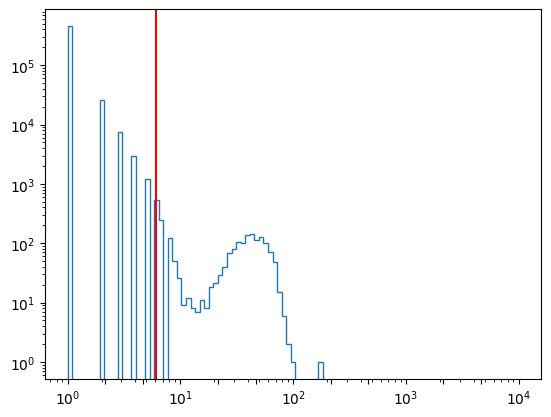

RAP1a_Tile3_S151


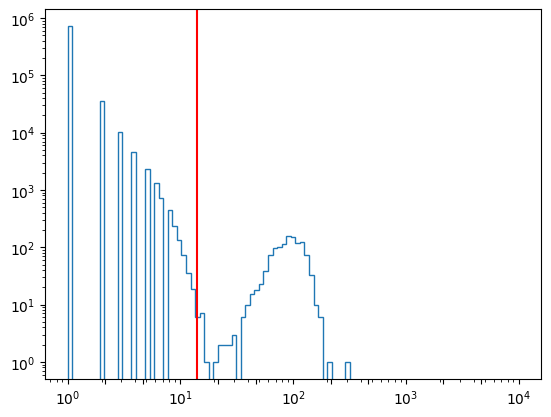

RAP1a_Tile4_S152


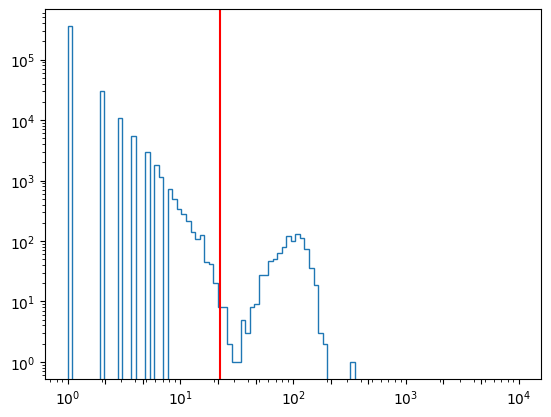

RHEB_Tile1_S153


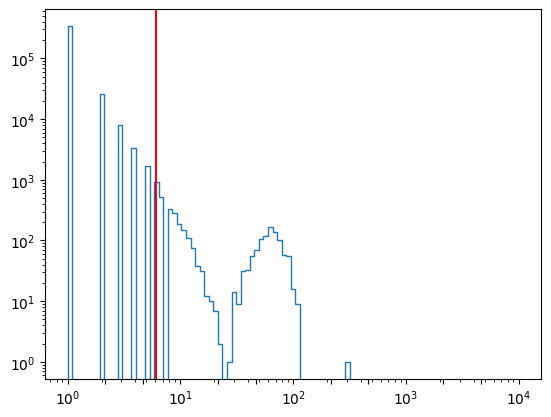

RHEB_Tile2_S154


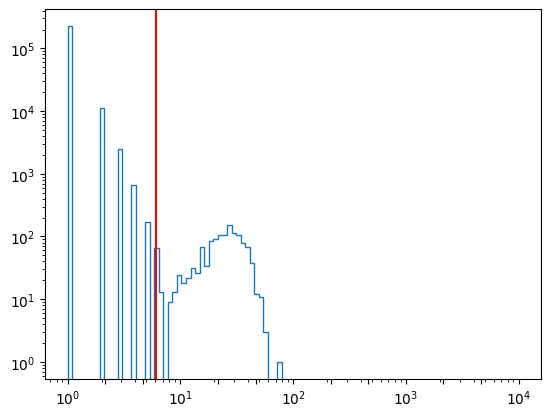

RHEB_Tile3_S155


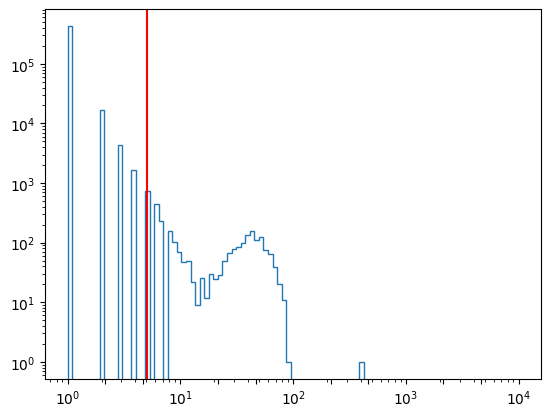

RHEB_Tile4_S156


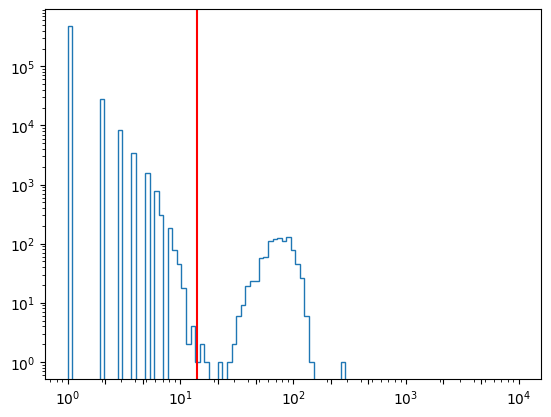

RHOA_Tile1_S157


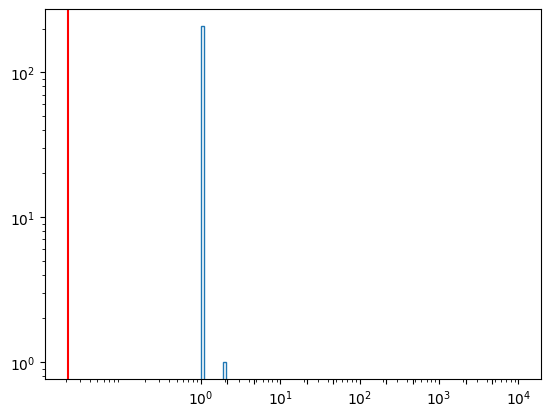

RHOA_Tile2_S158


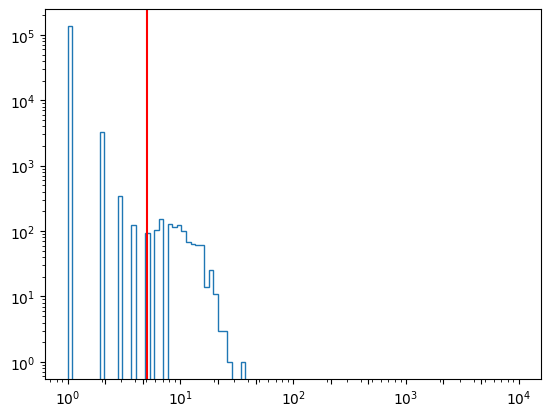

RHOA_Tile3_S159


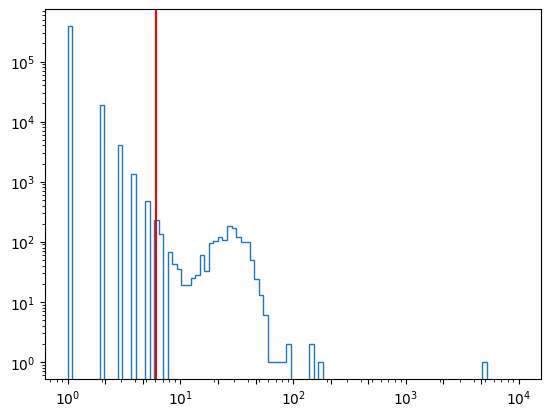

RHOA_Tile4_S160


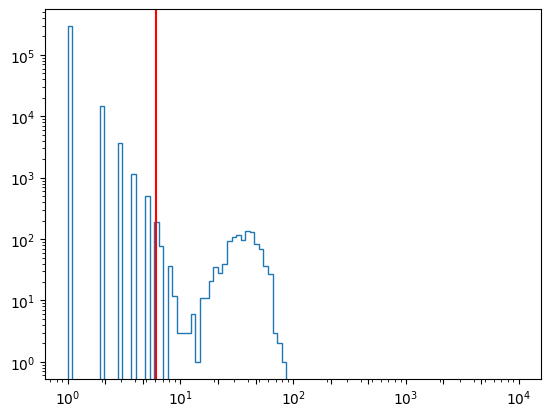

RIT_Tile1_S161


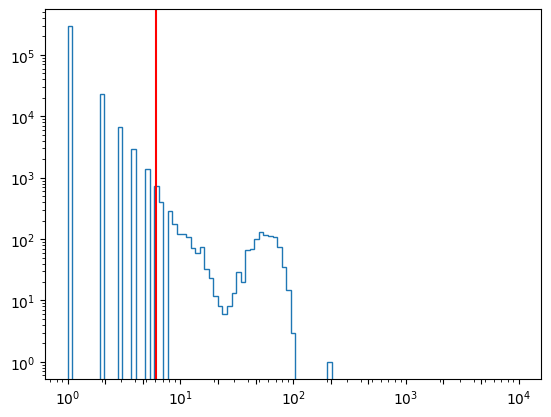

RIT_Tile2_S162


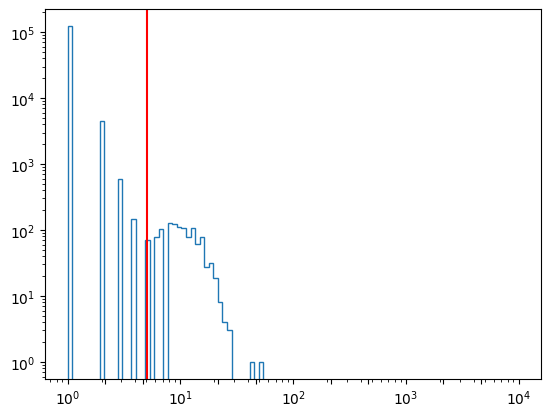

RIT_Tile3_S163


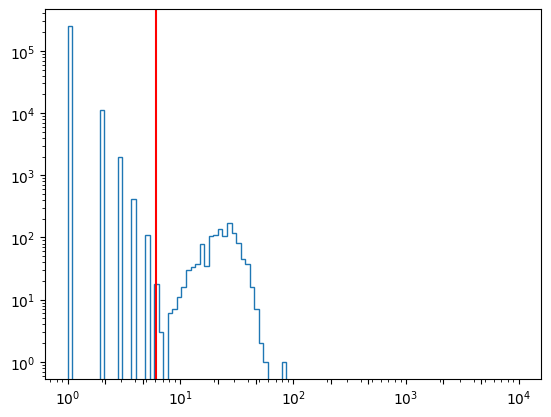

RIT_Tile4_S164


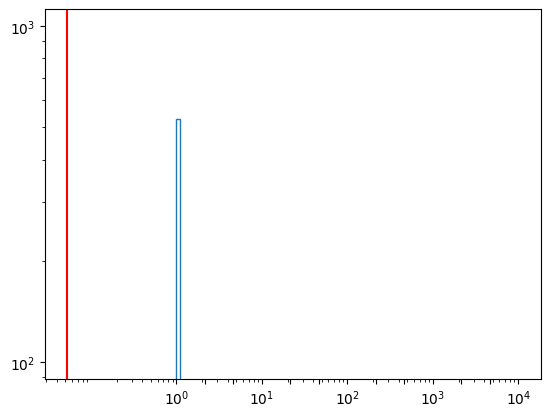

RIT_Tile5_S165


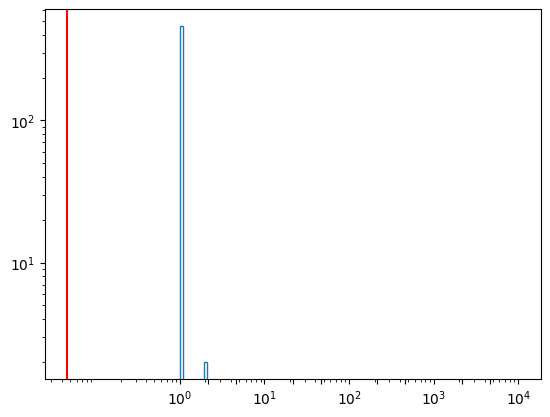

RIT_block1_G30C_tile_lib_S4


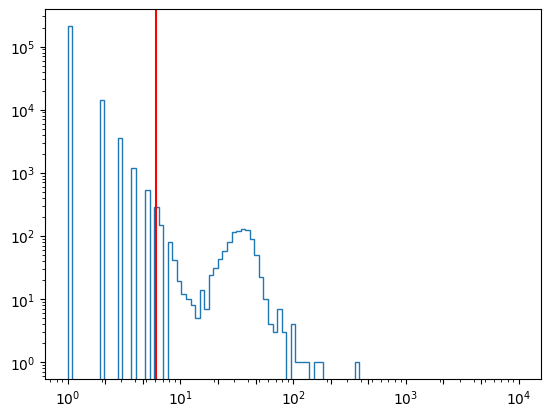

RUNX1_Tile1_S166


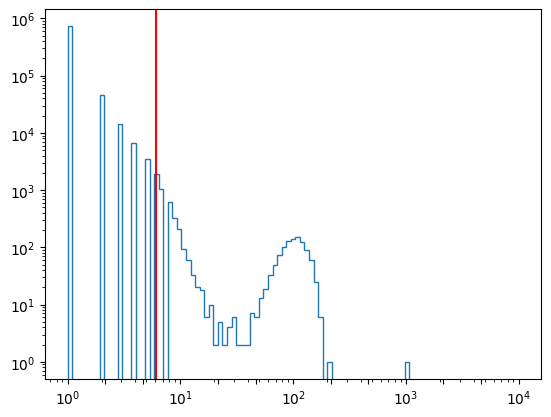

RUNX1_Tile2_S167


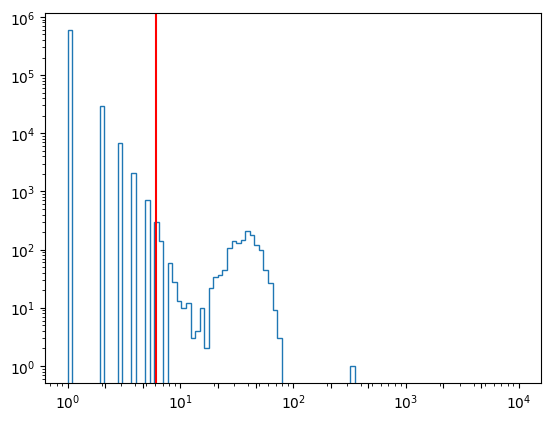

RUNX1_Tile3_S168


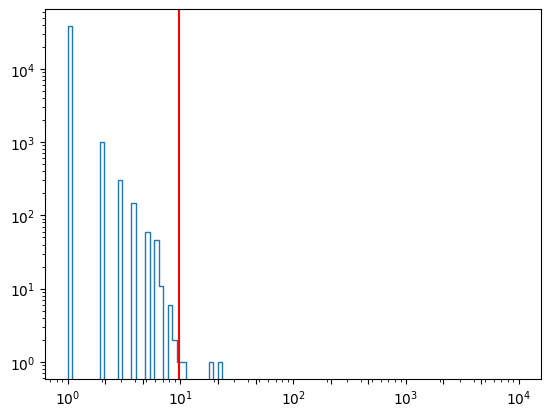

RUNX1_Tile4_S169


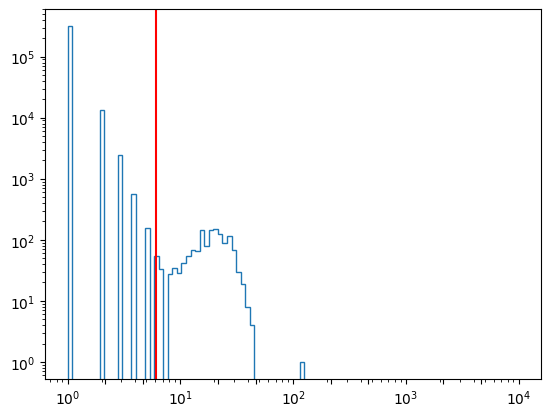

RUNX1_Tile5_S170


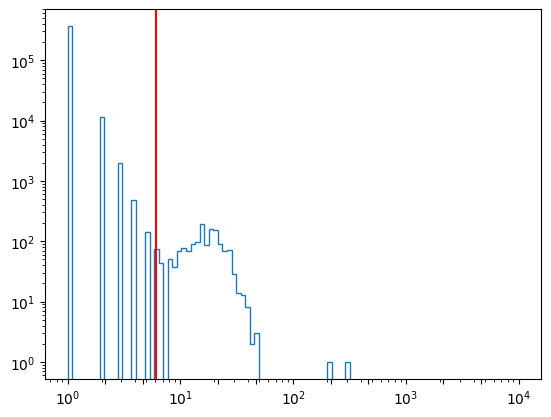

RUNX1_Tile6_S171


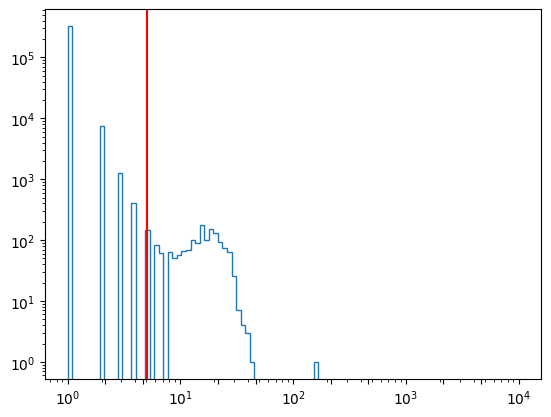

RUNX1_Tile7_S172


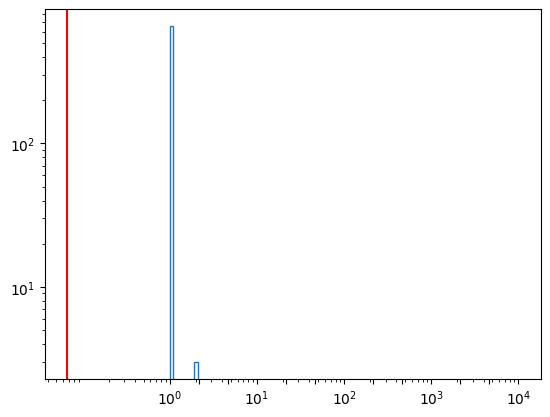

RUNX1_Tile8_S173


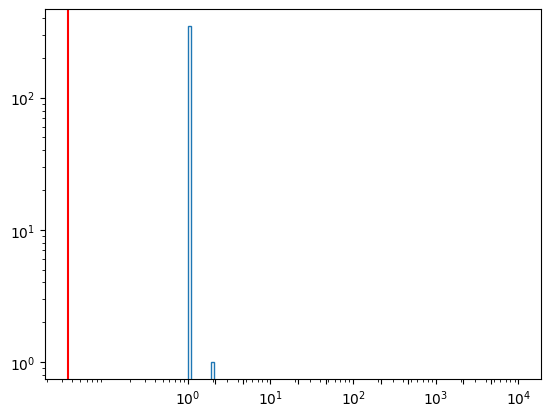

RUNX1_Tile9_S174


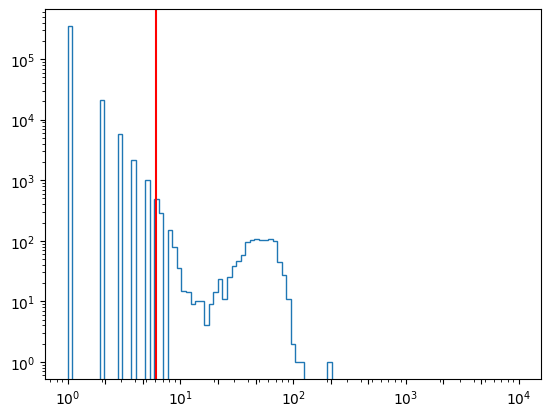

Rac1_Tile1_S134


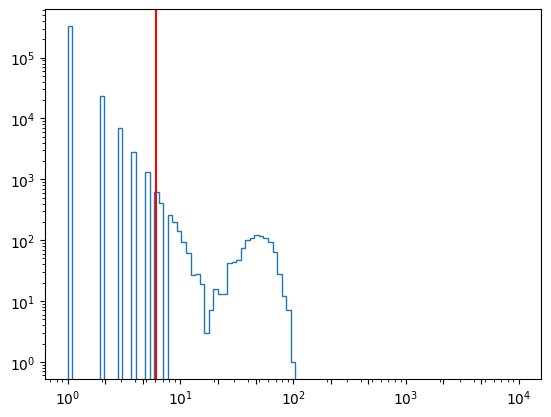

Rac1_Tile2_S135


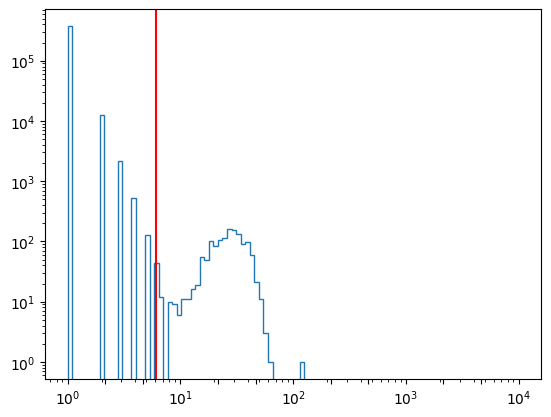

Rac1_Tile3_S136


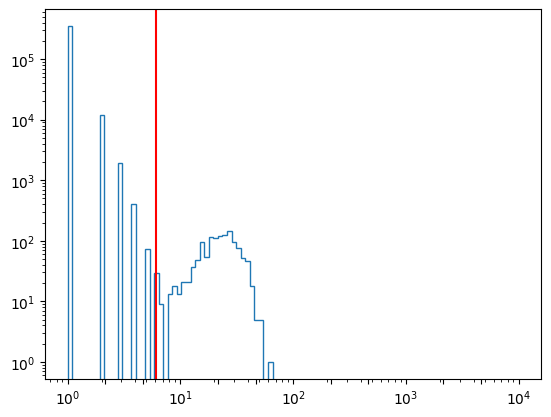

Rac1_Tile4_S137


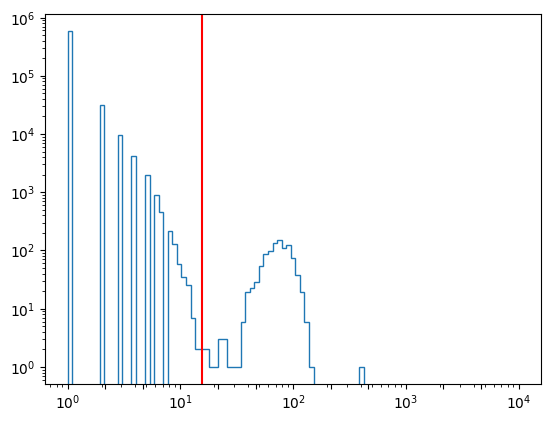

SLC6A8_tile1_lib_S1


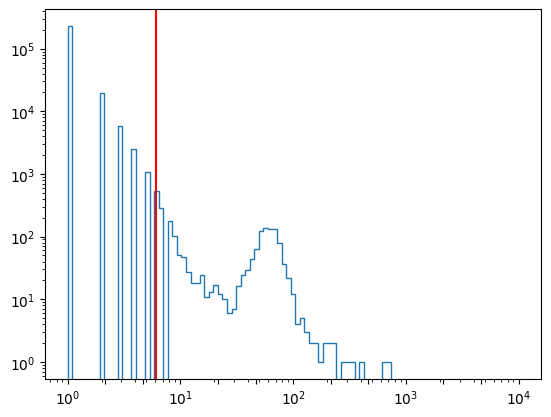

SLC6A8_tile2_lib_S2


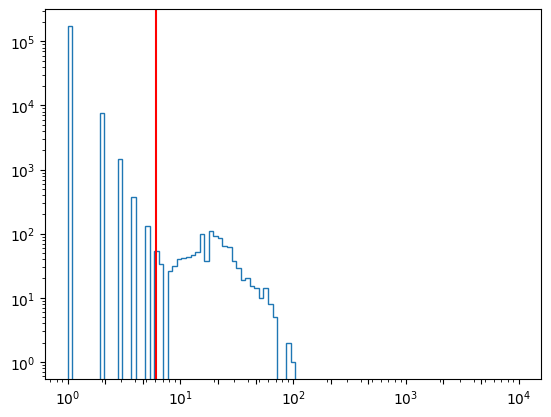

SMAD4_Tile10_S184


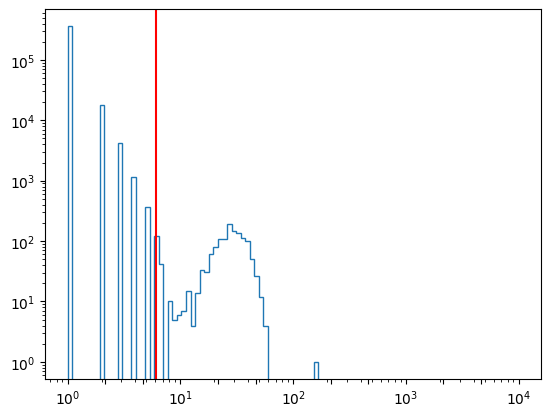

SMAD4_Tile11_S185


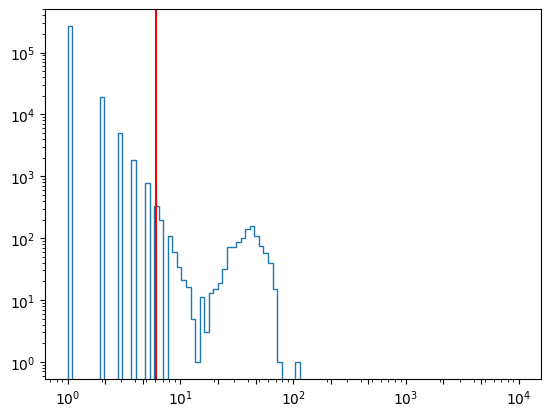

SMAD4_Tile1_S175


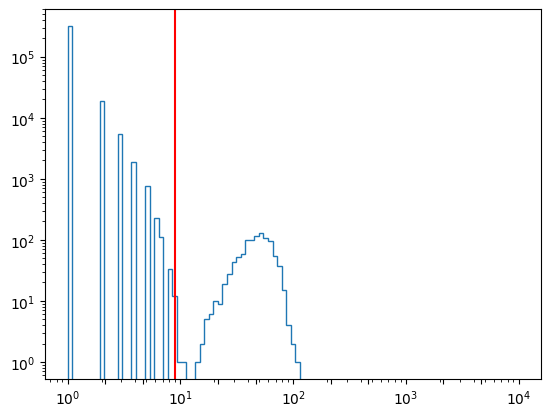

SMAD4_Tile2_S176


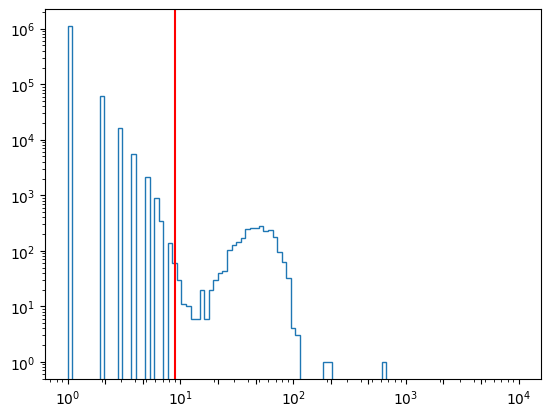

SMAD4_Tile3_S177


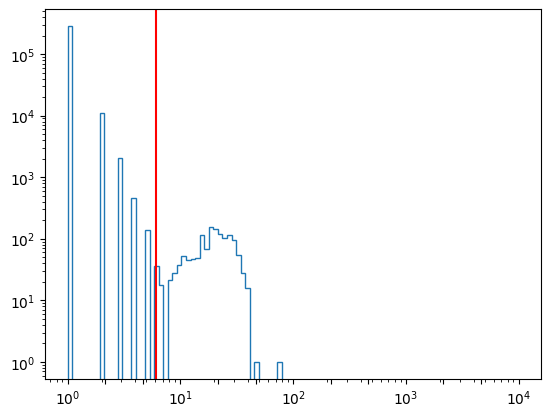

SMAD4_Tile4_S178


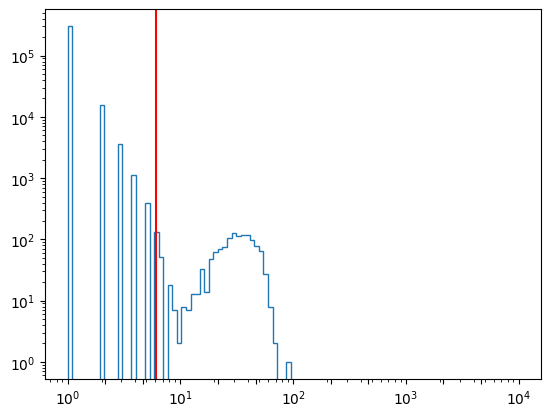

SMAD4_Tile5_S179


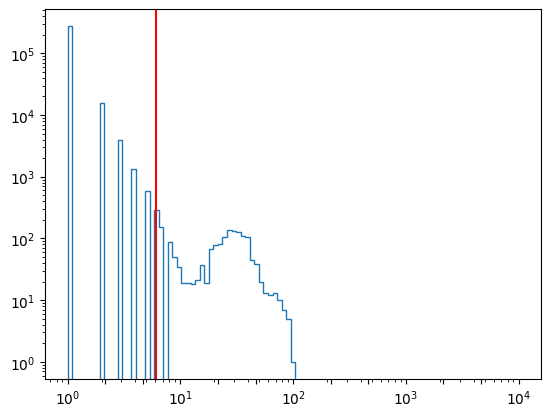

SMAD4_Tile6_S180


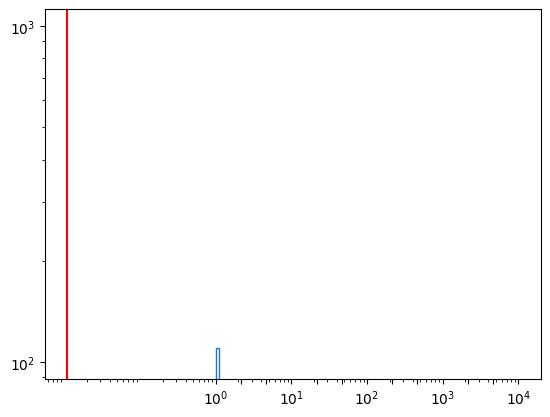

SMAD4_Tile7_S181


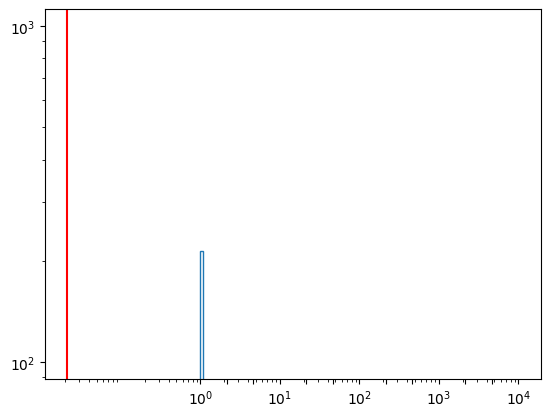

SMAD4_Tile8_S182


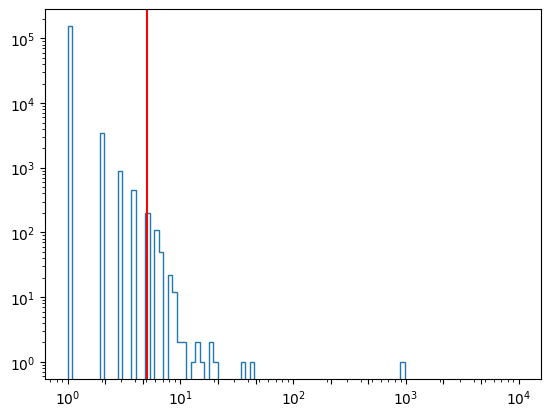

SMAD4_Tile9_S183


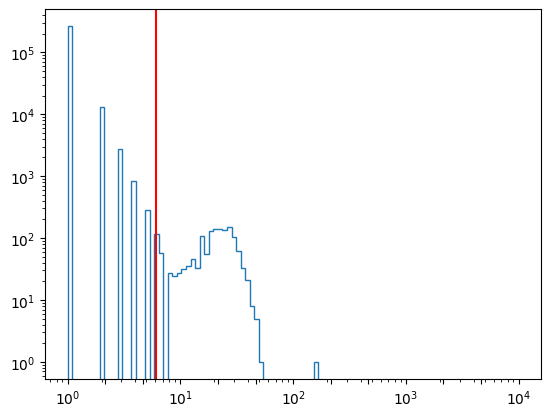

SMS_Tile1_S186


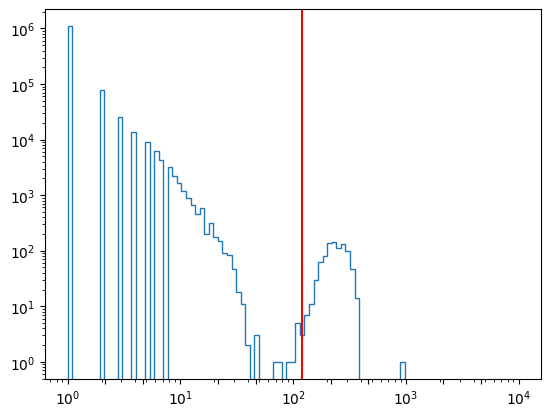

SMS_Tile2_S187


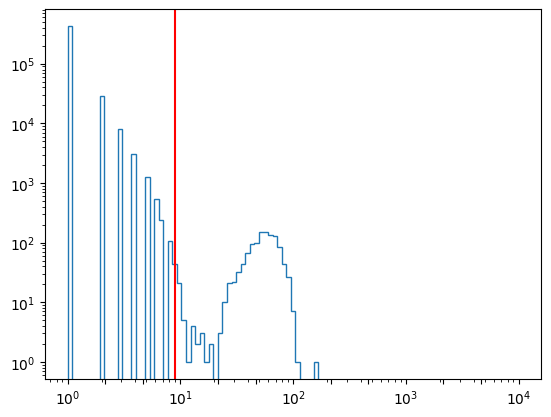

SMS_Tile3_S188


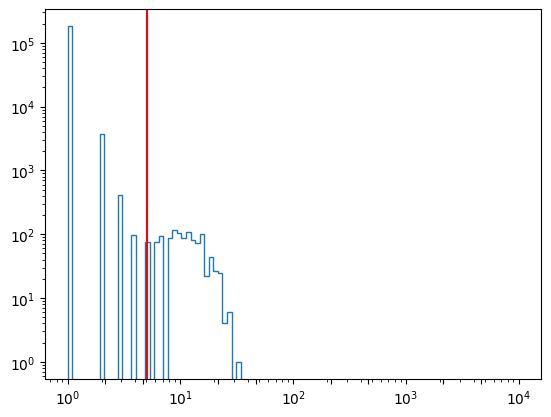

SMS_Tile4_S189


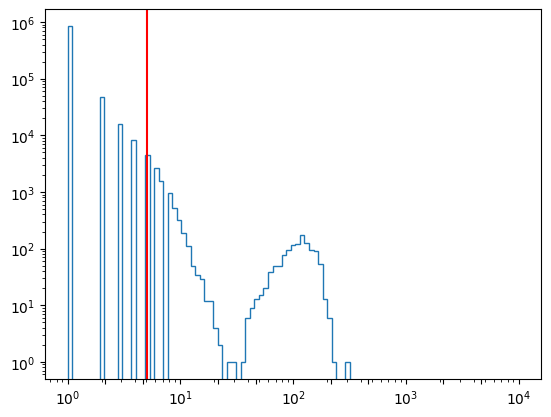

SMS_Tile5_S190


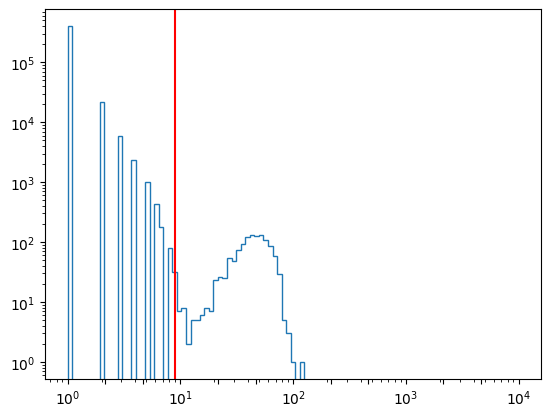

SMS_Tile6_S191


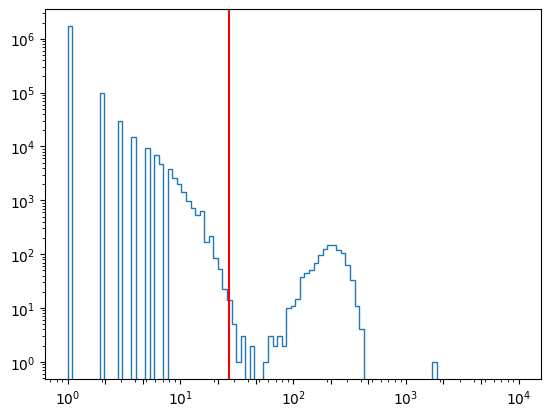

SMS_Tile7_S192


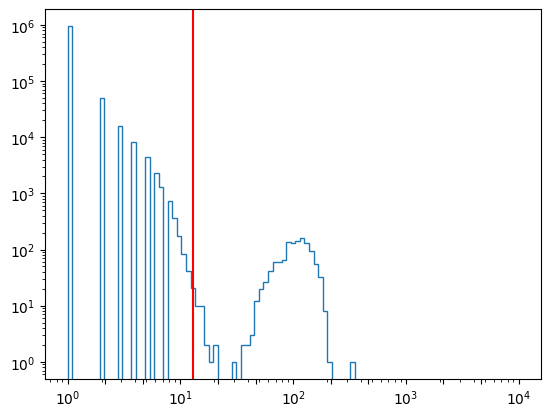

SMS_Tile8_S193


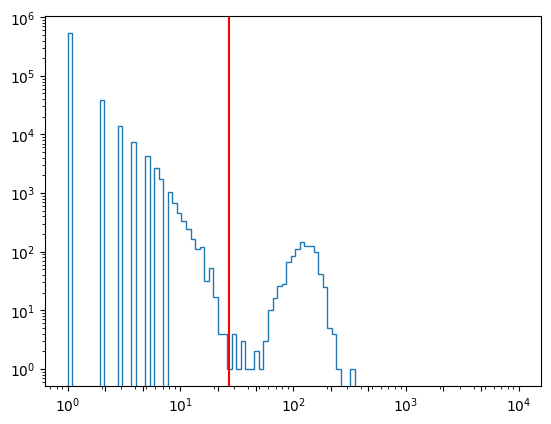

STK11_Tile10_S203


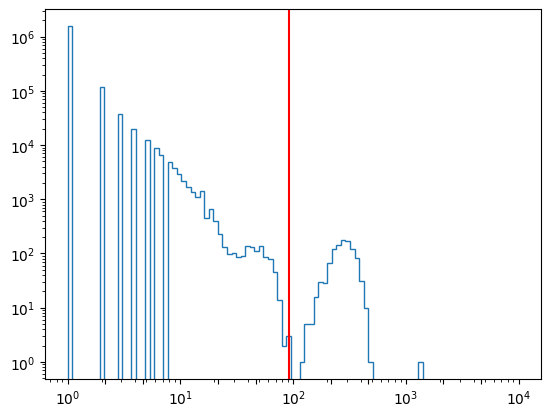

STK11_Tile11_S204


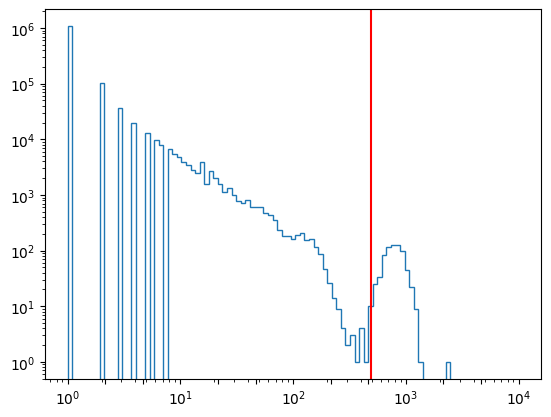

STK11_Tile1_S194


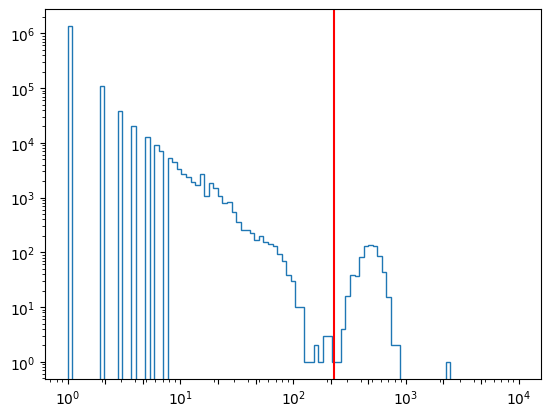

STK11_Tile2_S195


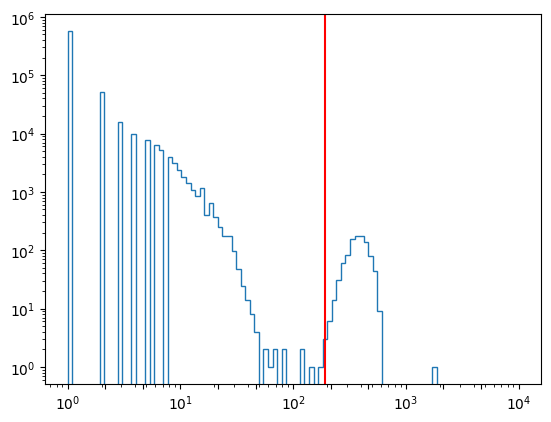

STK11_Tile3_S196


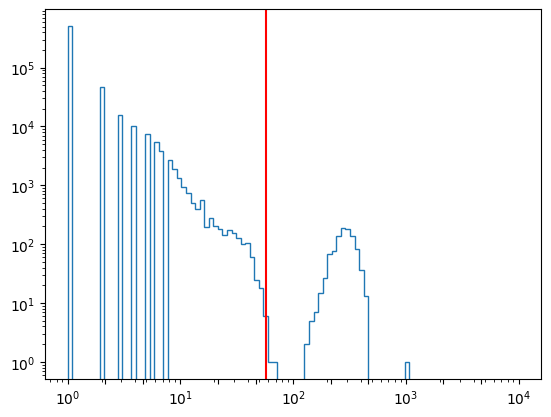

STK11_Tile4_S197


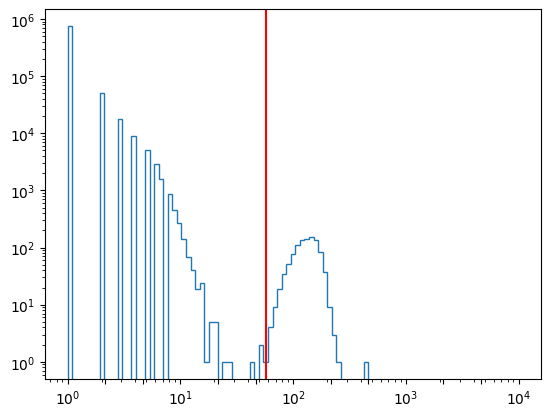

STK11_Tile5_S198


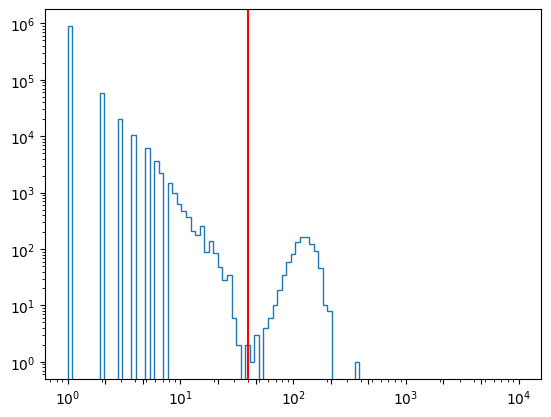

STK11_Tile6_S199


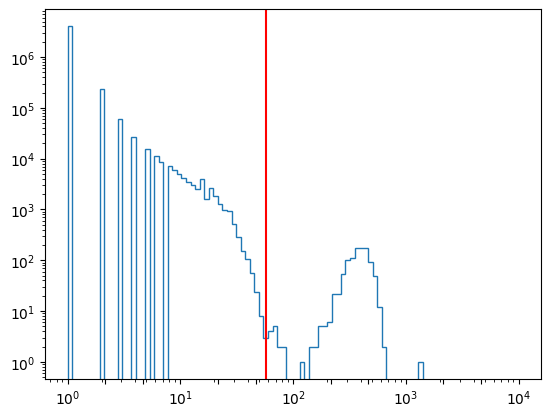

STK11_Tile7_S200


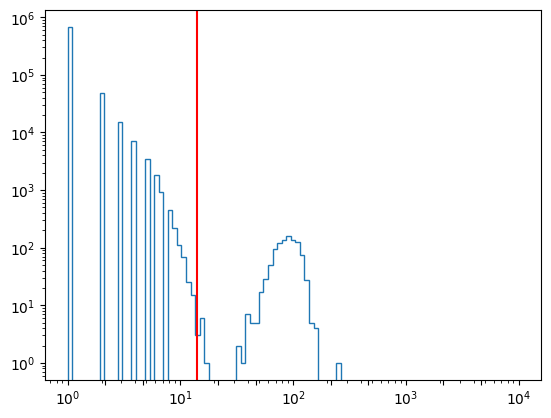

STK11_Tile8_S201


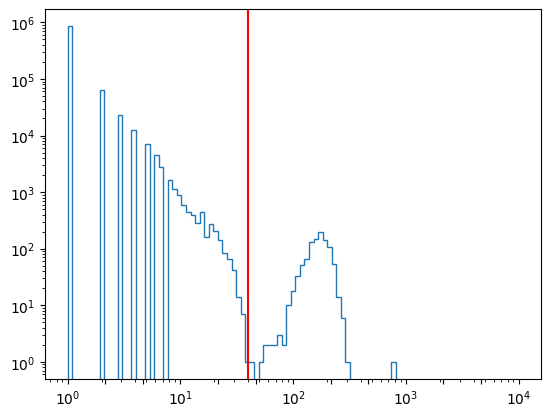

STK11_Tile9_S202


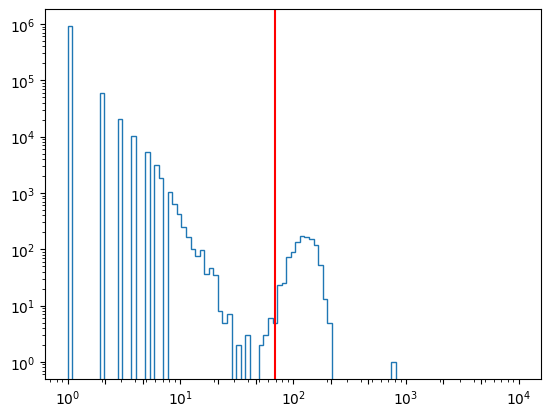

SUFU_Tile10_S214


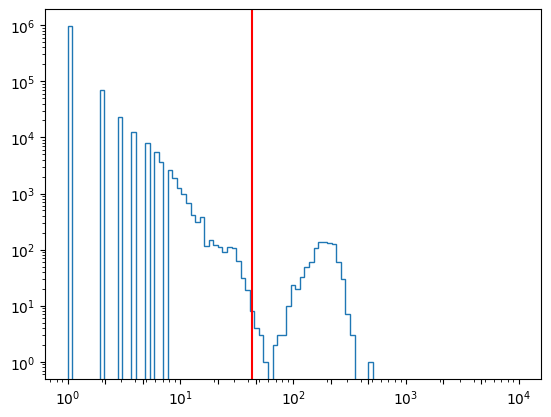

SUFU_Tile1_S205


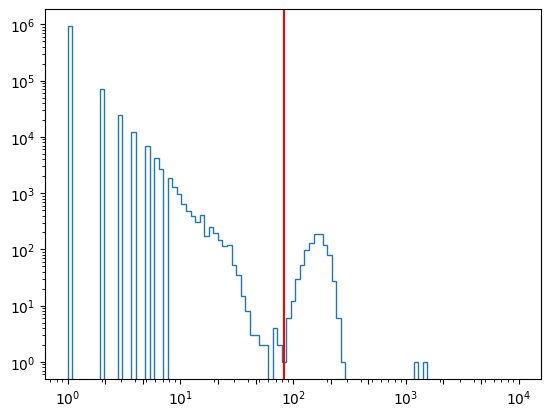

SUFU_Tile2_S206


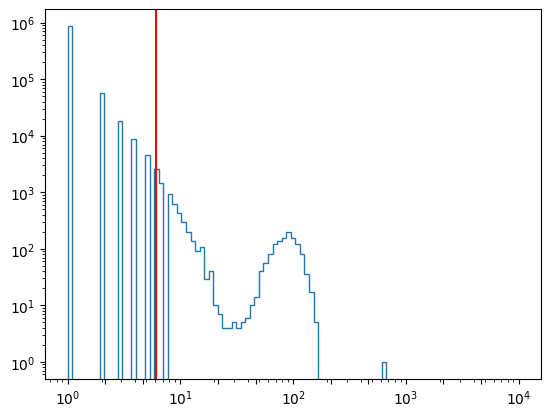

SUFU_Tile3_S207


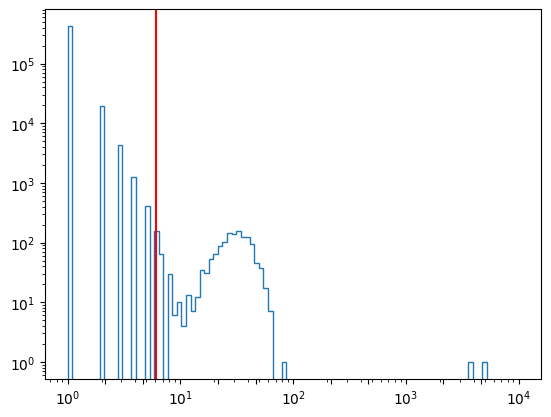

SUFU_Tile4_S208


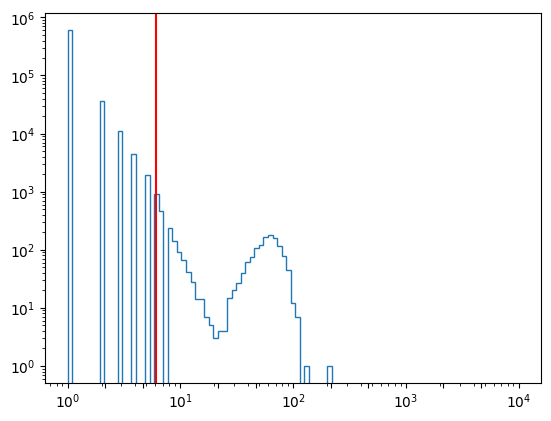

SUFU_Tile5_S209


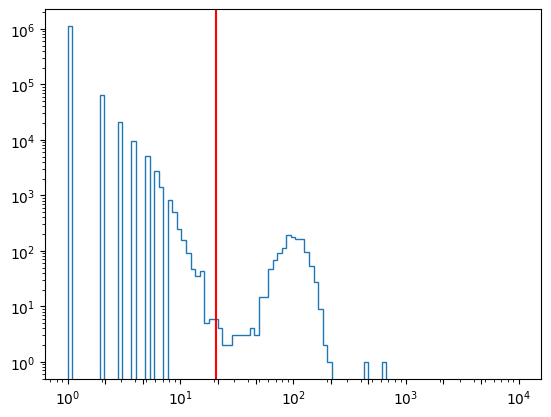

SUFU_Tile6_S210


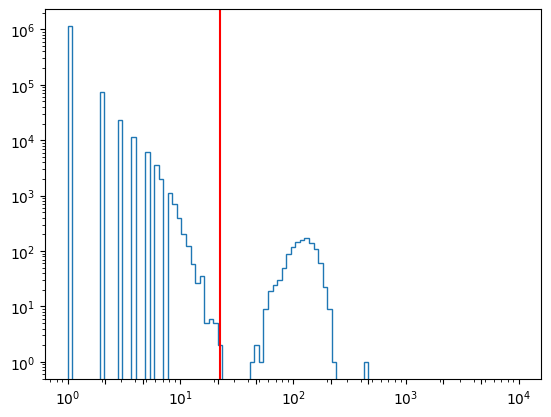

SUFU_Tile7_S211


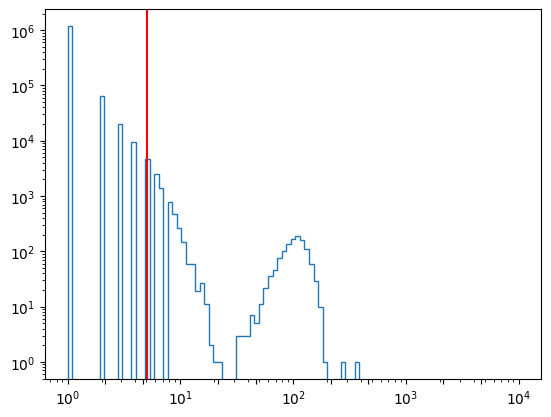

SUFU_Tile8_S212


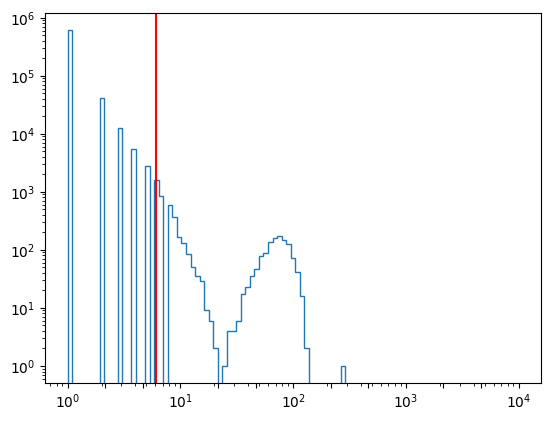

SUFU_Tile9_S213


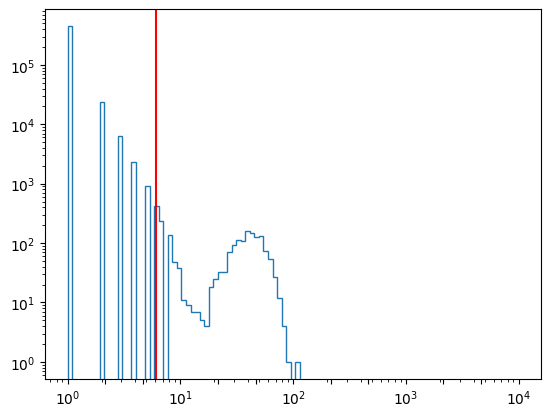

TANGO2_Tile1_S215


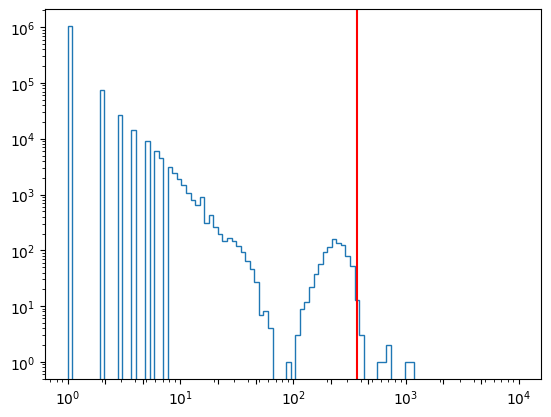

TANGO2_Tile2_S216


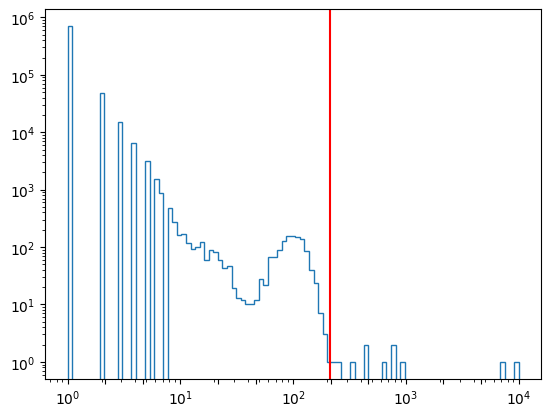

TANGO2_Tile3_S217


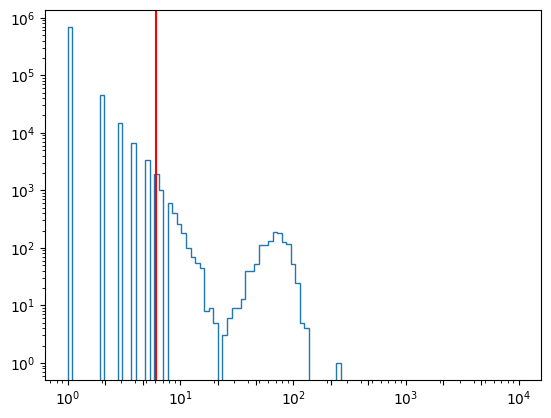

TANGO2_Tile4_S218


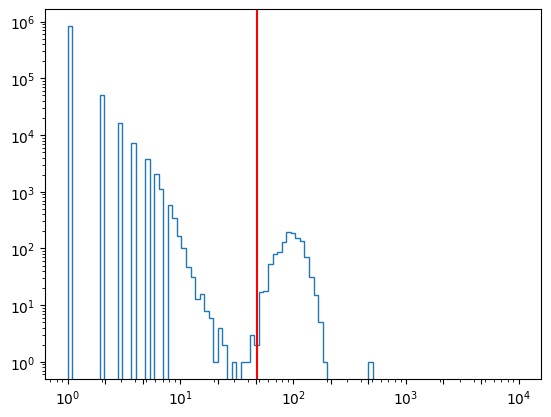

TANGO2_Tile5_S219


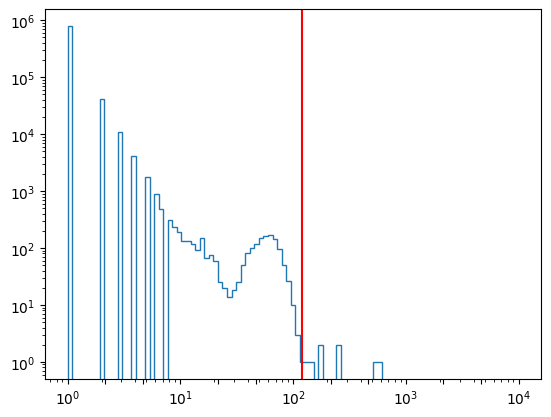

TANGO2_Tile6_S220


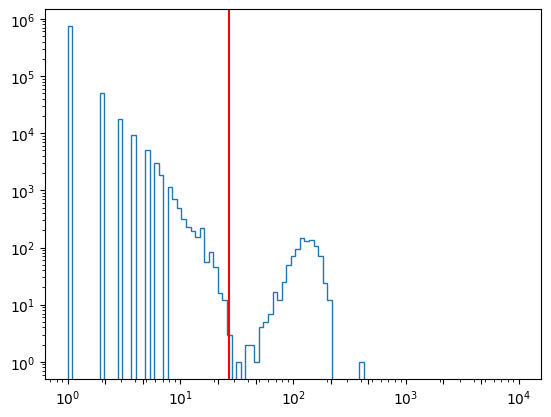

TRIO_tile_lib_S13


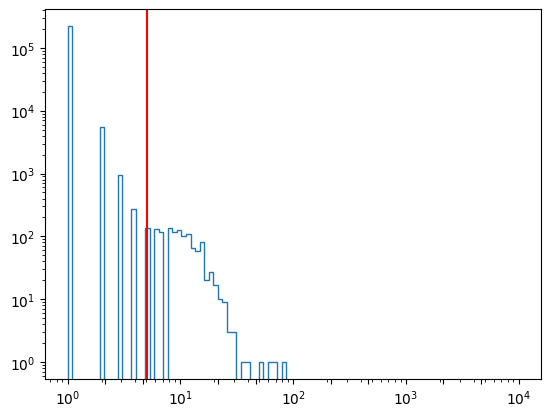

circRNA_architectures_current_hairpin_only_final_S18


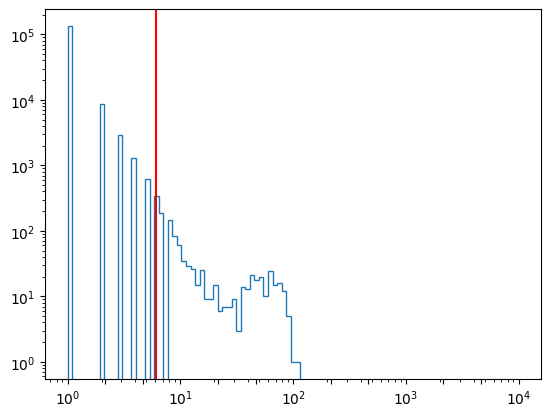

circRNA_architectures_full_order_final_S19


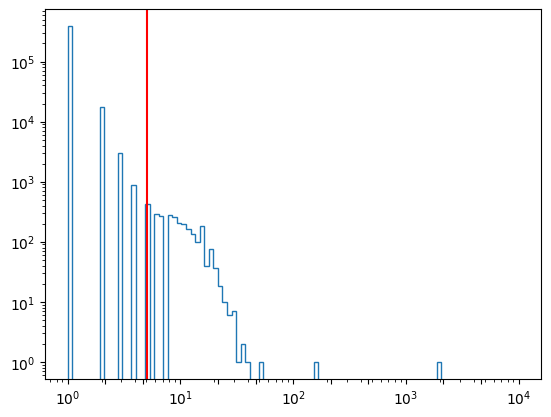

In [25]:
for key in oligo_subpools:
    print(key)
    labels, values = zip(*barcodes_unique_count[key].items())
    plt.hist(values, histtype='step', log=True, bins=10**np.linspace(0, 4, 100))
    plt.axvline(x = cutoffs[key], color = 'r', label = 'read cutoff')
    plt.xscale('log')
    plt.xticks(10**np.linspace(0, 4, 13))
    plt.show()
    

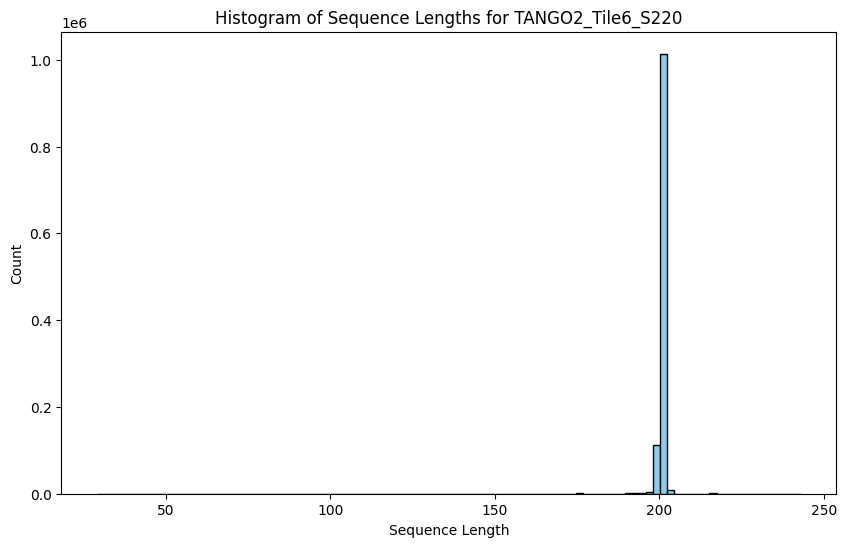

In [16]:
# Find the file for TANGO2_Tile6_S220
file_path = [f for f in sequencing_path_list_barcodes if 'TANGO2_Tile6_S220' in f][0]

# Read the sequences from the fastq file
with open(file_path, 'r') as f:
    lines = f.readlines()
    seqs = [line.rstrip() for line in lines[1::4]]

# Get the length of each sequence
seq_lengths = [len(s) for s in seqs]

# Plot histogram of sequence lengths
plt.figure(figsize=(10,6))
plt.hist(seq_lengths, bins=100, color='skyblue', edgecolor='k')
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.title('Histogram of Sequence Lengths for TANGO2_Tile6_S220')
plt.show()

20250513_oligo_order_KP_S17
184867


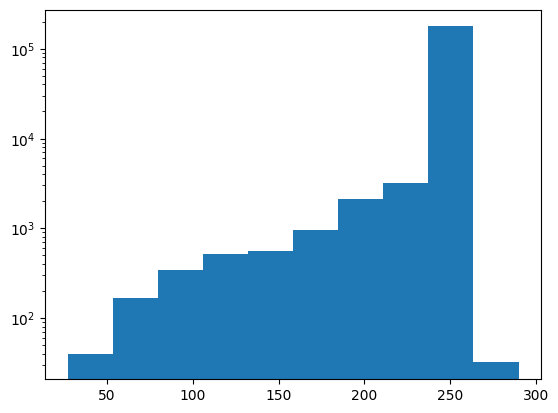

AH_Tile_F10_S20
139709


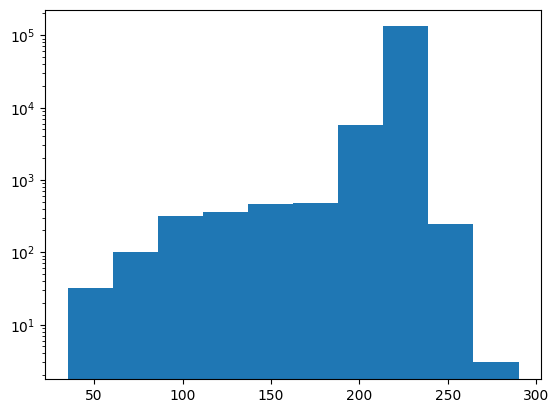

AH_Tile_F11_S21
230991


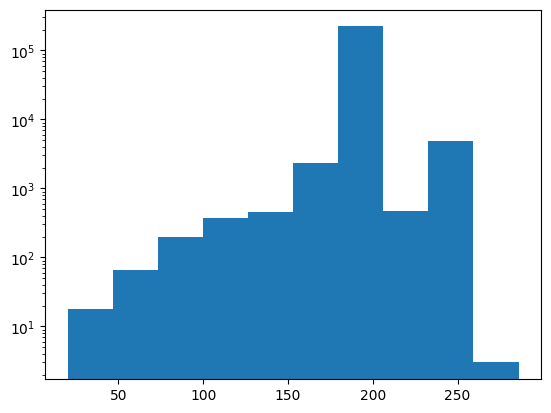

AH_Tile_F2_S22
713


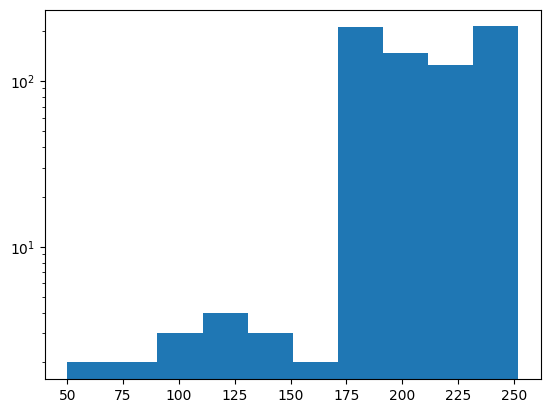

AH_Tile_F3_S23
653


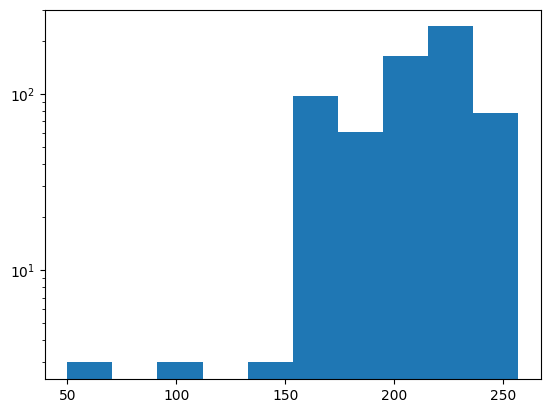

AH_Tile_F4_S24
303934


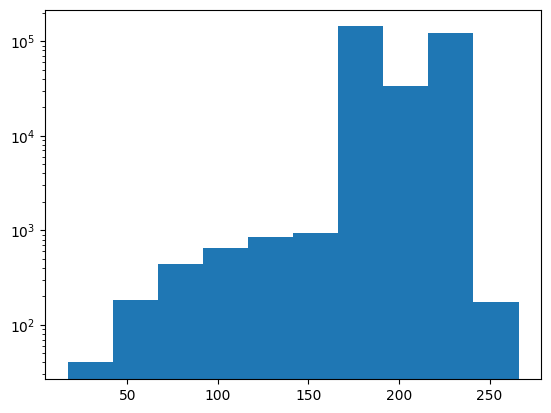

AH_Tile_F5_S25
96876


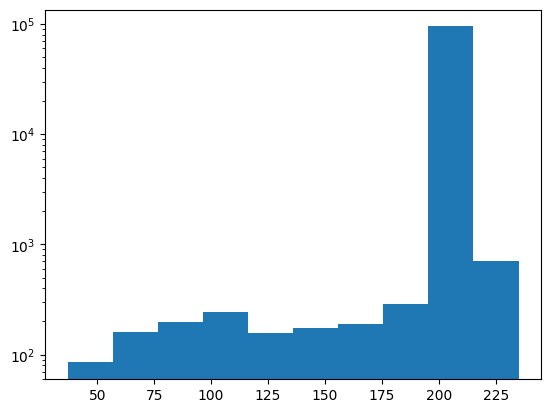

AH_Tile_F7_S26
176106


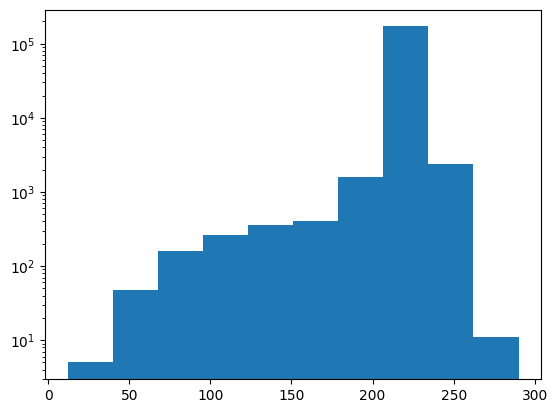

AH_Tile_F8_S27
230535


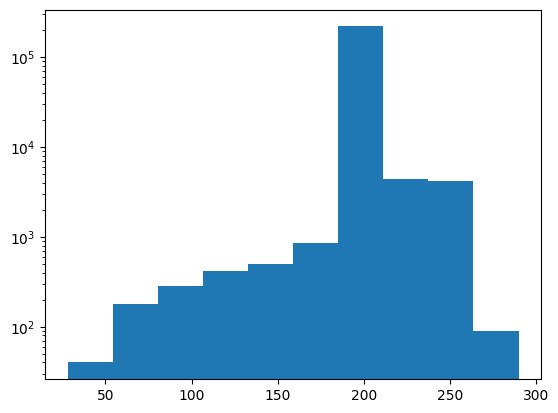

AH_Tile_F9_S28
236315


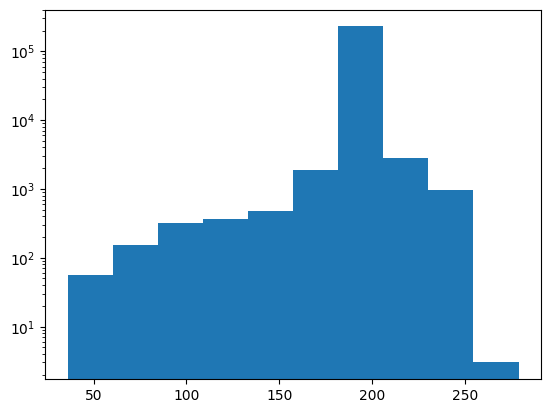

ARAFcterm_block4_V453E_tile_lib_S8
88626


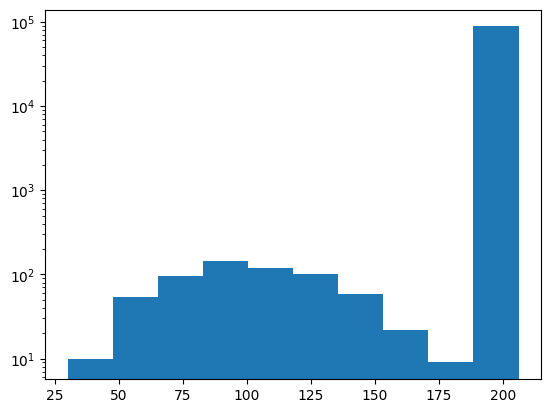

ARF1_Tile1_S29
314539


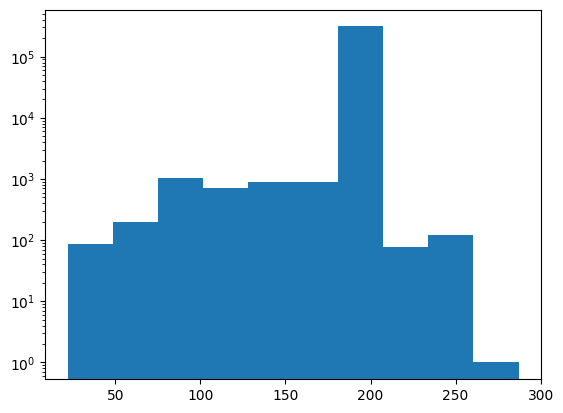

ARF1_Tile2_S30
543


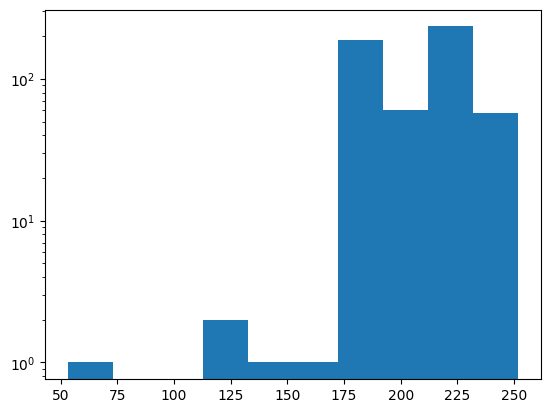

ARF1_Tile3_S31
473


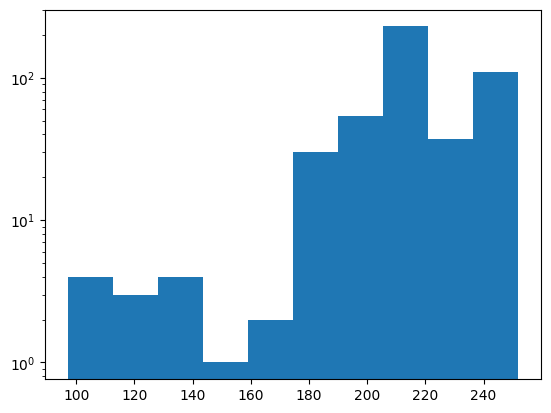

ARF1_Tile4_S32
347006


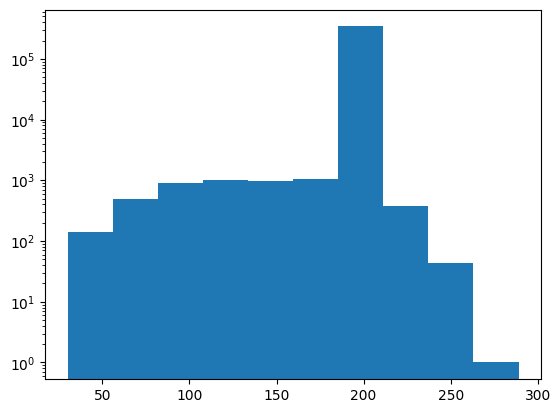

BBS1_Tile10_S42
241606


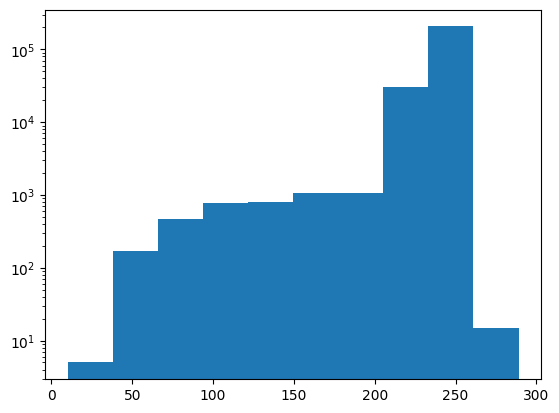

BBS1_Tile11_S43
509503


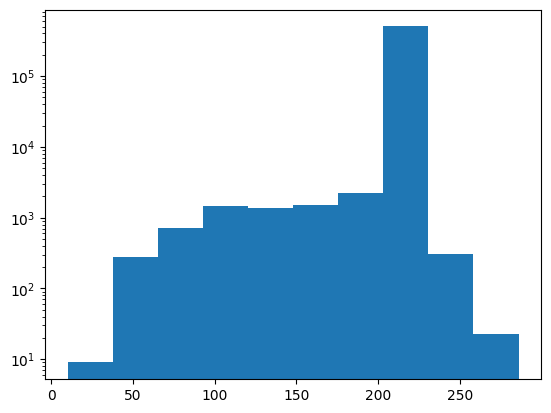

BBS1_Tile1_S33
337519


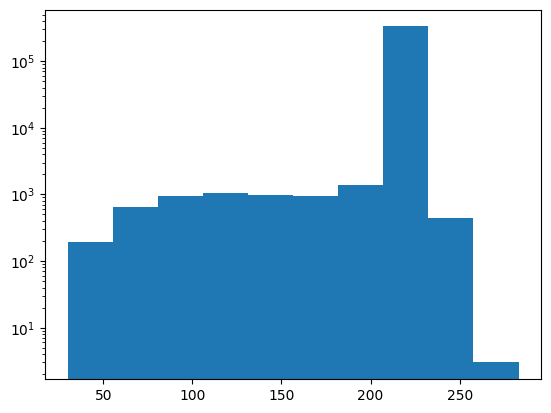

BBS1_Tile2_S34
223672


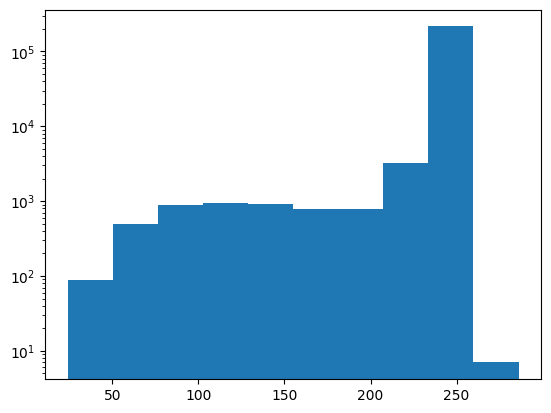

BBS1_Tile3_S35
271646


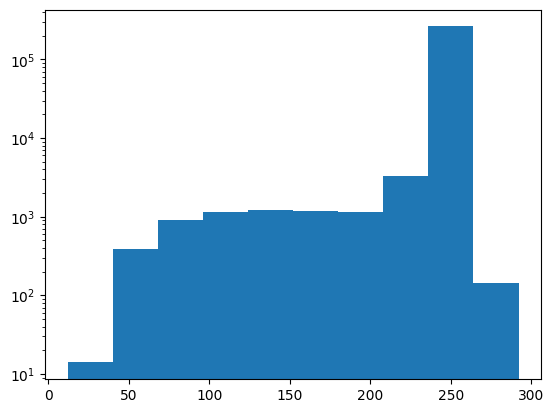

BBS1_Tile4_S36
413388


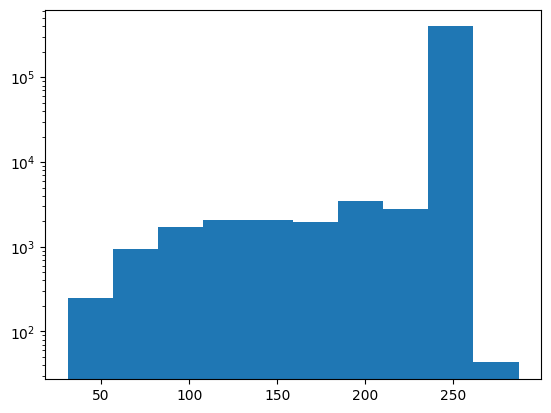

BBS1_Tile5_S37
243398


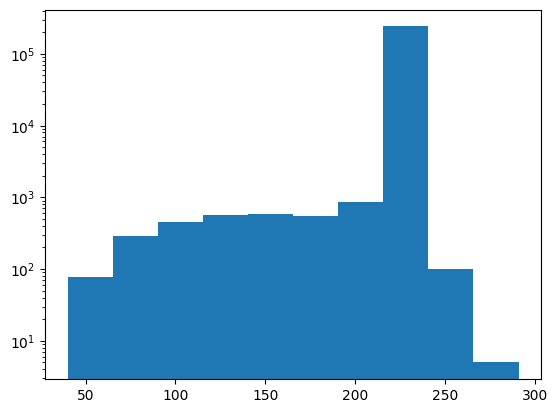

BBS1_Tile6_S38
322


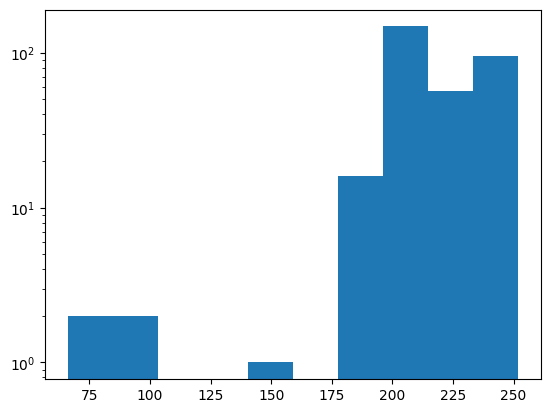

BBS1_Tile7_S39
560


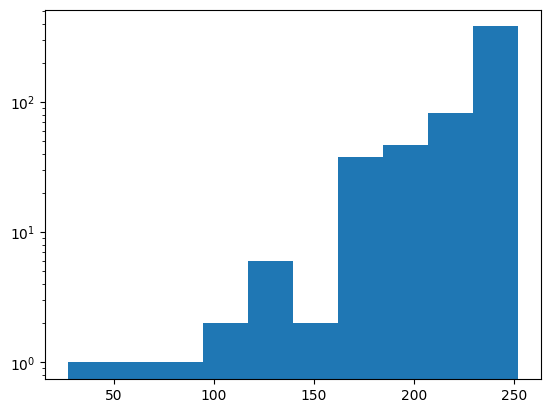

BBS1_Tile8_S40
390378


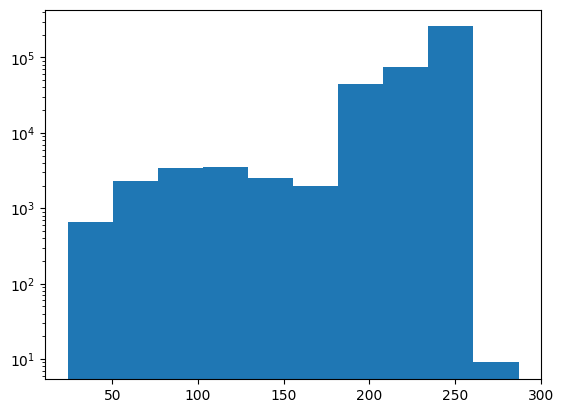

BBS1_Tile9_S41
273218


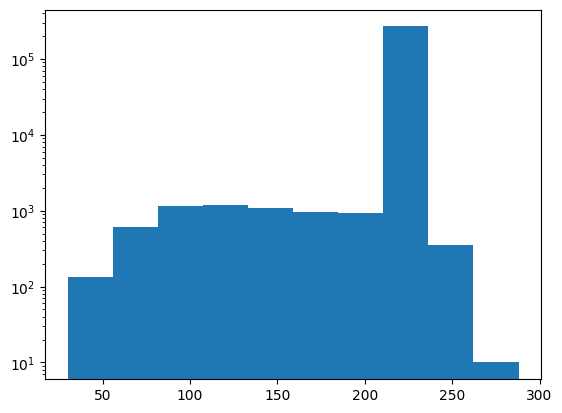

BCL10_Tile1_S44
254723


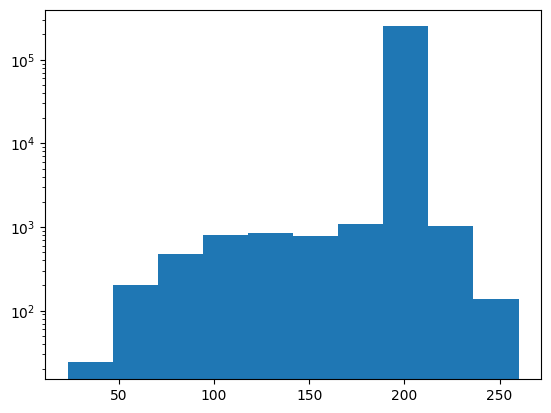

BCL10_Tile2_S45
86223


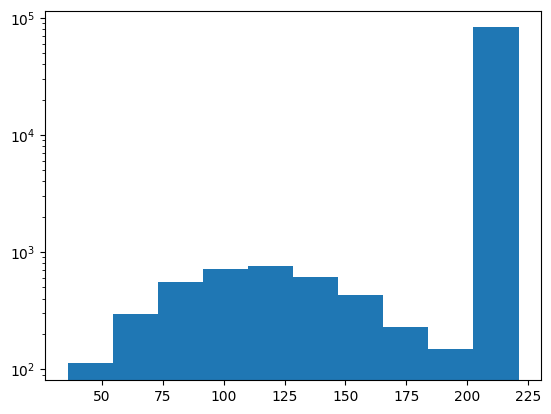

BCL10_Tile3_S46
314


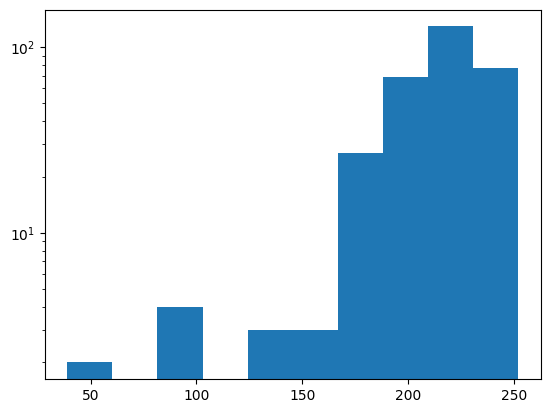

BCL10_Tile4_S47
490566


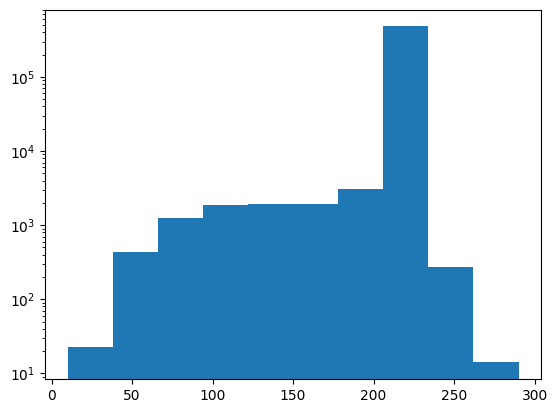

BCL10_Tile5_S48
277557


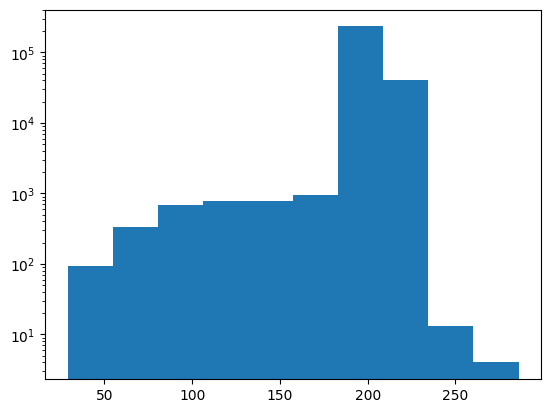

BRAFcterm_block2_R509H_tile_lib_S9
218168


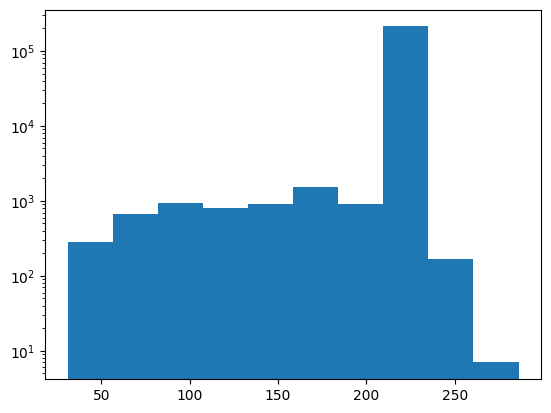

BRAFcterm_block6_V600E_tile_lib_S10
225281


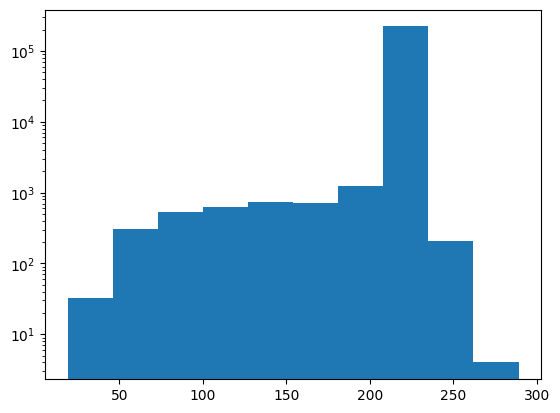

BRAFcterm_block7_S729E_tile_lib_S11
337854


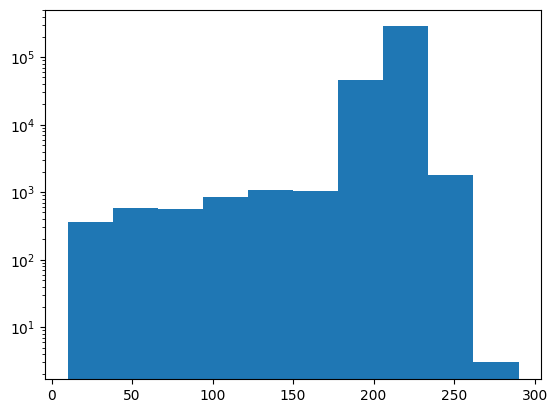

CDC42_Tile1_S49
189990


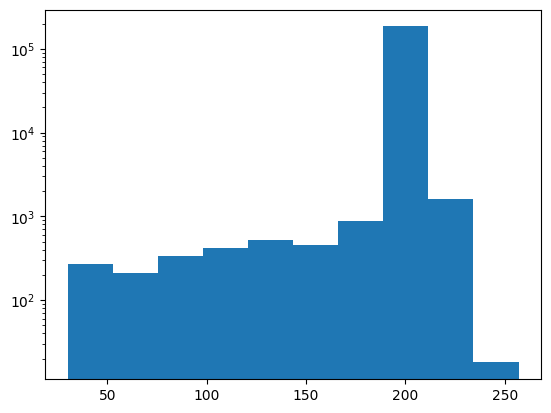

CDC42_Tile2_S50
193995


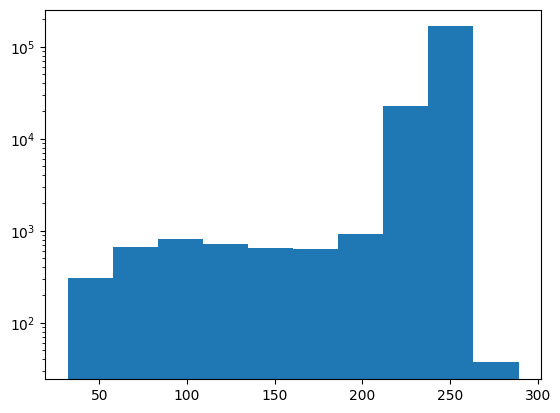

CDC42_Tile3_S51
234715


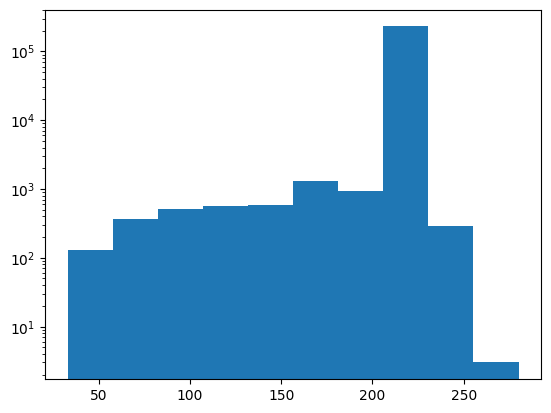

CDC42_Tile4_S52
242585


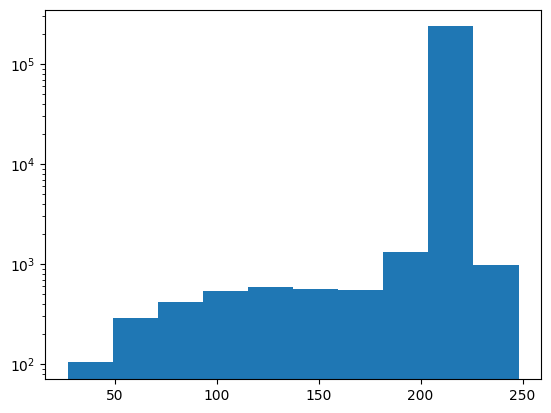

CRAFcterm_block3_V492E_tile_lib_S12
300615


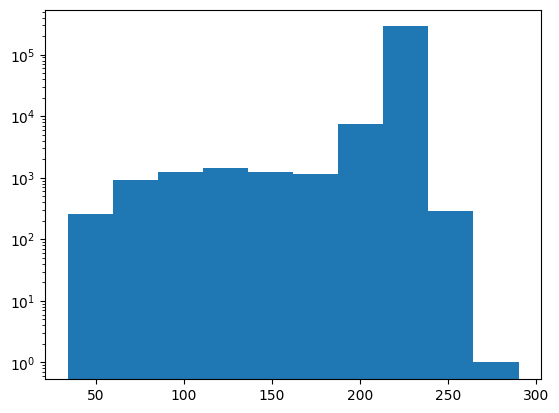

EPM2A_Tile1_S53
217635


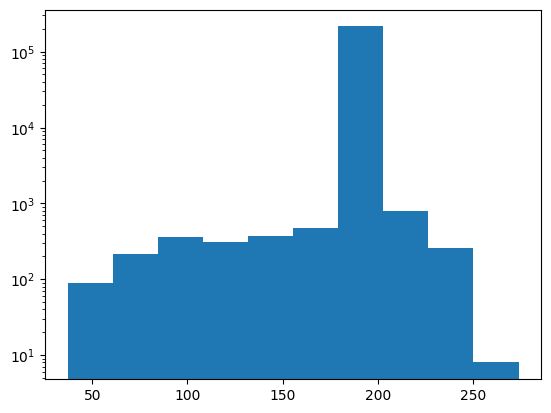

EPM2A_Tile2_S54
241439


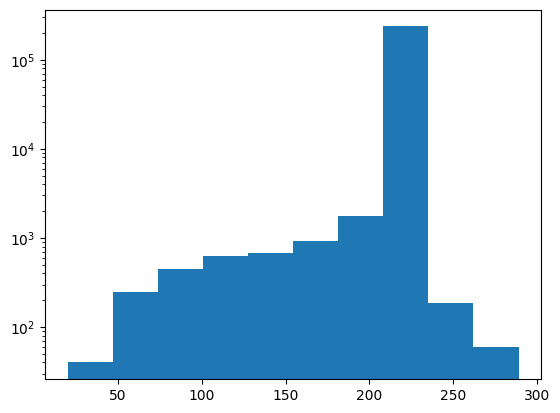

EPM2A_Tile3_S55
173882


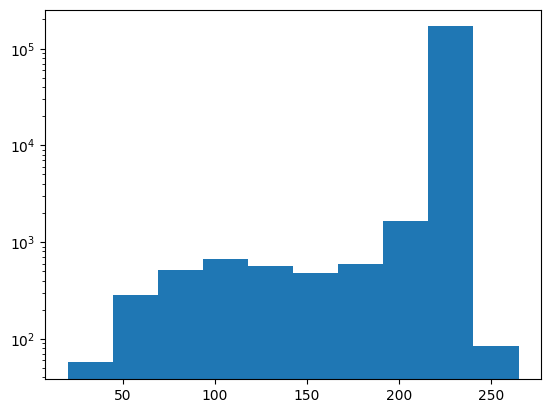

EPM2A_Tile4_S56
212189


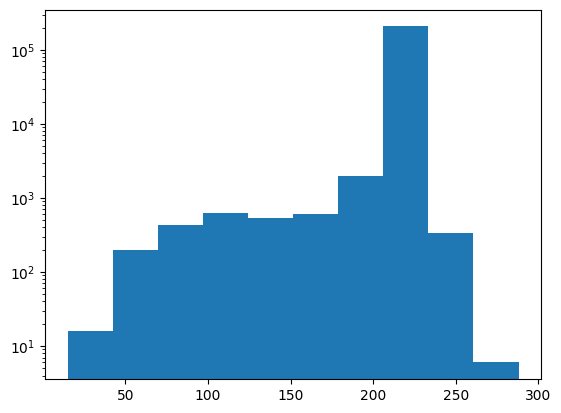

EPM2A_Tile5_S57
240696


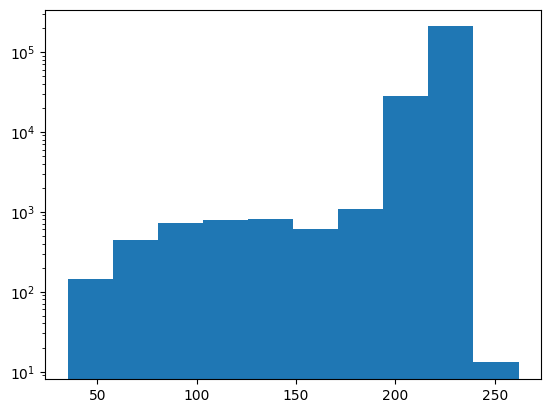

EPM2A_Tile6_S58
225347


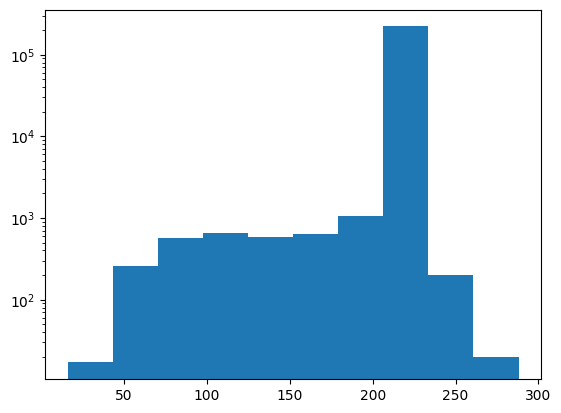

EPM2A_Tile7_S59
276260


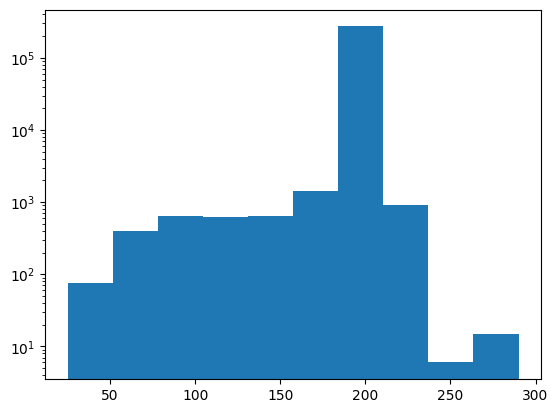

ETV6_Tile1_S60
299887


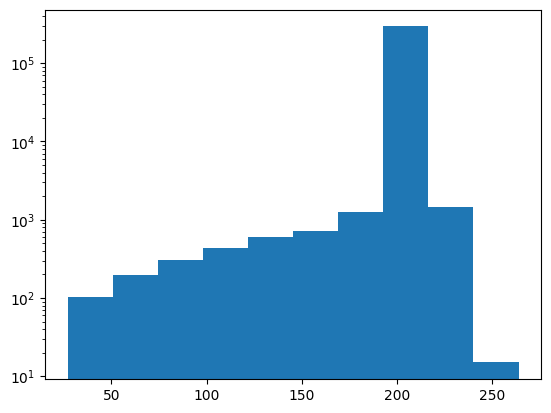

ETV6_Tile2_S61
262762


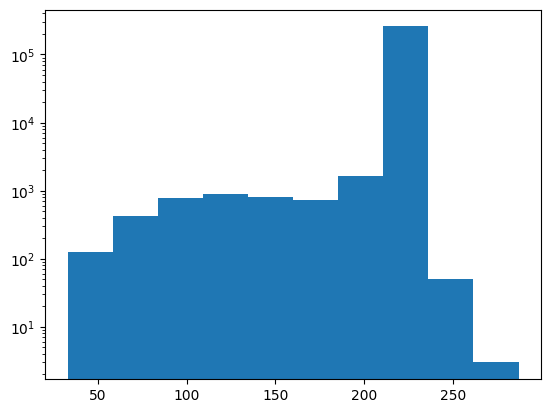

ETV6_Tile3_S62
216921


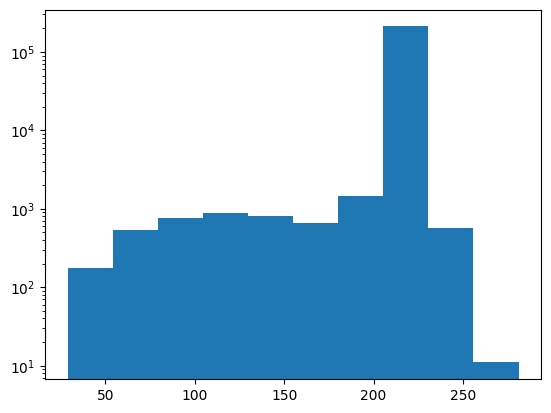

ETV6_Tile4_S63
279069


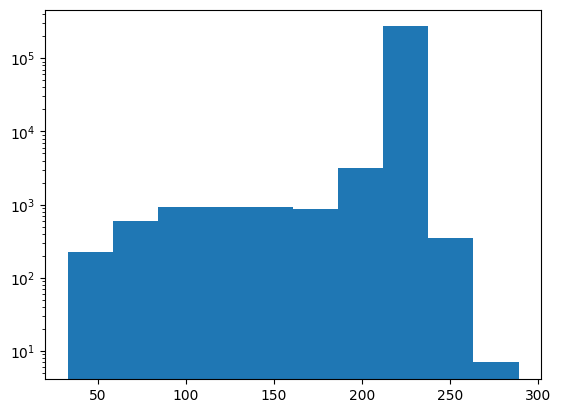

ETV6_Tile5_S64
293410


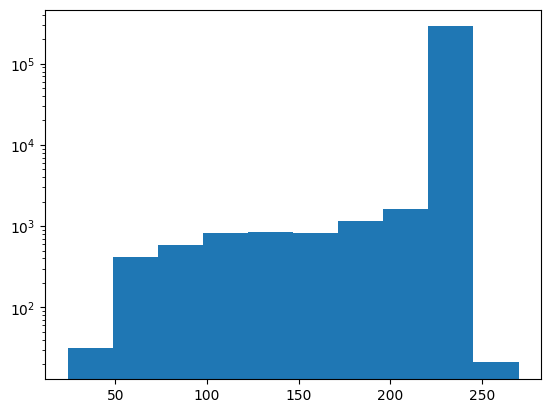

ETV6_Tile6_S65
196443


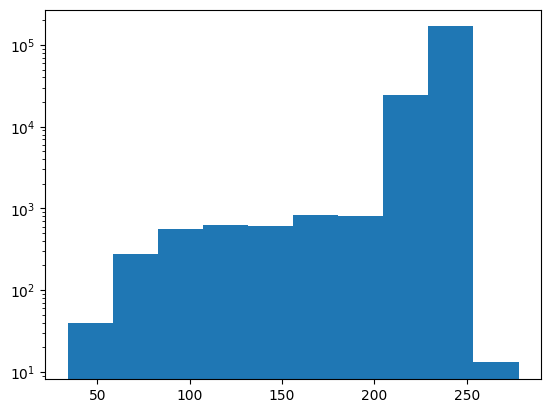

ETV6_Tile7_S66
256928


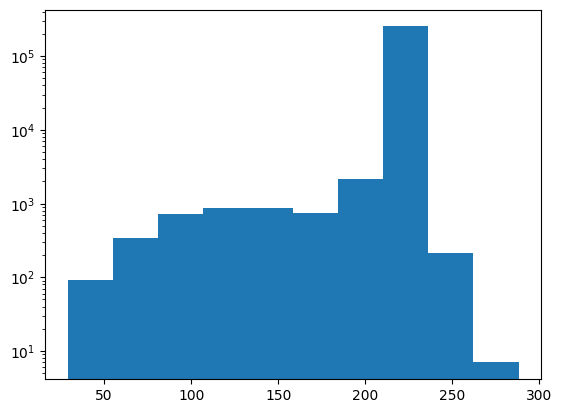

ETV6_Tile8_S67
210181


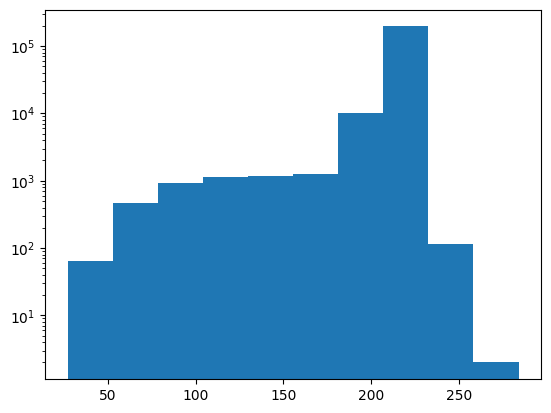

ETV6_Tile9_S68
257968


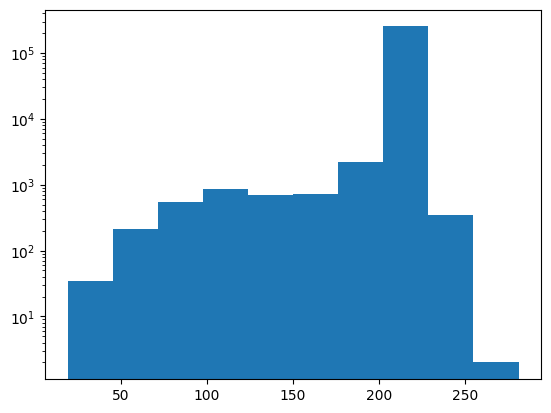

FOXP3_Tile1_S69
278775


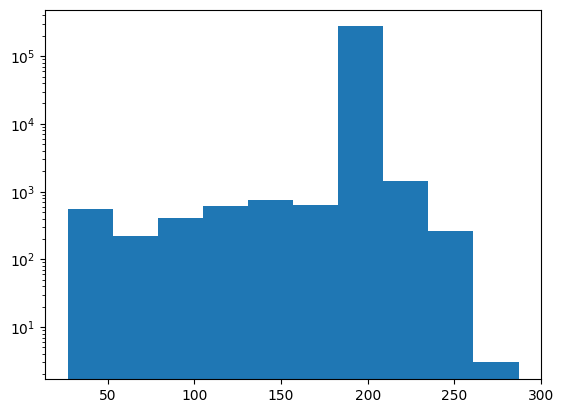

FOXP3_Tile2_S70
263646


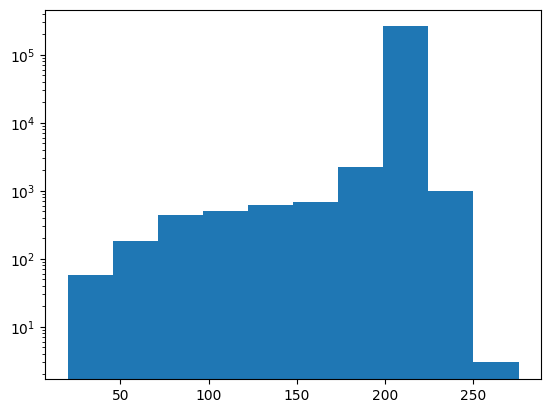

FOXP3_Tile3_S71
267861


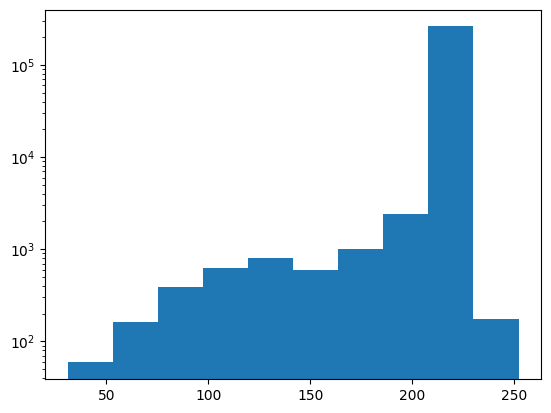

FOXP3_Tile4_S72
253957


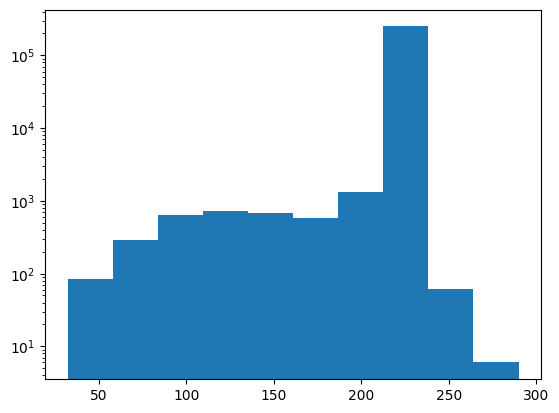

FOXP3_Tile5_S73
273327


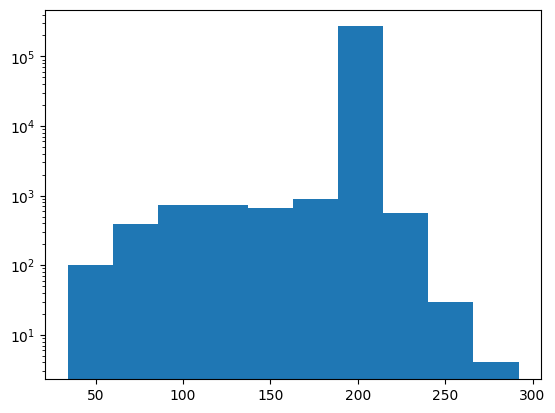

FOXP3_Tile6_S74
251633


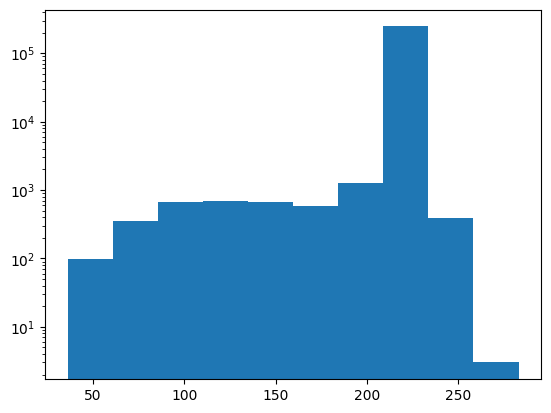

FOXP3_Tile7_S75
322197


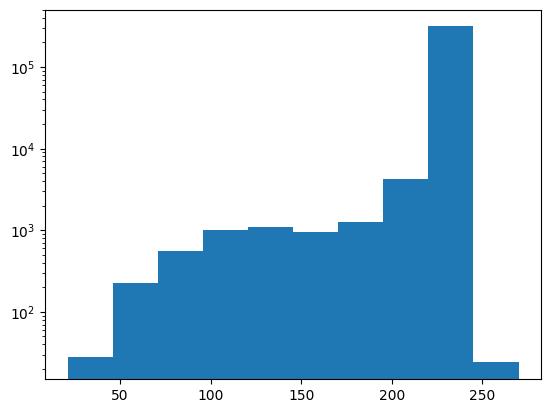

FOXP3_Tile8_S76
363040


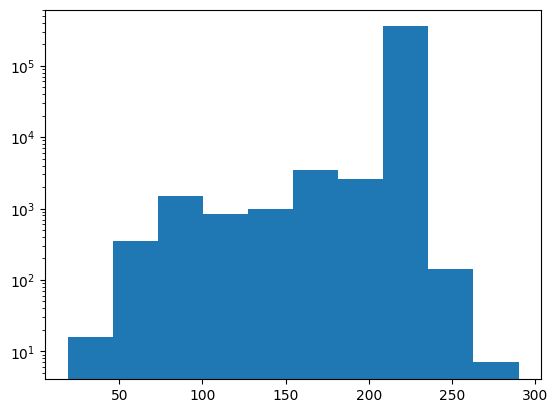

FOXP3_Tile9_S77
280580


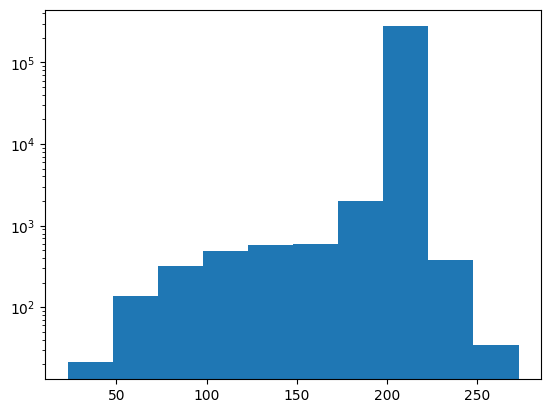

FRED1_10_S241
114294


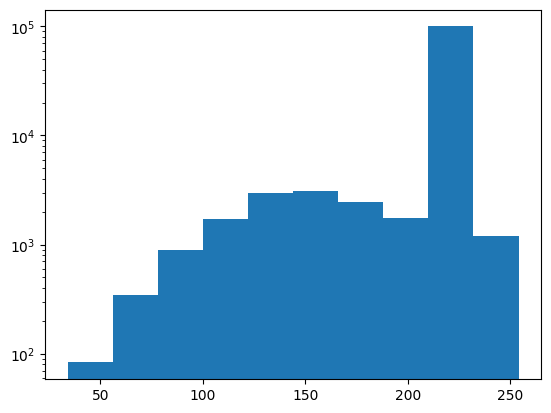

FRED1_11_S242
116774


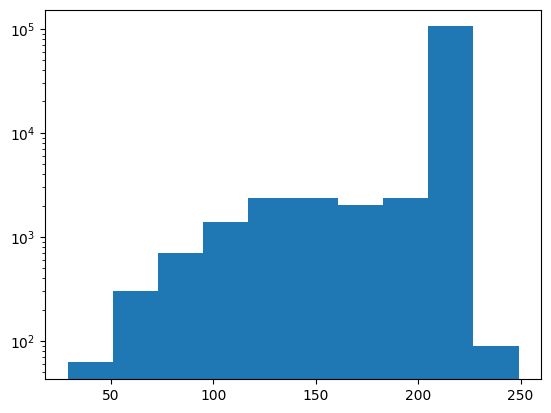

FRED1_1_S232
82893


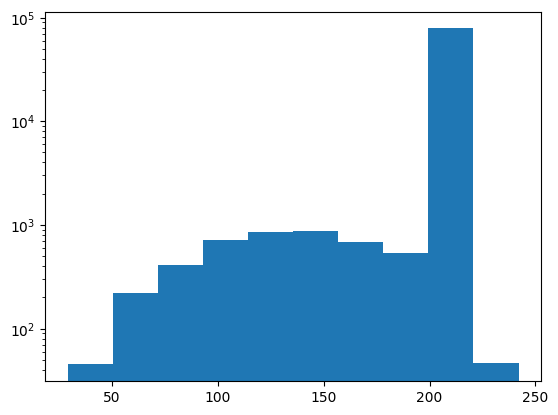

FRED1_2_S233
116447


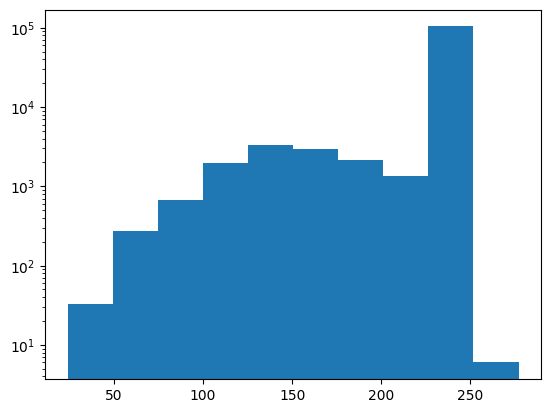

FRED1_3_S234
120670


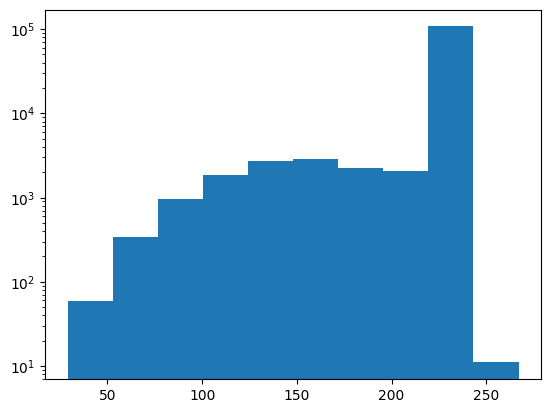

FRED1_4_S235
113719


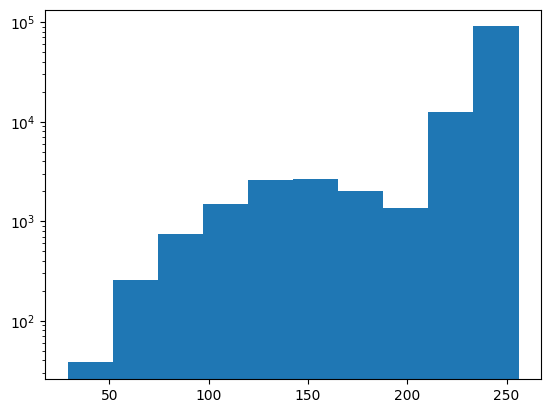

FRED1_5_S236
113438


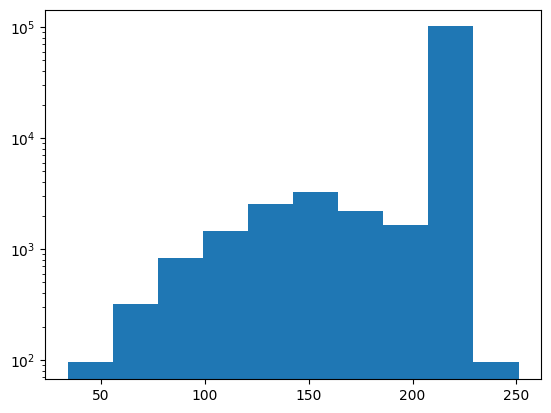

FRED1_6_S237
118067


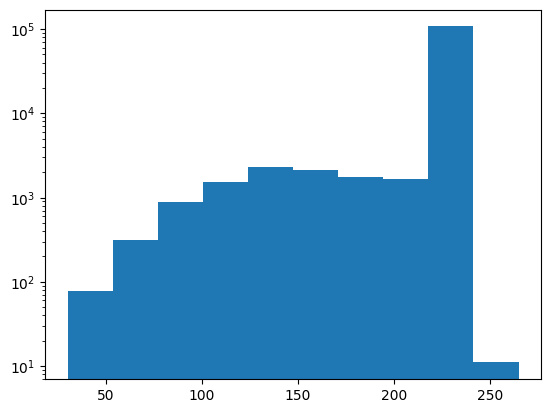

FRED1_7_S238
127780


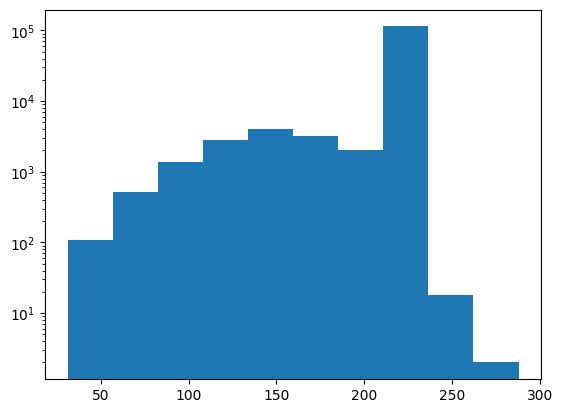

FRED1_8_S239
76797


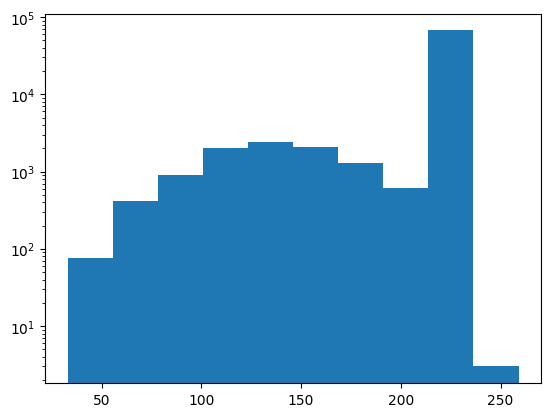

FRED1_9_S240
99086


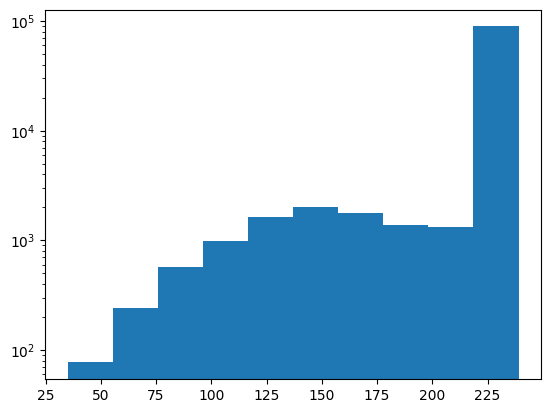

FRED2_10_S252
108944


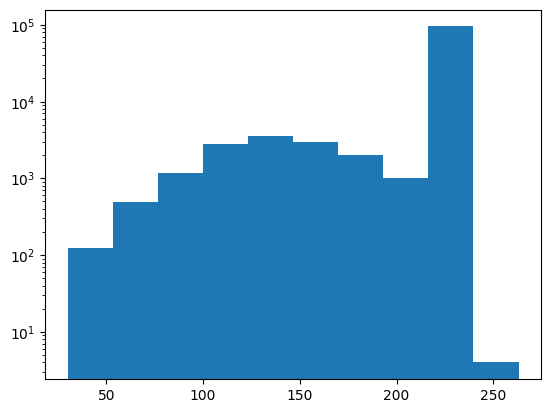

FRED2_11_S253
107574


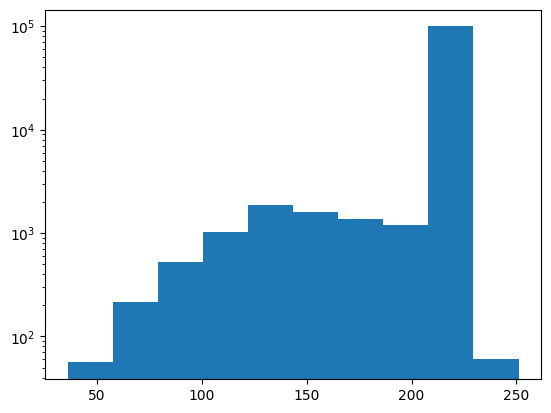

FRED2_1_S243
104043


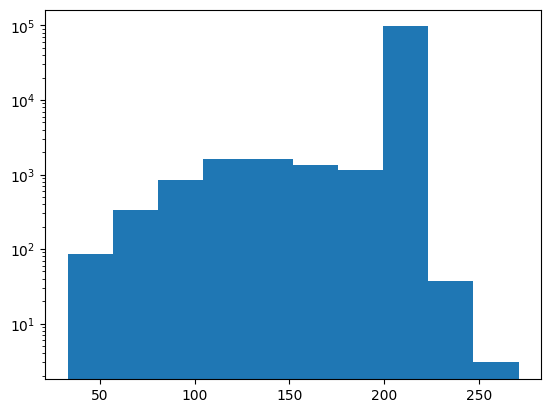

FRED2_2_S244
117559


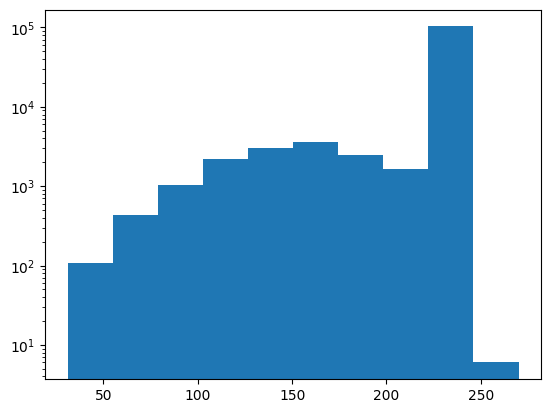

FRED2_3_S245
519113


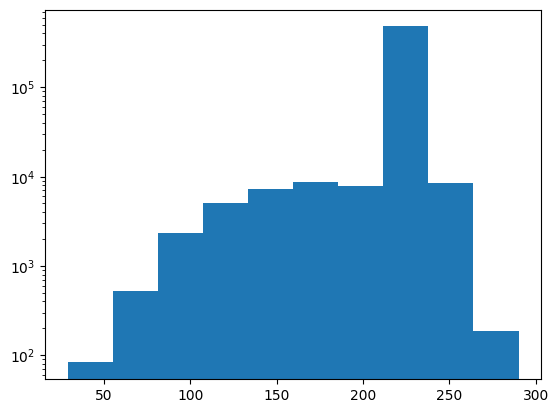

FRED2_4_S246
86583


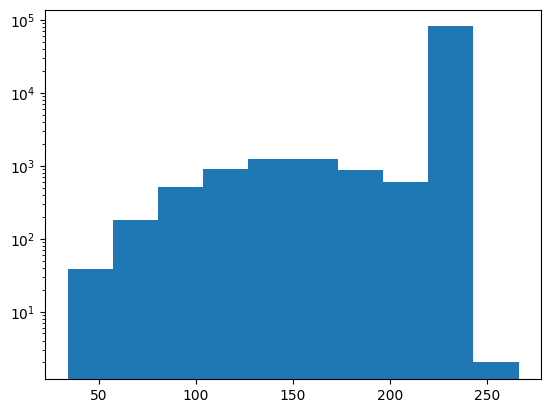

FRED2_5_S247
116113


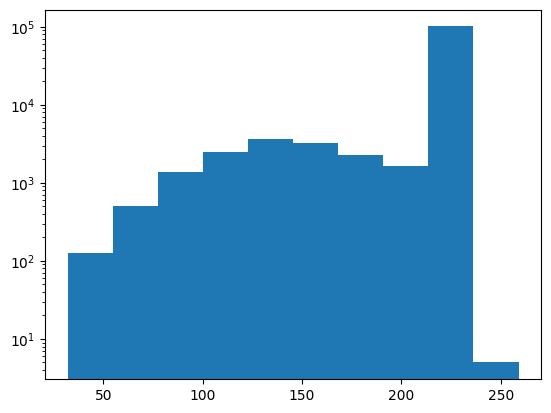

FRED2_6_S248
114337


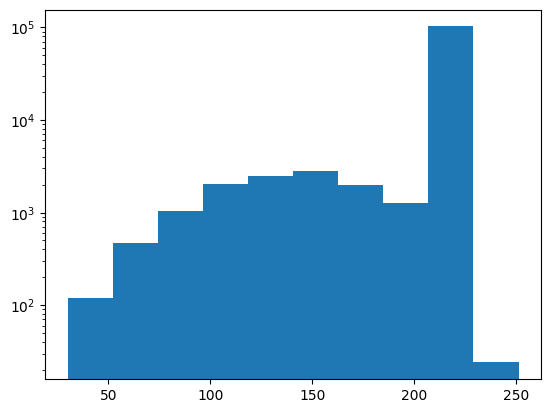

FRED2_7_S249
119475


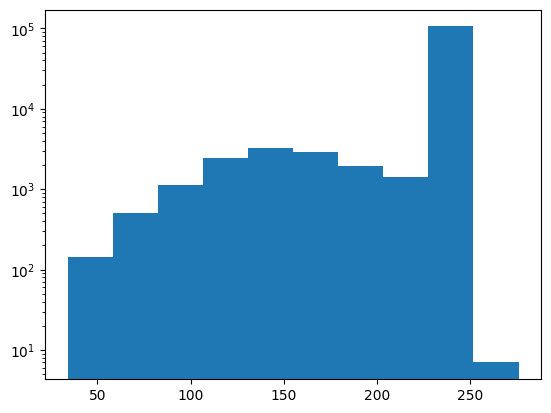

FRED2_8_S250
115099


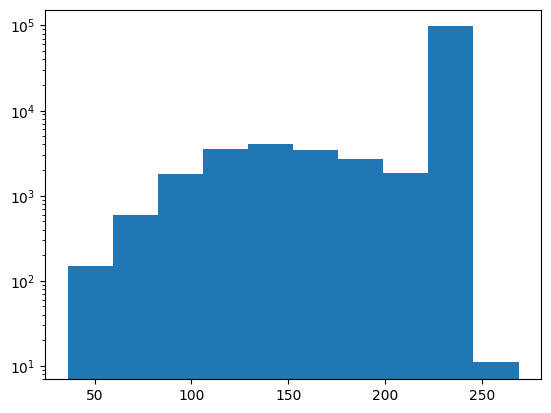

FRED2_9_S251
137489


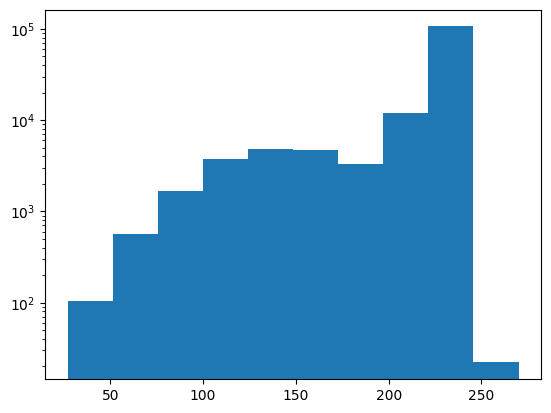

FRED3_10_S230
118959


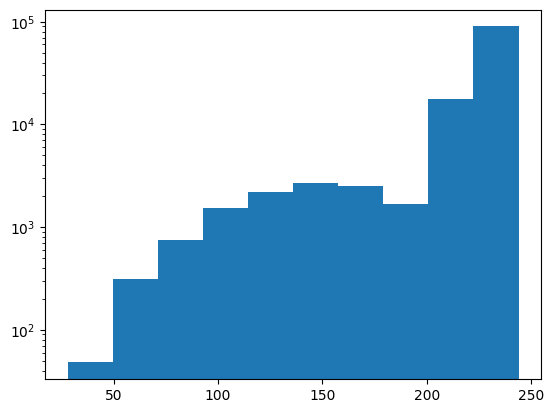

FRED3_11_S231
100963


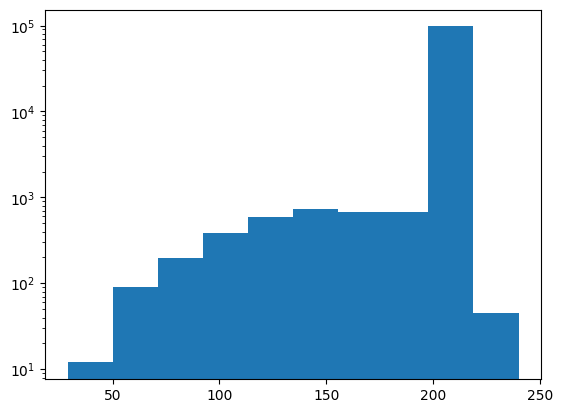

FRED3_1_S221
113571


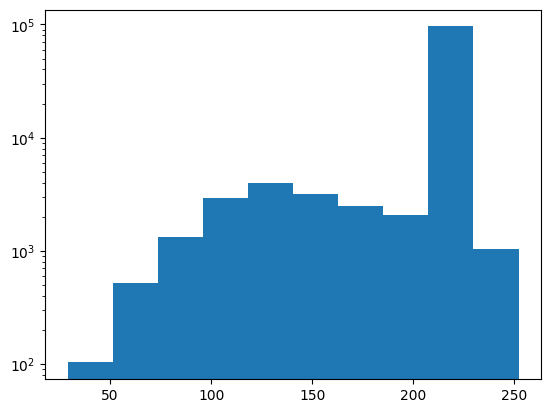

FRED3_2_S222
108671


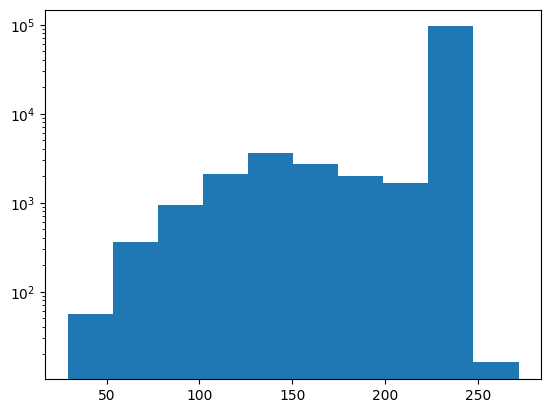

FRED3_3_S223
113401


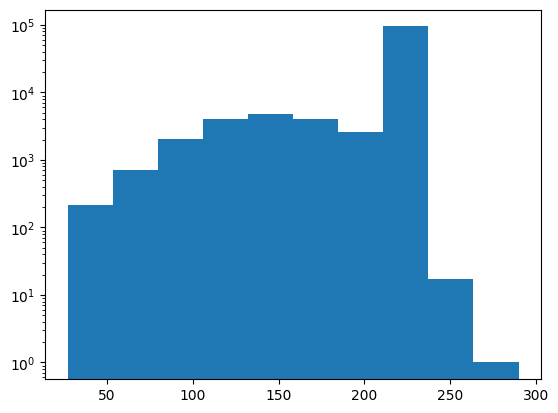

FRED3_4_S224
102328


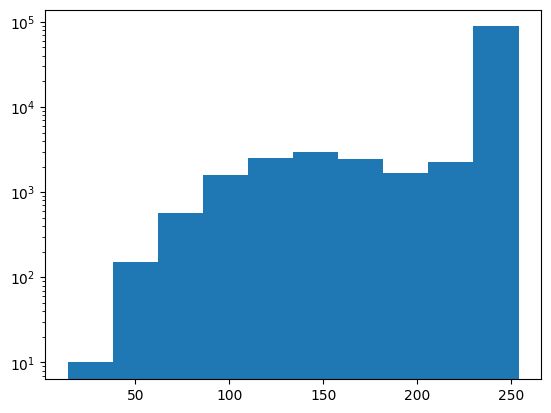

FRED3_5_S225
109927


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x107a39400>>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/GG_lib/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


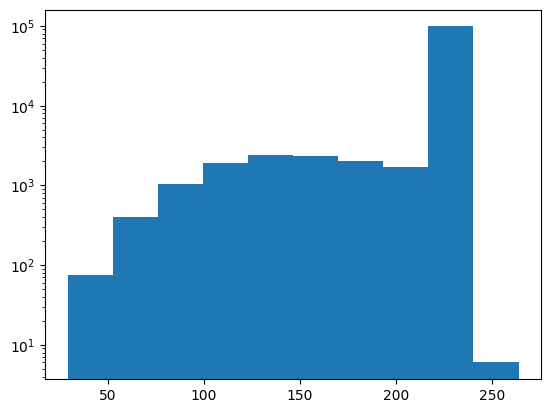

FRED3_6_S226
78802


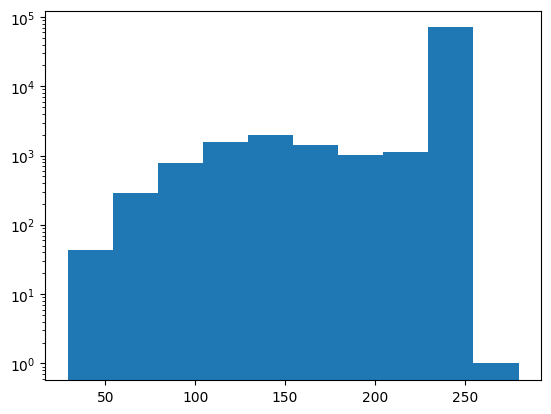

FRED3_7_S227
111208


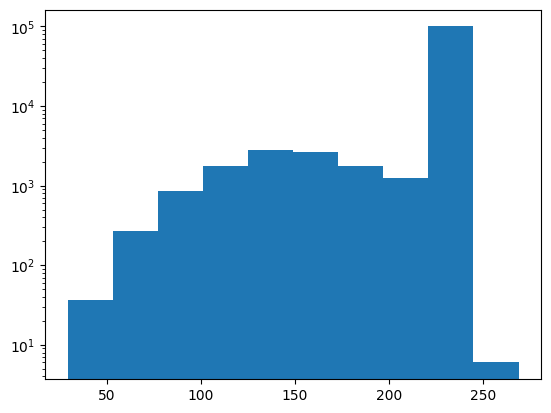

FRED3_8_S228
106103


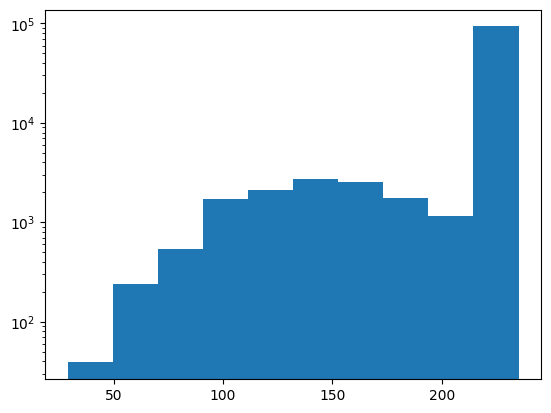

FRED3_9_S229
127254


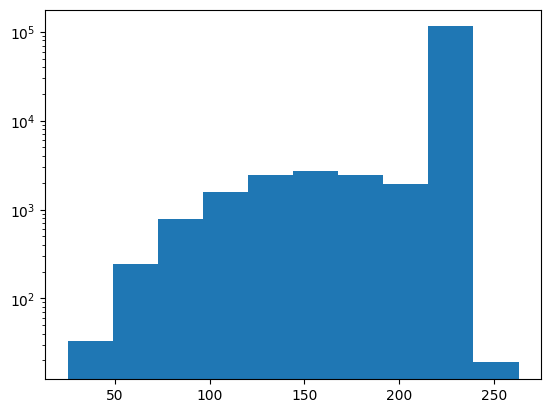

GATA2_Tile1_S78
609566


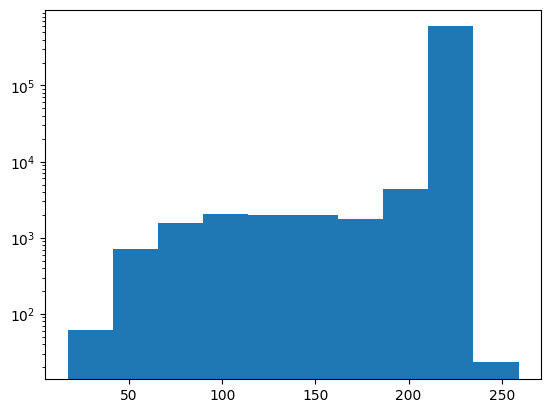

GATA2_Tile2_S79
663848


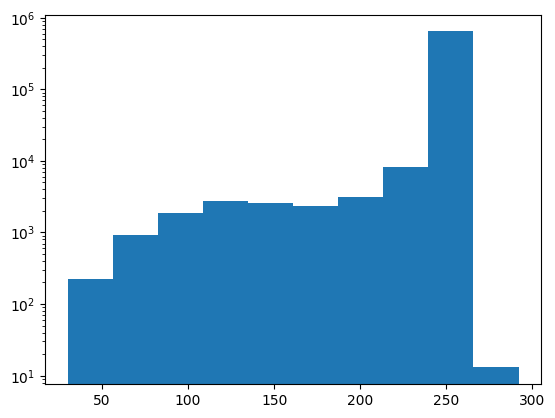

GATA2_Tile3_S80
305740


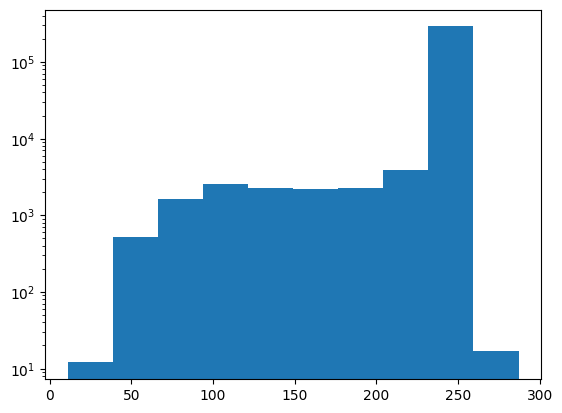

GATA2_Tile4_S81
85239


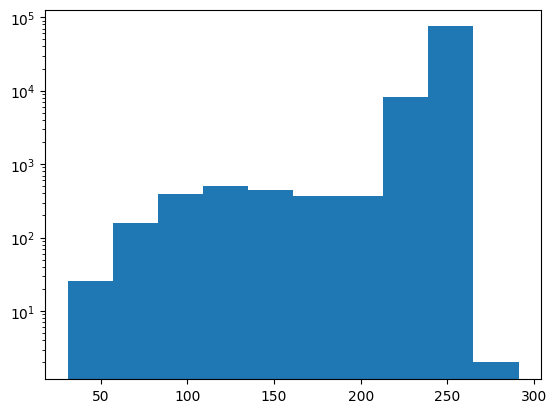

GATA2_Tile5_S82
211485


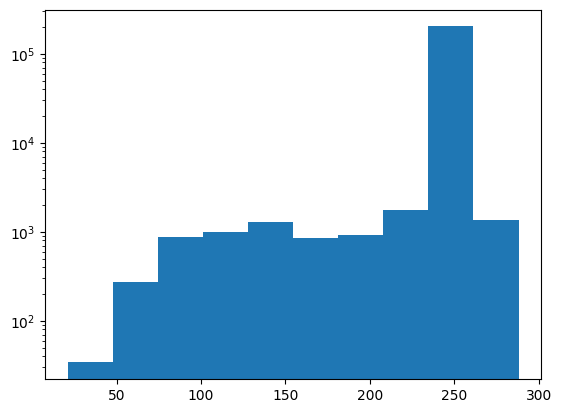

GATA2_Tile6_S83
252006


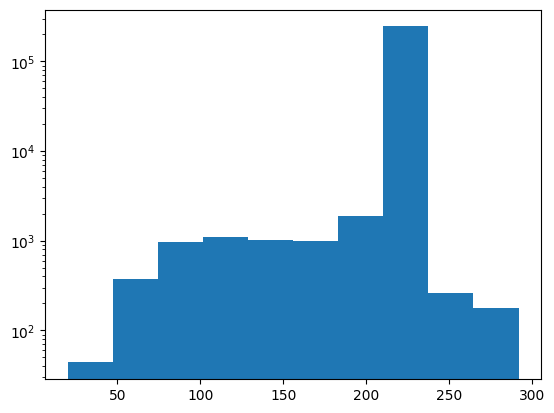

GATA2_Tile7_S84
271267


In [ ]:
for key in oligo_subpools:
    print(key)
    print(len(barcodes_real[key]))
    plt.hist([len(s) for s in barcodes_real[key]])
    plt.yscale('log')
    plt.show()


In [9]:
for key in oligo_subpools:
    print(key)
    print(len(barcodes_real[key]))
    modal_length = scipy.stats.mode([len(s) for s in barcodes_real[key]])
    print('Freq of oligos of correct size: ' + str(len([s for s in barcodes_real[key] if len(s) in [modal_length.mode[0],modal_length.mode[0]-3]])/len(barcodes_real[key])))

    plt.hist([len(s) for s in barcodes_real[key]], bins=np.linspace(150,300,101))
    plt.yscale('log')
    plt.ylim([1,10**(3.5)])
    plt.show()
    

20250513_oligo_order_KP_S17
118014


IndexError: invalid index to scalar variable.

ARAFcterm_tile1_S60
931


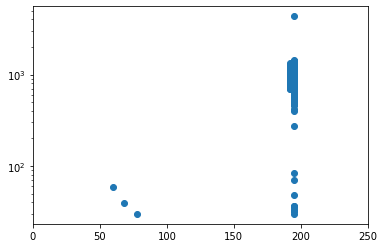

ARAFcterm_tile2_S61
1067


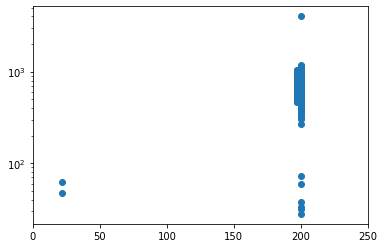

ARAFcterm_tile3_S62
1173


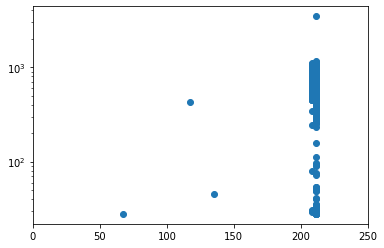

ARAFcterm_tile4_S63
1092


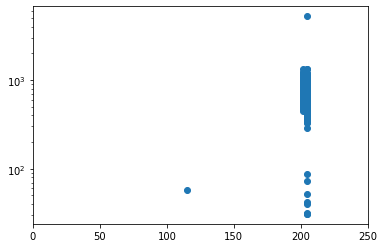

ARAFcterm_tile5_S64
1126


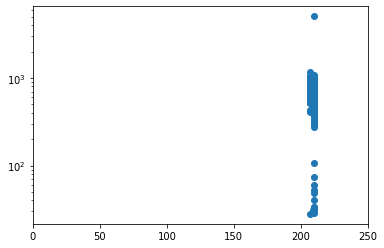

ARAFcterm_tile6_S65
1083


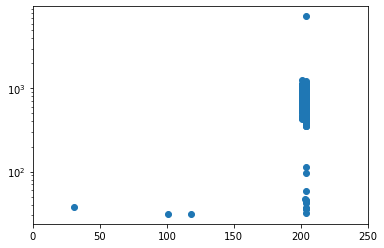

ARAFcterm_tile7_S66
983


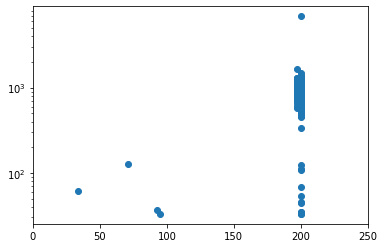

ARAFnterm_tile1_S54
1113


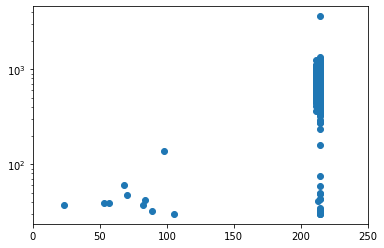

ARAFnterm_tile2_S55
1311


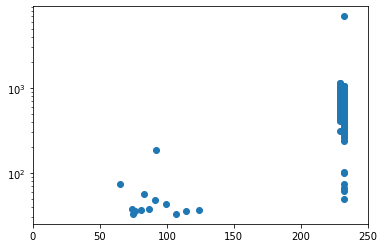

ARAFnterm_tile3_S56
1260


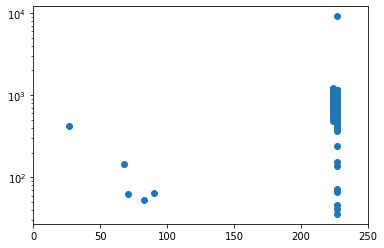

ARAFnterm_tile4_S57
1256


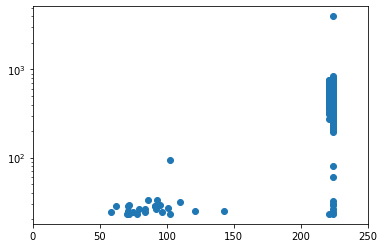

ARAFnterm_tile5_S58
1310


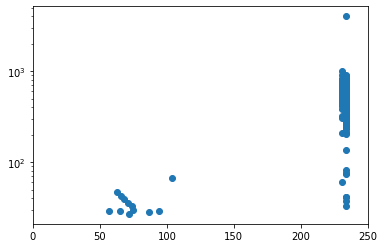

ARAFnterm_tile6_S59
1153


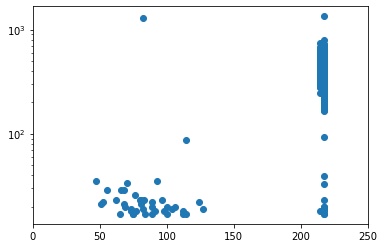

BRAFcterm_tile1_S1
1067


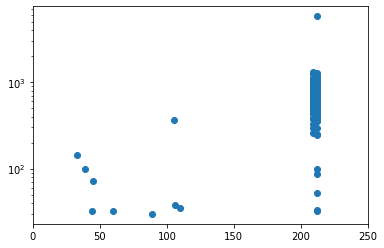

BRAFcterm_tile2_S2
1291


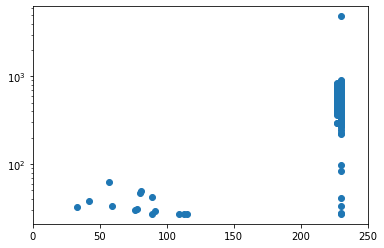

BRAFcterm_tile3_S3
1224


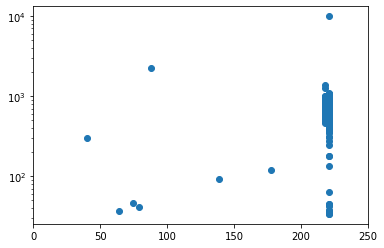

BRAFcterm_tile4_S4
1226


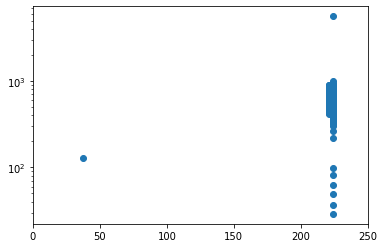

BRAFcterm_tile5_S5
1221


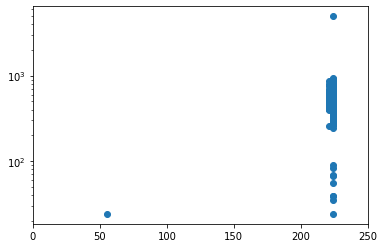

BRAFcterm_tile6_S6
1302


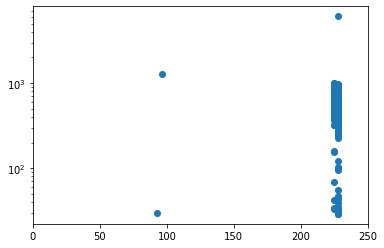

BRAFcterm_tile7_S7
1049


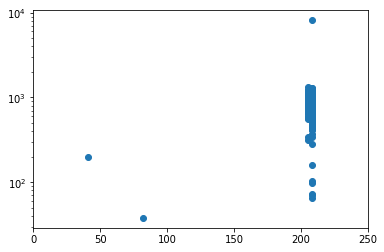

CRAFcterm_tile1_S67
1171


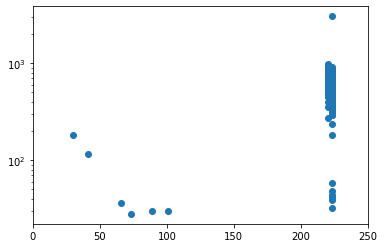

CRAFcterm_tile2_S68
1298


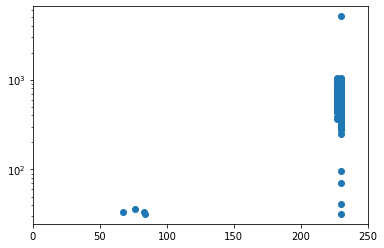

CRAFcterm_tile3_S69
1326


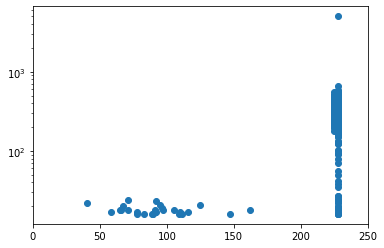

CRAFcterm_tile4_S70
1272


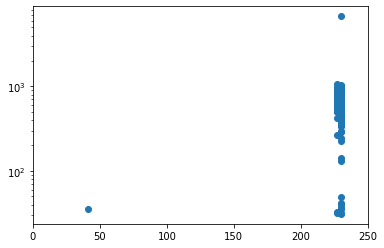

CRAFcterm_tile5_S71
1357


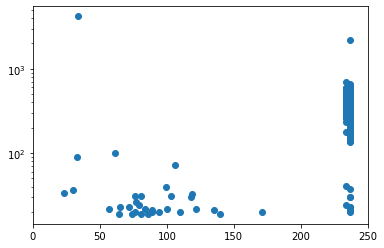

CRAFcterm_tile6_S72
1167


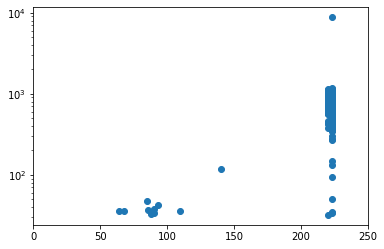

EGFRcterm_tile10_S21
1179


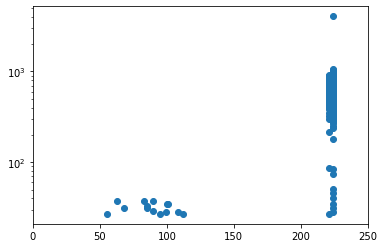

EGFRcterm_tile1_S12
1214


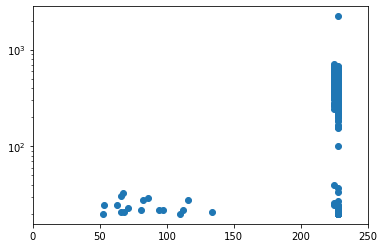

EGFRcterm_tile2_S13
1387


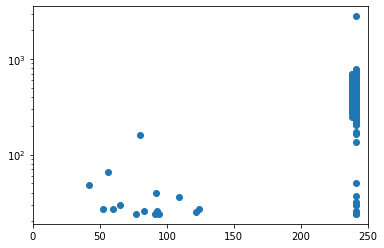

EGFRcterm_tile3_S14
1368


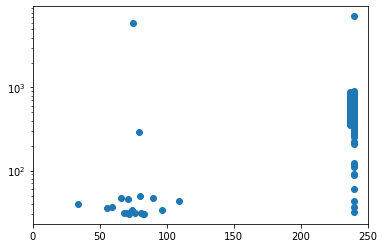

EGFRcterm_tile4_S15
1584


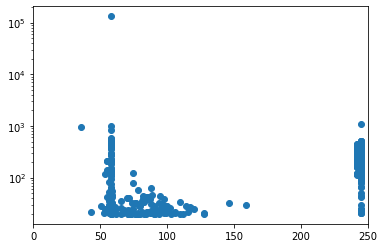

EGFRcterm_tile5_S16
2604


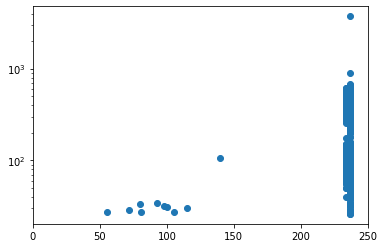

EGFRcterm_tile6_S17
1304


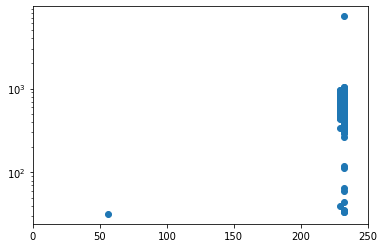

EGFRcterm_tile7_S18
1368


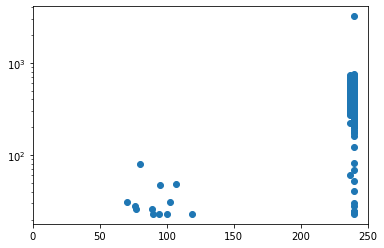

EGFRcterm_tile8_S19
1313


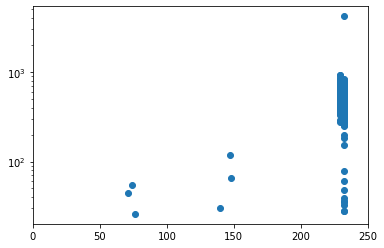

EGFRcterm_tile9_S20
1371


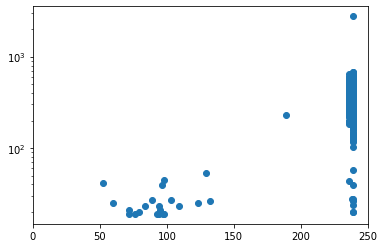

ERBB2cterm_tile10_S31
1450


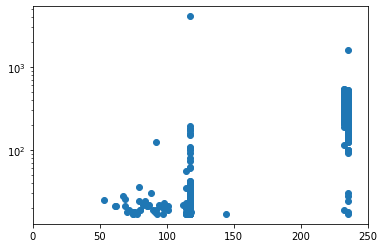

ERBB2cterm_tile11_S32
1106


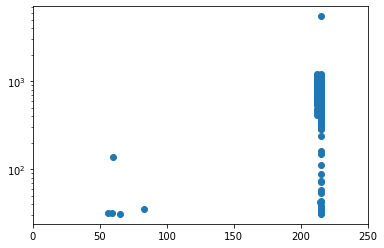

ERBB2cterm_tile1_S22
1073


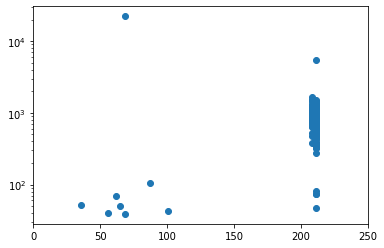

ERBB2cterm_tile2_S23
1306


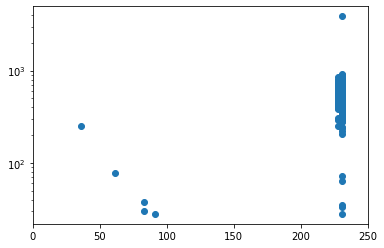

ERBB2cterm_tile3_S24
1343


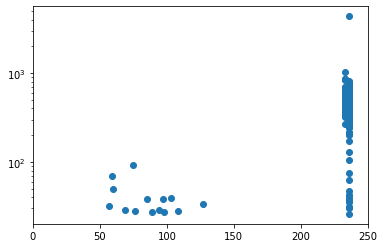

ERBB2cterm_tile4_S25
1369


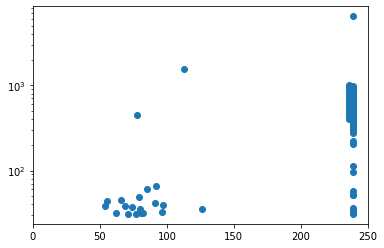

ERBB2cterm_tile5_S26
1332


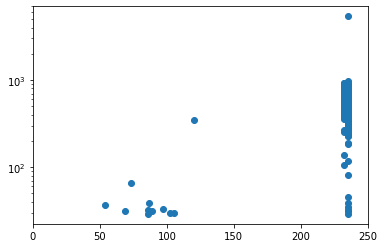

ERBB2cterm_tile6_S27
1342


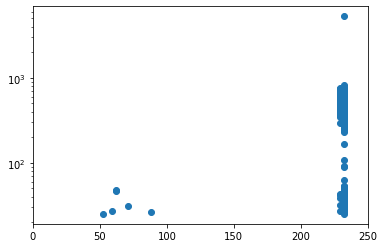

ERBB2cterm_tile7_S28
1469


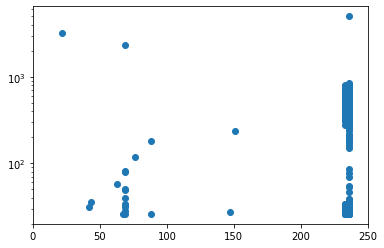

ERBB2cterm_tile8_S29
1379


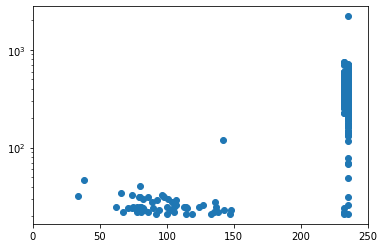

ERBB2cterm_tile9_S30
1330


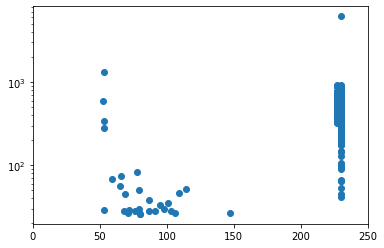

KSR1cterm_tile1_S83
1029


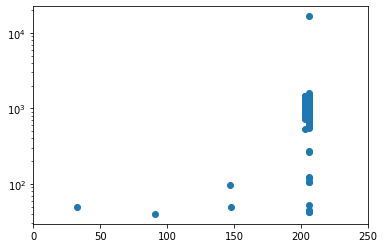

KSR1cterm_tile2_S84
1345


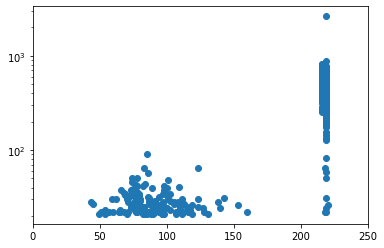

KSR1cterm_tile3_S85
1221


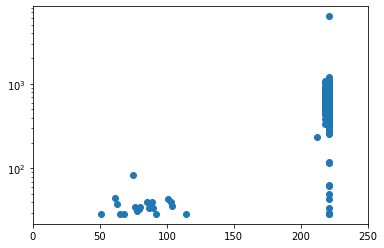

KSR1cterm_tile4_S86
1306


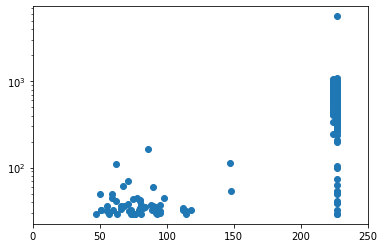

KSR1cterm_tile5_S87
1348


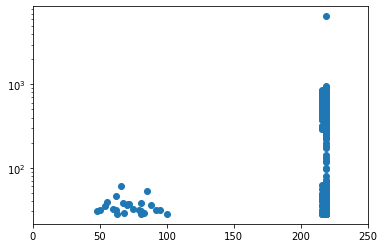

KSR1cterm_tile6_S88
1349


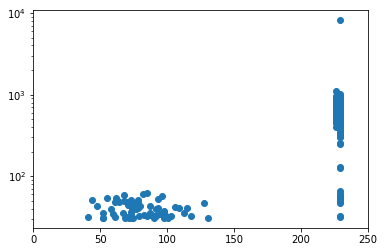

KSR1cterm_tile7_S89
1289


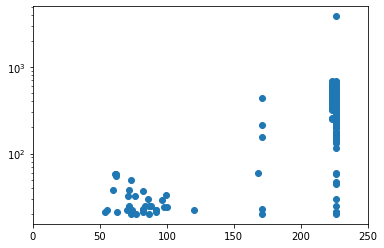

KSR1cterm_tile8_S90
1256


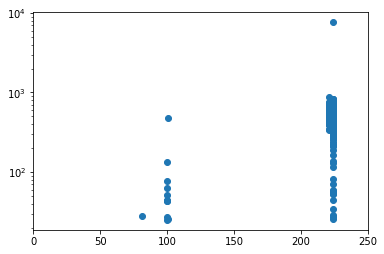

KSR1cterm_tile9_S91
1034


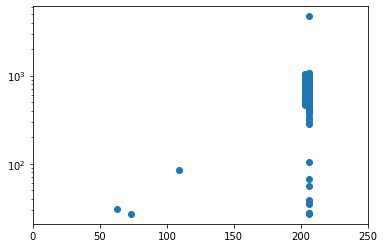

KSR1nterm_tile10_S82
1022


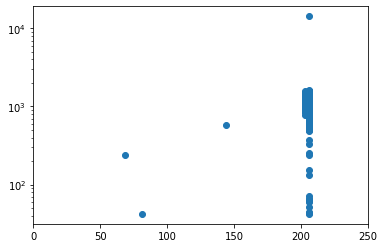

KSR1nterm_tile1_S73
1031


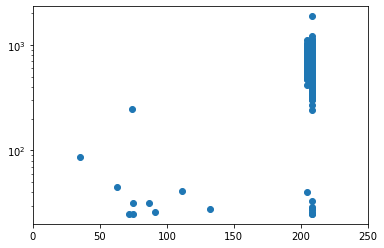

KSR1nterm_tile2_S74
1197


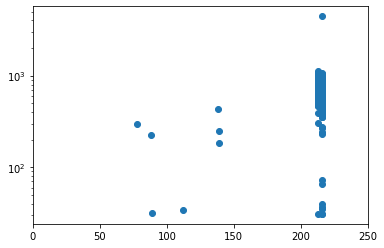

KSR1nterm_tile3_S75
1323


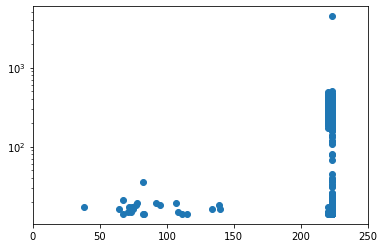

KSR1nterm_tile4_S76
1260


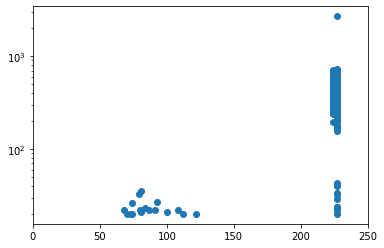

KSR1nterm_tile5_S77
1168


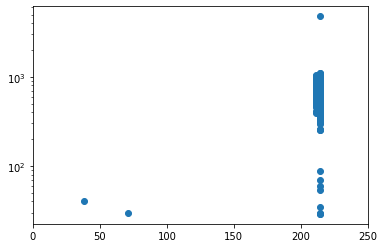

KSR1nterm_tile6_S78
1323


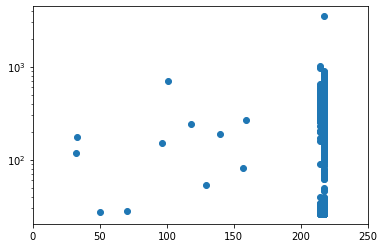

KSR1nterm_tile7_S79
1233


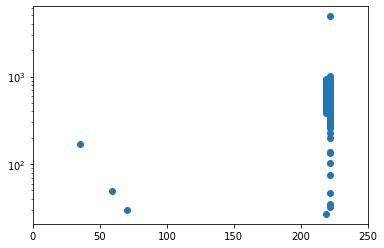

KSR1nterm_tile8_S80
1296


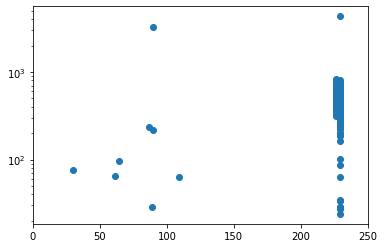

KSR1nterm_tile9_S81
1196


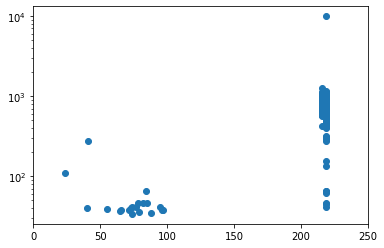

KSR2nterm_tile1_S92
1069


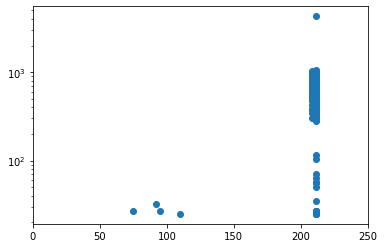

KSR2nterm_tile2_S93
1217


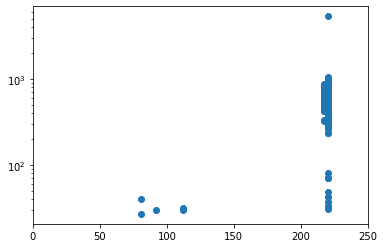

KSR2nterm_tile3_S94
1459


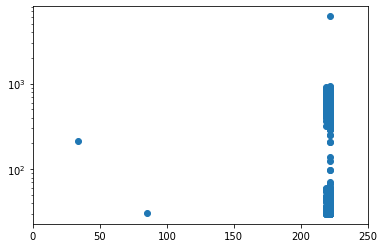

KSR2nterm_tile4_S95
1163


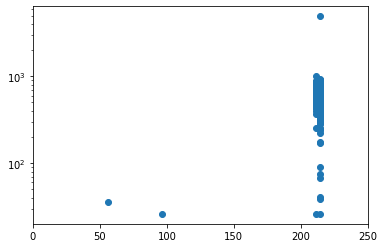

KSR2nterm_tile5_S96
1269


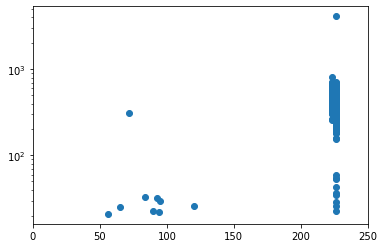

MRAS_tile1_S8
1132


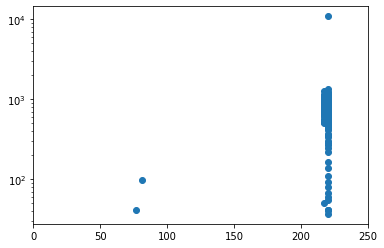

MRAS_tile2_S9
1348


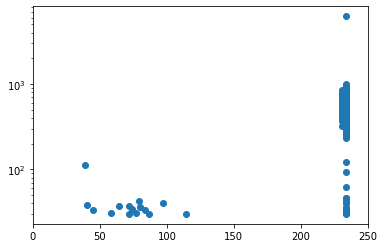

MRAS_tile3_S10
1417


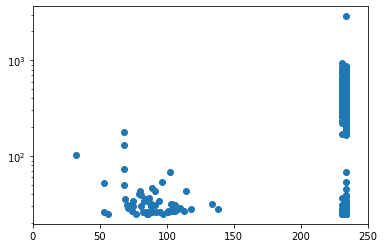

MRAS_tile4_S11
1151


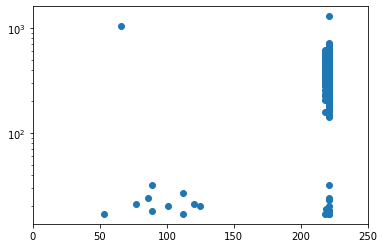

SHP2_tile10_S42
1329


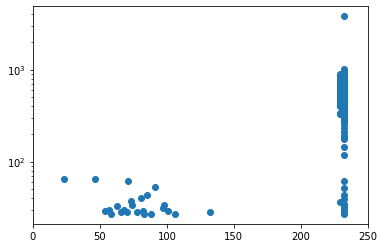

SHP2_tile11_S43
1178


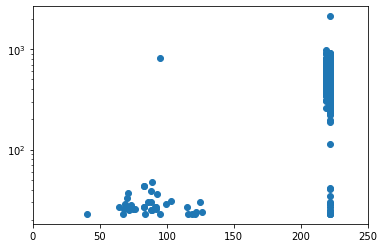

SHP2_tile1_S33
1134


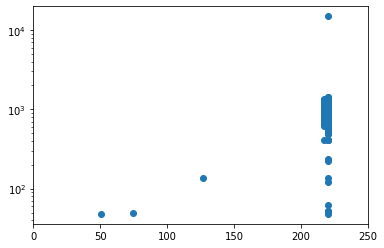

SHP2_tile2_S34
1325


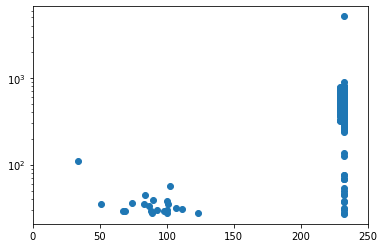

SHP2_tile3_S35
1412


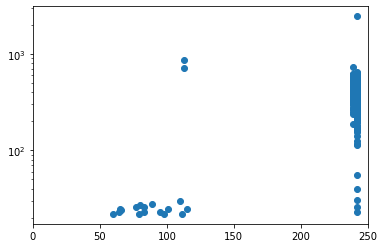

SHP2_tile4_S36
1387


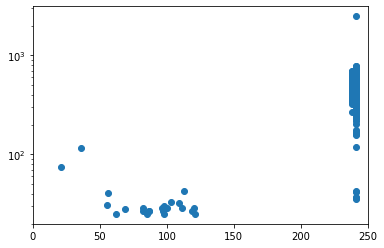

SHP2_tile5_S37
1343


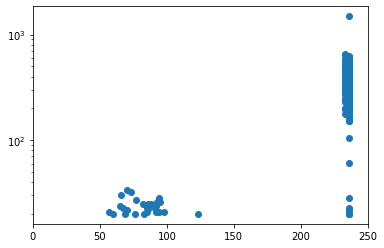

SHP2_tile6_S38
2079


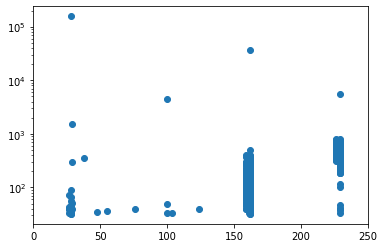

SHP2_tile7_S39
2075


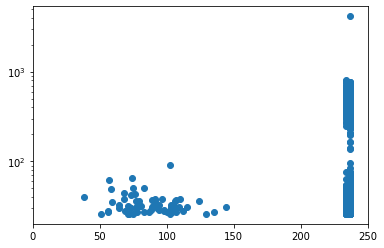

SHP2_tile8_S40
1383


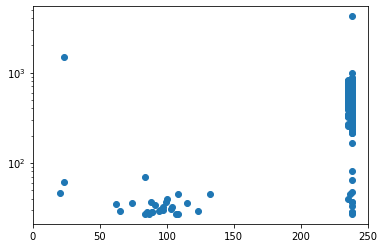

SHP2_tile9_S41
1324


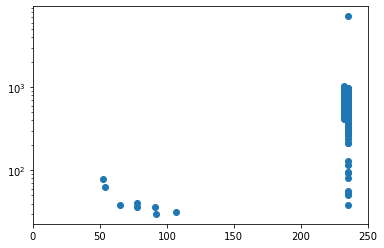

SOS2cterm_tile10_S53
1034


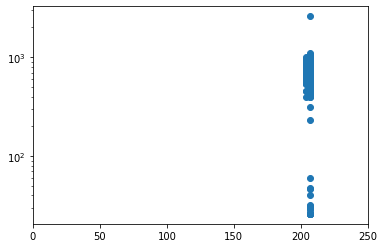

SOS2cterm_tile1_S44
1011


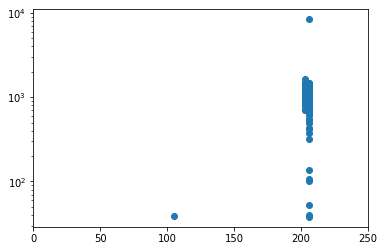

SOS2cterm_tile2_S45
1256


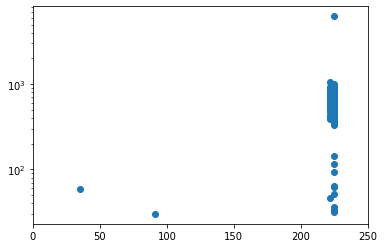

SOS2cterm_tile3_S46
1266


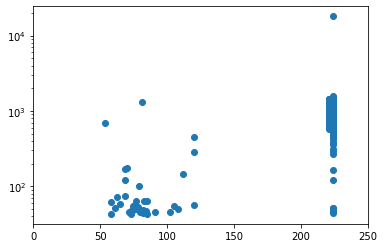

SOS2cterm_tile4_S47
1285


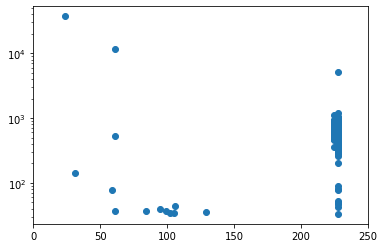

SOS2cterm_tile5_S48
1277


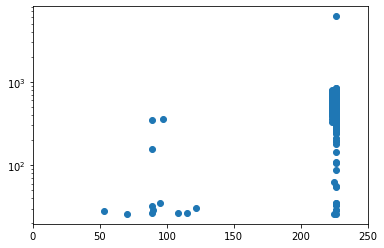

SOS2cterm_tile6_S49
1234


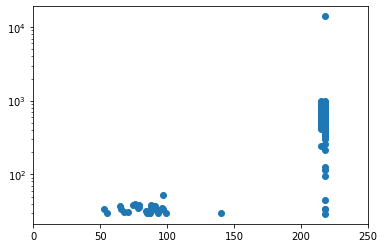

SOS2cterm_tile7_S50
1317


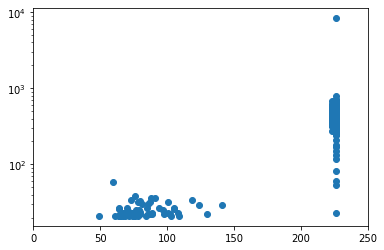

SOS2cterm_tile8_S51
1952


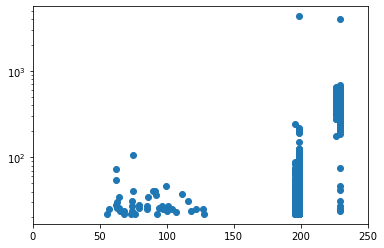

SOS2cterm_tile9_S52
1346


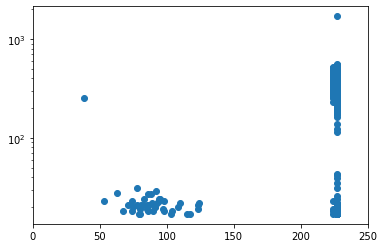

In [13]:
for key in oligo_subpools:
    print(key)
    print(len(barcodes_real[key]))
    plt.scatter([len(s) for s in barcodes_real[key]], [barcodes_unique_count[key][s] for s in barcodes_real[key]])
    plt.yscale('log')
    plt.xlim([0,250])
    plt.show()


In [14]:
# Import array
mapk_oligos = pd.read_csv('./MAPK_oligos_060524_v2FINAL.csv', names=['label','seq'])

# Map tile to tile
mapk_oligos['key'] = mapk_oligos['label'].map(lambda x: [y for y in oligo_subpools if (y.startswith(x.split('_')[0]) and (('tile'+x.split('_')[1].replace('block','')) == y.split('_')[1]) )])

# Get rid of tiles not sequenced
mapk_oligos['num_tiles_seqd'] = mapk_oligos['key'].map(lambda x: len(x))
mapk_oligos_filt = mapk_oligos[mapk_oligos['num_tiles_seqd'] == 1]
mapk_oligos_filt['key'] = mapk_oligos_filt['key'].map(lambda x: x[0])

<ipython-input-14-a0197fd07e86>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mapk_oligos_filt['key'] = mapk_oligos_filt['key'].map(lambda x: x[0])


In [15]:
# Remove WT
mapk_oligos_filt_WTremoved = mapk_oligos_filt[['WT' not in x for x in mapk_oligos_filt['label']]]
mapk_oligos_filt_WTonly = mapk_oligos_filt[['WT' in x for x in mapk_oligos_filt['label']]]


In [16]:
# Take the modal sequence and align to WT 
from Bio import pairwise2

# compute how much of the reads are what we want
most_common_seqs = {}
for key in oligo_subpools:
    print(key)
    wtseq = mapk_oligos_filt_WTonly[[key in s for s in mapk_oligos_filt_WTonly['key']]]['seq'].values[0]
    #print('Most common sequence: ' + '\t' + barcodes_unique_count[key].most_common()[0][0])
    most_common_seqs[key] = barcodes_unique_count[key].most_common()[0][0]
    alignments = pairwise2.align.globalxx(most_common_seqs[key], wtseq)
    print(pairwise2.format_alignment(*alignments[0]))


ARAFcterm_tile1_S60
AGTATTGCCGGACTAAACCCGGTCTCTCGTCGCTCTTCCCGGGACTCTGGTTATTATTGGGAGGTGCCCCCAAGCGAGGTCCAACTGCTCAAGCGAATCGGTACAGGTAGCTTCGGAACGGTGTTCCGCGGTCGATGGCATGGAGACGTAGCTGTTAAGGTATTGAAAAGAGACCGGGCGTCCGAATTATCAGTA
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
AGTATTGCCGGACTAAACCCGGTCTCTCGTCGCTCTTCCCGGGACTCTGGTTATTATTGGGAGGTGCCCCCAAGCGAGGTCCAACTGCTCAAGCGAATCGGTACAGGTAGCTTCGGAACGGTGTTCCGCGGTCGATGGCATGGAGACGTAGCTGTTAAGGTATTGAAAAGAGACCGGGCGTCCGAATTATCAGTA
  Score=195

ARAFcterm_tile2_S61
AGTATCTCAGCAAGGGCAACGGTCTCTTAAGGTATTGAAAGTGTCCCAGCCTACCGCCGAACAGGCGCAGGCATTCAAGAATGAGATGCAGGTTCTGCGAAAGACCCGCCATGTCAACATCTTGCTGTTTATGGGCTTCATGACCCGGCCGGGATTTGCCATCATCACACAGTAGAGACCGCTATCAGAGGAGACAACCC
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [17]:
# Check what fraction of oligos in array
for key in oligo_subpools:
    print(key)
    print('Fraction of oligos in ordered library: ' + str(
        len(
            set(barcodes_real[key]).\
            intersection(set(mapk_oligos_filt[mapk_oligos_filt['key'] == key]['seq']))
        )/len(barcodes_real[key])
    ))
    

ARAFcterm_tile1_S60
Fraction of oligos in ordered library: 0.9881847475832438
ARAFcterm_tile2_S61
Fraction of oligos in ordered library: 0.9925023430178069
ARAFcterm_tile3_S62
Fraction of oligos in ordered library: 0.9616368286445013
ARAFcterm_tile4_S63
Fraction of oligos in ordered library: 0.9917582417582418
ARAFcterm_tile5_S64
Fraction of oligos in ordered library: 0.9866785079928952
ARAFcterm_tile6_S65
Fraction of oligos in ordered library: 0.9879963065558633
ARAFcterm_tile7_S66
Fraction of oligos in ordered library: 0.9857578840284842
ARAFnterm_tile1_S54
Fraction of oligos in ordered library: 0.977538185085355
ARAFnterm_tile2_S55
Fraction of oligos in ordered library: 0.9855072463768116
ARAFnterm_tile3_S56
Fraction of oligos in ordered library: 0.9904761904761905
ARAFnterm_tile4_S57
Fraction of oligos in ordered library: 0.9729299363057324
ARAFnterm_tile5_S58
Fraction of oligos in ordered library: 0.9862595419847329
ARAFnterm_tile6_S59
Fraction of oligos in ordered library: 0.9557

In [18]:
# Check what fraction of array in oligos
for key in oligo_subpools:
    print(key)
    print('Fraction of ordered library in oligos: ' + str(
        len(
            set(barcodes_real[key]).\
            intersection(set(mapk_oligos_filt[mapk_oligos_filt['key'] == key]['seq']))
        )/len(mapk_oligos_filt[mapk_oligos_filt['key'] == key]['seq'])
    ))
    

ARAFcterm_tile1_S60
Fraction of ordered library in oligos: 1.0
ARAFcterm_tile2_S61
Fraction of ordered library in oligos: 1.0
ARAFcterm_tile3_S62
Fraction of ordered library in oligos: 1.0
ARAFcterm_tile4_S63
Fraction of ordered library in oligos: 0.9990774907749077
ARAFcterm_tile5_S64
Fraction of ordered library in oligos: 1.0
ARAFcterm_tile6_S65
Fraction of ordered library in oligos: 1.0
ARAFcterm_tile7_S66
Fraction of ordered library in oligos: 1.0
ARAFnterm_tile1_S54
Fraction of ordered library in oligos: 1.0
ARAFnterm_tile2_S55
Fraction of ordered library in oligos: 1.0
ARAFnterm_tile3_S56
Fraction of ordered library in oligos: 1.0
ARAFnterm_tile4_S57
Fraction of ordered library in oligos: 0.9991823385118561
ARAFnterm_tile5_S58
Fraction of ordered library in oligos: 0.9992266047950503
ARAFnterm_tile6_S59
Fraction of ordered library in oligos: 1.0
BRAFcterm_tile1_S1
Fraction of ordered library in oligos: 0.9981060606060606
BRAFcterm_tile2_S2
Fraction of ordered library in oligos: 0

In [19]:
# Check what fraction of reads in array, remove WT from array
for key in oligo_subpools:
    print(key)
    print('Fraction of reads in ordered library: ' + str(
        sum([barcodes_unique_count[key][x] for x in list(set(barcodes_real[key]).\
            intersection(set(mapk_oligos_filt_WTremoved[[key in s for s in mapk_oligos_filt_WTremoved['key']]]['seq'])))])\
        /len(barcodes_now[key])
    ))
    

ARAFcterm_tile1_S60
Fraction of reads in ordered library: 0.8083859350772771
ARAFcterm_tile2_S61
Fraction of reads in ordered library: 0.8139481679417255
ARAFcterm_tile3_S62
Fraction of reads in ordered library: 0.7514998042429656
ARAFcterm_tile4_S63
Fraction of reads in ordered library: 0.7971601521411344
ARAFcterm_tile5_S64
Fraction of reads in ordered library: 0.7837331021138568
ARAFcterm_tile6_S65
Fraction of reads in ordered library: 0.7780289379542026
ARAFcterm_tile7_S66
Fraction of reads in ordered library: 0.7954409200536362
ARAFnterm_tile1_S54
Fraction of reads in ordered library: 0.76334343033474
ARAFnterm_tile2_S55
Fraction of reads in ordered library: 0.7754606558265533
ARAFnterm_tile3_S56
Fraction of reads in ordered library: 0.7927389516655589
ARAFnterm_tile4_S57
Fraction of reads in ordered library: 0.7767754866369785
ARAFnterm_tile5_S58
Fraction of reads in ordered library: 0.776229561141777
ARAFnterm_tile6_S59
Fraction of reads in ordered library: 0.784777884062114
BRA

In [21]:
# Check what fraction of reads >= count in array, remove WT from array
for key in oligo_subpools:
    print(key)
    print('Fraction of reads in ordered library: ' + str(
        sum([barcodes_unique_count[key][x] for x in list(set(barcodes_real[key]).\
            intersection(set(mapk_oligos_filt_WTremoved[[key in s for s in mapk_oligos_filt_WTremoved['key']]]['seq']))) if barcodes_unique_count[key][x] >= cutoffs[key]])\
        /sum([barcodes_unique_count[key][x] for x in barcodes_unique_count[key].keys() if barcodes_unique_count[key][x] >= cutoffs[key]])
))
    

ARAFcterm_tile1_S60
Fraction of reads in ordered library: 0.9940793390707034
ARAFcterm_tile2_S61
Fraction of reads in ordered library: 0.9938585697185724
ARAFcterm_tile3_S62
Fraction of reads in ordered library: 0.9913280910579211
ARAFcterm_tile4_S63
Fraction of reads in ordered library: 0.9929136221603115
ARAFcterm_tile5_S64
Fraction of reads in ordered library: 0.9921256705612451
ARAFcterm_tile6_S65
Fraction of reads in ordered library: 0.9900629788419956
ARAFcterm_tile7_S66
Fraction of reads in ordered library: 0.991195004419606
ARAFnterm_tile1_S54
Fraction of reads in ordered library: 0.9937789470076999
ARAFnterm_tile2_S55
Fraction of reads in ordered library: 0.990468133835661
ARAFnterm_tile3_S56
Fraction of reads in ordered library: 0.9891198245247983
ARAFnterm_tile4_S57
Fraction of reads in ordered library: 0.9914007931734902
ARAFnterm_tile5_S58
Fraction of reads in ordered library: 0.9930600055090827
ARAFnterm_tile6_S59
Fraction of reads in ordered library: 0.9912094728461125
B

SHP2_tile6_S38


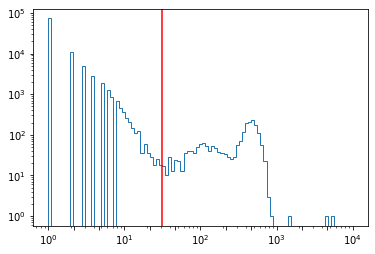

EGFRcterm_tile4_S15


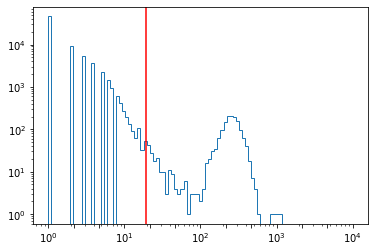

EGFRcterm_tile5_S16


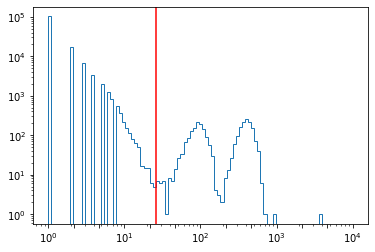

In [22]:
# Investigate some problem tiles:
for key in ['SHP2_tile6_S38','EGFRcterm_tile4_S15','EGFRcterm_tile5_S16']:
    print(key)
    labels, values = zip(*barcodes_unique_count[key].items())
    plt.hist(values, histtype='step', log=True, bins=10**np.linspace(0, 4, 100))
    plt.axvline(x = cutoffs[key], color = 'r', label = 'read cutoff')
    plt.xscale('log')
    plt.xticks(10**np.linspace(0, 4, 13))
    plt.show()


In [29]:
# Look at EGFRcterm_tile5 - possible synthesis error
EGFRcterm_tile5_lowerpeak_seqs = [x for x in barcodes_unique_count['EGFRcterm_tile5_S16'].keys() if barcodes_unique_count['EGFRcterm_tile5_S16'][x] == 100]
for lower_peak_seq in EGFRcterm_tile5_lowerpeak_seqs:
    wtseq = mapk_oligos_filt_WTonly[["EGFRcterm_tile5_S16" in s for s in mapk_oligos_filt_WTonly['key']]]['seq'].values[0]
    #print('Most common sequence: ' + '\t' + barcodes_unique_count[key].most_common()[0][0])
    alignments = pairwise2.align.globalxx(lower_peak_seq, wtseq)
    print(pairwise2.format_alignment(*alignments[0]))

CGATAGAACGACCAGGTAGCGGTCTCTGGAATCAATTTTACACAGAATCTATACCCACCAGAGTGATGTCTGGAGC-ACCGGGGTGACCGTTTGGGAGTTGATGACCTTTGGATCCAAGCCATATGACGGAATCCCTGCCAGCGAGATCTCCTCCATCCTGGAGAAAGGAGAACGCCTCCCTCAGCCACCCATATGTACCATCGATGA-CTAAGAGACCGCTTGACGGAGCATCTATCT
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| | ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||  ||||||||||||||||||||||||||||||
CGATAGAACGACCAGGTAGCGGTCTCTGGAATCAATTTTACACAGAATCTATACCCACCAGAGTGATGTCTGGAGCTA-CGGGGTGACCGTTTGGGAGTTGATGACCTTTGGATCCAAGCCATATGACGGAATCCCTGCCAGCGAGATCTCCTCCATCCTGGAGAAAGGAGAACGCCTCCCTCAGCCACCCATATGTACCATCGATG-TCTAAGAGACCGCTTGACGGAGCATCTATCT
  Score=235

CGATAGAACGACCAGGTAGCGGTCTCTGGAATCAATTA--ACCACAGAATCTATACCCACCAGAGTGATGTCTGGAGCTACGGGGTGACCGTTTGGGAGTTGATGACCTTTGGATCCAAGCCATATGACGGAATCCCTGCCAGCGAGATCTCCTCCATCCTGGAGAAAGGAGAACGCCTCCCTCAGCCACCCATATGTACCATCGATGA-CTAAGAGACCGCTTGACGGAGCATCTATCT
||||||||||||||||||||||||||

In [40]:
# Look at EGFRcterm_tile4 - deletions
from random import sample
EGFRcterm_tile4_del_seqs = [x for x in barcodes_unique_count['EGFRcterm_tile4_S15'].keys() if (barcodes_unique_count['EGFRcterm_tile4_S15'][x] > 200 & len(x) < 180)]
for del_seq in sample(EGFRcterm_tile4_del_seqs,10):
    wtseq = mapk_oligos_filt_WTonly[["EGFRcterm_tile4_S15" in s for s in mapk_oligos_filt_WTonly['key']]]['seq'].values[0]
    #print('Most common sequence: ' + '\t' + barcodes_unique_count[key].most_common()[0][0])
    alignments = pairwise2.align.globalxx(del_seq, wtseq)
    print(pairwise2.format_alignment(*alignments[0]))

AAAGGGGCCGTCAATATCAGGGTCTCTACTACCTCGAGGATCGGCGACTGGTACACCGGGACCTGGCCGCAAGAAATGTATTGGTCAAGACGCCGCAACATGTAAAAATAACTGATTTTGGGCTGGCCAAACTGCTGGGTGCGGAAT-AC-AAAGAATACCATGCAGAAGGAGGCAAAGTGCCTATCAAGTGGATGGCATTGGAATCAATTTTACACAGAAGAGACCCCAGGAAAGTCGGCTAATCAAGTCGGCTAATCT
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||  |  ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||     |   ||   |  ||||||||||||||
AAAGGGGCCGTCAATATCAGGGTCTCTACTACCTCGAGGATCGGCGACTGGTACACCGGGACCTGGCCGCAAGAAATGTATTGGTCAAGACGCCGCAACATGTAAAAATAACTGATTTTGGGCTGGCCAAACTGCTGGGTGCGGAA-GA-GAAAGAATACCATGCAGAAGGAGGCAAAGTGCCTATCAAGTGGATGGCATTGGAATCAATTTTACACAGAAGAGACCCC-----A---GG---A--AAGTCGGCTAATCT
  Score=243

AAAGGGGCCGTCAATATCAGGGTCTCT-C------G----T-------TG-T-----------T------A-----TG----G--C----C-----A----G-----------GA-------------AA---G-T-----CGG-------------C--T--A-A-----------T-C-T----------------------

In [42]:
## Look at SHP2_tile6 - deletions
from random import sample
SHP2_tile6_del_seqs = [x for x in barcodes_unique_count['SHP2_tile6_S38'].keys() if (barcodes_unique_count['SHP2_tile6_S38'][x] > 200 & len(x) < 180)]
for del_seq in sample(SHP2_tile6_del_seqs,20):
    wtseq = mapk_oligos_filt_WTonly[["SHP2_tile6_S38" in s for s in mapk_oligos_filt_WTonly['key']]]['seq'].values[0]
    #print('Most common sequence: ' + '\t' + barcodes_unique_count[key].most_common()[0][0])
    alignments = pairwise2.align.globalxx(del_seq, wtseq)
    print(pairwise2.format_alignment(*alignments[0]))

TTAGCTCAGGTCCAAAGTC-GG-CT---A-A----------T------------C--T-C-----TATC-T--------------------------------------------------------------------------------------------------------------------------------------------------------------
||||||||||||||||||| || ||   | |          |            |  | |     |||| |                                                                                                                                                              
TTAGCTCAGGTCCAAAGTCCGGTCTCTCAGAGACAAGAAAATAAGAATAAGAATCGATACAAGAATATCCTTCCCTTTGATCATACTCGCGTCGTTCTGCATGATGGGGATCCAAACGAACCAGTCTCCGATTATATTAACGCAAACATAATCATGCCCGAGTTTGAAACAAAATGCAACAACAGTAAACCTAAAAAGTCCTAGAGACCCCAGGAAAGTCGGCTAATCT
  Score=34

TTAGC-C----C-A--G---G-TC-C--A-A-A---G----T------------CG------G-----C-T--------A--AT-CT----------------------------------------------------------------------------------------------------------------------------------------------
||||| |    | |  |   | || |  | | |   |    |            ||      |     

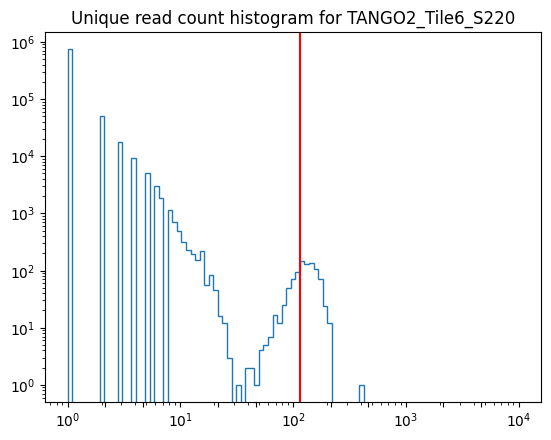

In [17]:
# Histogram for TANGO2_Tile6_S220
key = 'TANGO2_Tile6_S220'
if key in barcodes_unique_count:
    labels, values = zip(*barcodes_unique_count[key].items())
    plt.hist(values, histtype='step', log=True, bins=10**np.linspace(0, 4, 100))
    if 'cutoffs' in globals() and key in cutoffs:
        plt.axvline(x = cutoffs[key], color = 'r', label = 'read cutoff')
    plt.xscale('log')
    plt.xticks(10**np.linspace(0, 4, 13))
    plt.title(f'Unique read count histogram for {key}')
    plt.show()
else:
    print(f"Key {key} not found in barcodes_unique_count.")

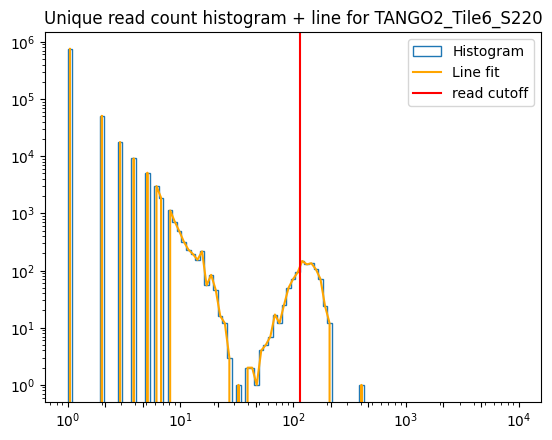

In [18]:
# Histogram + line plot for TANGO2_Tile6_S220
key = 'TANGO2_Tile6_S220'
if key in barcodes_unique_count:
    labels, values = zip(*barcodes_unique_count[key].items())
    bins = 10**np.linspace(0, 4, 100)
    plt.figure()
    # Histogram (step)
    plt.hist(values, histtype='step', log=True, bins=bins, label='Histogram')
    # Line plot overlay
    hist_counts, bin_edges = np.histogram(values, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(bin_centers, hist_counts, color='orange', label='Line fit')
    if 'cutoffs' in globals() and key in cutoffs:
        plt.axvline(x = cutoffs[key], color = 'r', label = 'read cutoff')
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks(10**np.linspace(0, 4, 13))
    plt.title(f'Unique read count histogram + line for {key}')
    plt.legend()
    plt.show()
else:
    print(f"Key {key} not found in barcodes_unique_count.")

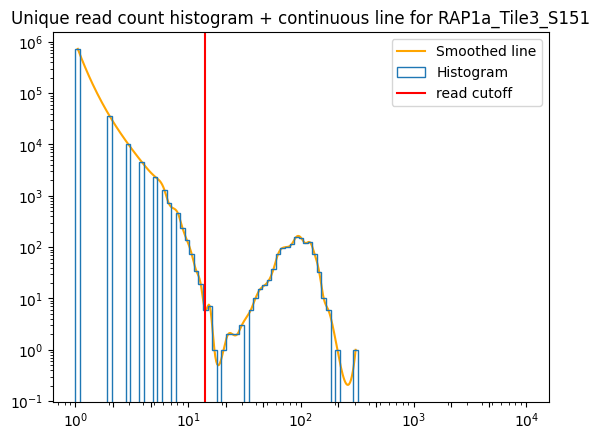

In [31]:
# Continuous line plot for TANGO2_Tile6_S220 histogram (smoothed)
from scipy.interpolate import make_interp_spline

key = 'RAP1a_Tile3_S151'
if key in barcodes_unique_count:
    labels, values = zip(*barcodes_unique_count[key].items())
    bins = 10**np.linspace(0, 4, 100)
    hist_counts, bin_edges = np.histogram(values, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Only use bins with nonzero counts for interpolation
    mask = hist_counts > 0
    x = bin_centers[mask]
    y = hist_counts[mask]
    # Smooth line using spline interpolation (log-log space for better fit)
    if len(x) > 3:
        spline = make_interp_spline(np.log10(x), np.log10(y), k=3)
        x_smooth = np.logspace(np.log10(x[0]), np.log10(x[-1]), 300)
        y_smooth = 10**spline(np.log10(x_smooth))
        plt.plot(x_smooth, y_smooth, color='orange', label='Smoothed line')
    # Plot histogram as step for reference
    plt.hist(values, histtype='step', log=True, bins=bins, label='Histogram')
    if 'cutoffs' in globals() and key in cutoffs:
        plt.axvline(x = cutoffs[key], color = 'r', label = 'read cutoff')
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks(10**np.linspace(0, 4, 13))
    plt.title(f'Unique read count histogram + continuous line for {key}')
    plt.legend()
    plt.show()
else:
    print(f"Key {key} not found in barcodes_unique_count.")

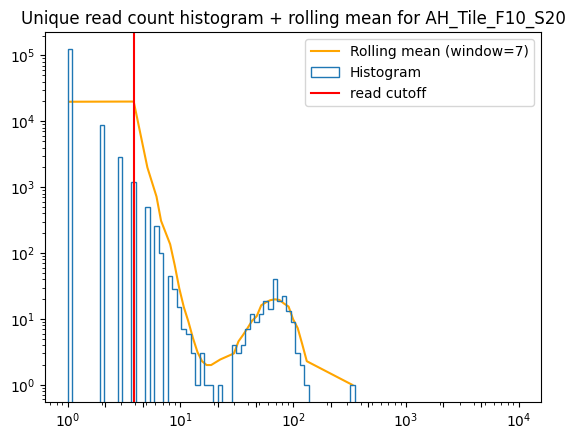

In [ ]:
# Smoother line plot for TANGO2_Tile6_S220 using rolling window
key = 'AH_Tile_F10_S20'
if key in barcodes_unique_count:
    labels, values = zip(*barcodes_unique_count[key].items())
    bins = 10**np.linspace(0, 4, 100)
    hist_counts, bin_edges = np.histogram(values, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Only use bins with nonzero counts for smoothing
    mask = hist_counts > 0
    x = bin_centers[mask]
    y = hist_counts[mask]
    # Apply rolling mean for smoothing (window size can be adjusted)
    window = 7  # must be odd
    if len(y) >= window:
        y_smooth = np.convolve(y, np.ones(window)/window, mode='same')
        plt.plot(x, y_smooth, color='orange', label=f'Rolling mean (window={window})')
    else:
        plt.plot(x, y, color='orange', label='Raw counts (too few for smoothing)')
    # Plot histogram as step for reference
    plt.hist(values, histtype='step', log=True, bins=bins, label='Histogram')
    if 'cutoffs' in globals() and key in cutoffs:
        plt.axvline(x = cutoffs[key], color = 'r', label = 'read cutoff')
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks(10**np.linspace(0, 4, 13))
    plt.title(f'Unique read count histogram + rolling mean for {key}')
    plt.legend()
    plt.show()
else:
    print(f"Key {key} not found in barcodes_unique_count.")

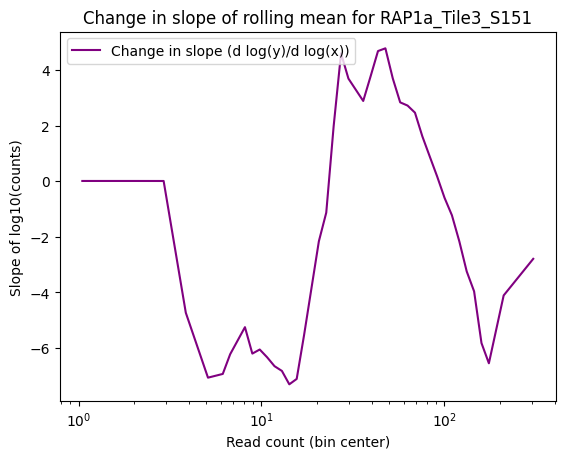

In [29]:
# Plot the change in slope (discrete derivative) of the rolling mean for TANGO2_Tile6_S220
key = 'RAP1a_Tile3_S151'
if key in barcodes_unique_count:
    labels, values = zip(*barcodes_unique_count[key].items())
    bins = 10**np.linspace(0, 4, 100)
    hist_counts, bin_edges = np.histogram(values, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    mask = hist_counts > 0
    x = bin_centers[mask]
    y = hist_counts[mask]
    window = 7  # should match previous smoothing
    if len(y) >= window:
        y_smooth = np.convolve(y, np.ones(window)/window, mode='same')
        # Compute discrete derivative (slope) in log-log space for better interpretability
        log_x = np.log10(x)
        log_y = np.log10(y_smooth)
        slope = np.gradient(log_y, log_x)
        plt.plot(x, slope, color='purple', label='Change in slope (d log(y)/d log(x))')
        plt.xscale('log')
        plt.xlabel('Read count (bin center)')
        plt.ylabel('Slope of log10(counts)')
        plt.title(f'Change in slope of rolling mean for {key}')
        plt.legend()
        plt.show()
    else:
        print('Too few points for smoothing and slope calculation.')
else:
    print(f"Key {key} not found in barcodes_unique_count.")

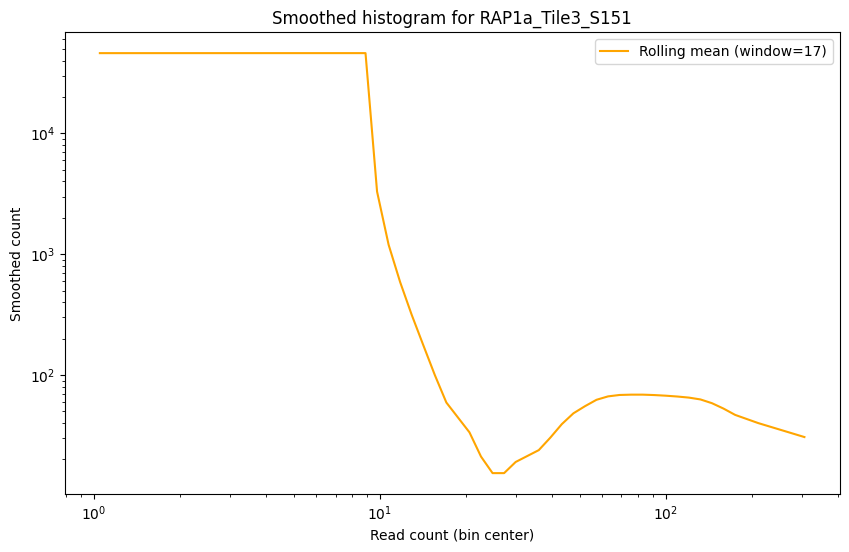

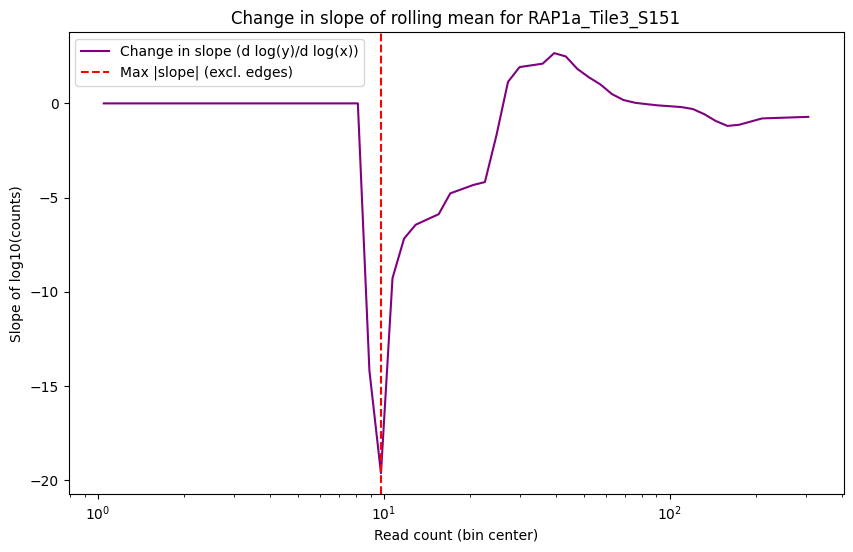

Max change in slope at x = 9.78


In [33]:
# Try a much smoother line (larger rolling window) for RAP1a_Tile3_S151 and plot
key = 'RAP1a_Tile3_S151'
if key in barcodes_unique_count:
    labels, values = zip(*barcodes_unique_count[key].items())
    bins = 10**np.linspace(0, 4, 100)
    hist_counts, bin_edges = np.histogram(values, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    mask = hist_counts > 0
    x = bin_centers[mask]
    y = hist_counts[mask]
    window = 17  # much larger window for more smoothing
    if len(y) >= window:
        y_smooth = np.convolve(y, np.ones(window)/window, mode='same')
        log_x = np.log10(x)
        log_y = np.log10(y_smooth)
        slope = np.gradient(log_y, log_x)
        n = len(x)
        start = int(0.1 * n)
        end = int(0.9 * n)
        slope_focus = slope[start:end]
        x_focus = x[start:end]
        if len(x_focus) > 0:
            max_idx = np.argmax(np.abs(slope_focus))
            x_max = x_focus[max_idx]
            plt.figure(figsize=(10,6))
            plt.plot(x, y_smooth, color='orange', label=f'Rolling mean (window={window})')
            plt.xscale('log')
            plt.yscale('log')
            plt.xlabel('Read count (bin center)')
            plt.ylabel('Smoothed count')
            plt.title(f'Smoothed histogram for {key}')
            plt.legend()
            plt.show()
            plt.figure(figsize=(10,6))
            plt.plot(x, slope, color='purple', label='Change in slope (d log(y)/d log(x))')
            plt.axvline(x=x_max, color='red', linestyle='--', label='Max |slope| (excl. edges)')
            plt.xscale('log')
            plt.xlabel('Read count (bin center)')
            plt.ylabel('Slope of log10(counts)')
            plt.title(f'Change in slope of rolling mean for {key}')
            plt.legend()
            plt.show()
            print(f'Max change in slope at x = {x_max:.2f}')
        else:
            print('No valid region for slope max.')
    else:
        print('Too few points for smoothing and slope calculation.')
else:
    print(f"Key {key} not found in barcodes_unique_count.")

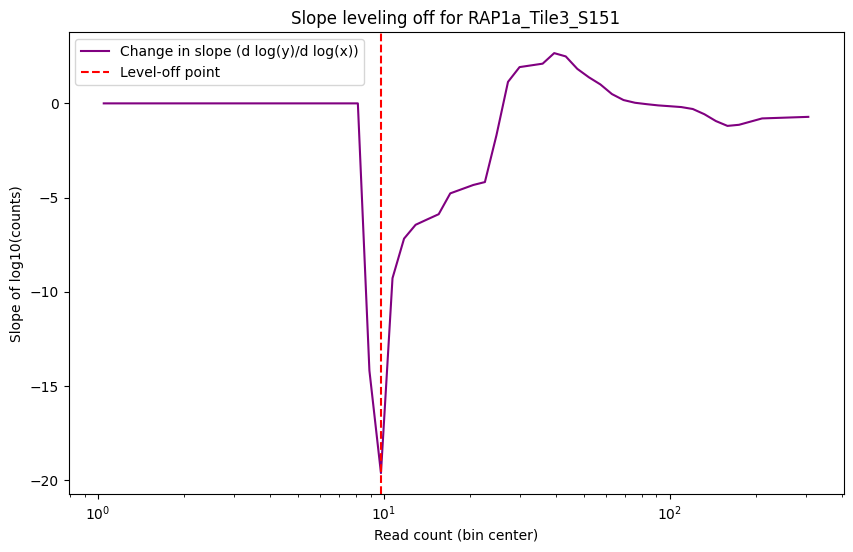

Slope levels off at x = 9.78


In [34]:
# Mark the point where the slope levels off before going up for RAP1a_Tile3_S151
key = 'RAP1a_Tile3_S151'
if key in barcodes_unique_count:
    labels, values = zip(*barcodes_unique_count[key].items())
    bins = 10**np.linspace(0, 4, 100)
    hist_counts, bin_edges = np.histogram(values, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    mask = hist_counts > 0
    x = bin_centers[mask]
    y = hist_counts[mask]
    window = 17  # keep smoothing high
    if len(y) >= window:
        y_smooth = np.convolve(y, np.ones(window)/window, mode='same')
        log_x = np.log10(x)
        log_y = np.log10(y_smooth)
        slope = np.gradient(log_y, log_x)
        n = len(x)
        start = int(0.1 * n)
        end = int(0.9 * n)
        slope_focus = slope[start:end]
        x_focus = x[start:end]
        # Find the last minimum before the slope increases (levels off before going up)
        from scipy.signal import argrelextrema
        minima_idx = argrelextrema(slope_focus, np.less)[0]
        if len(minima_idx) > 0:
            # Find the last minimum before the slope starts increasing
            min_idx = minima_idx[-1]
            x_level = x_focus[min_idx]
            plt.figure(figsize=(10,6))
            plt.plot(x, slope, color='purple', label='Change in slope (d log(y)/d log(x))')
            plt.axvline(x=x_level, color='red', linestyle='--', label='Level-off point')
            plt.xscale('log')
            plt.xlabel('Read count (bin center)')
            plt.ylabel('Slope of log10(counts)')
            plt.title(f'Slope leveling off for {key}')
            plt.legend()
            plt.show()
            print(f'Slope levels off at x = {x_level:.2f}')
        else:
            print('No clear level-off minimum found.')
    else:
        print('Too few points for smoothing and slope calculation.')
else:
    print(f"Key {key} not found in barcodes_unique_count.")